In [5]:
# parser = argparse.ArgumentParser(description="Choose RNN module: LSTM or GRU")
# parser.add_argument("--rnn_module", type=str, default="LSTM", help="Choose RNN module: LSTM or GRU")
# args = parser.parse_args()

rnn = "GRU"

In [6]:
import os
current_working_directory = os.getcwd()
print(current_working_directory)

import matplotlib.pyplot as plt
import numpy as np 
import torch 
import torch.nn as nn 
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
import scipy.io as sio

from tqdm import trange, tqdm
import argparse

# Import the quadruped model components from your second file
from mlp_quadruped_rnn import MLP, MLPQuadrupedProjectionFilter, CustomGRULayer, GRU_Hidden_State, CustomLSTMLayer, LSTM_Hidden_State


from scipy.spatial.transform import Rotation as R

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

/home/alinjar/simple_training_warm_start/Quadruped_qp
Using cuda device


In [7]:
class ForceDataset(Dataset):
    """Expert Trajectory Dataset."""
    def __init__(self, inp, desired_speed, desired_twisting_speed):
        # input
        self.inp = inp
        self.desired_speed = desired_speed
        self.desired_twisting_speed = desired_twisting_speed

    def __len__(self):
        return len(self.inp)    
        
    def __getitem__(self, idx):
        # Input
        inp = self.inp[idx]
        desired_speed = self.desired_speed[idx]
        desired_twisting_speed = self.desired_twisting_speed
        return torch.tensor(inp).float(), torch.tensor(desired_speed).float(), torch.tensor(desired_twisting_speed).float()    


def sample_uniform_variables(key, var_min, var_max, dataset_size, nvar):
    rng = np.random.default_rng(seed=key)
    xi_samples = rng.uniform(
        low=var_min,
        high=var_max,
        size=(dataset_size, nvar)
    )
    return xi_samples, rng


In [8]:


# Parameters for Quadruped Model
num_batch = 1
timestep = 0.05  # 50 Hz control frequency
horizon = 10     # prediction horizon steps
num_legs = 4
friction_coeff = 0.2
body_mass = 50.0  # kg

body_inertia=(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)

# Desired motion parameters
# desired_speed_x_tensor, rng = sample_uniform_variable(42, -0.5, 0.5, 1, 1)
# desired_speed_x = desired_speed_x_tensor.squeeze().item()
# print("desired_speed_x", desired_speed_x)
desired_body_height = 0.5     # m


In [9]:
##Parameters for MLP model
# Default states
BaseRollPitchYaw = (0.0, 0.0, 0.0)
AngularVelocityBodyFrame = (0.0, 0.0, 0.0)
ComVelocityBodyFrame = (0.0, 0.0, 0.0)
FootContacts = (True, True, True, True)
slope_estimate = (0.0, 0.0, 0.0)
RotationBodyWrtWorld = (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)

roll, pitch, yaw = BaseRollPitchYaw

# Create rotation object from Euler angles (in radians)
rot = R.from_euler('xyz', [roll, pitch, yaw])

# Convert to rotation matrix
rotation_matrix = rot.as_matrix()  # Shape (3, 3)

# Flatten into a 9-element tuple (row-major order)
RotationBodyWrtWorld = tuple(rotation_matrix.flatten())
#self.RotationBodyWrtWorld = (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)


"""Setup foot positions and default states for quadruped"""
# Foot positions in body frame
foot_x=0.2
foot_y=0.2
foot_z=-desired_body_height

FootPositionsInBodyFrame = torch.tensor([
    [ foot_x,  foot_y, foot_z],
    [-foot_x,  foot_y, foot_z],
    [ foot_x, -foot_y, foot_z],
    [-foot_x, -foot_y, foot_z]])

# Define QP matrices for quadruped control (simplified example)
# In practice, these would come from your quadruped dynamics model




# Maximum Iterations
maxiter_projection = 5

nvar = 3*num_legs*horizon

num_total_constraints = 2*nvar


In [10]:
dataset_size = 1*num_batch
desired_speed_batched, rng_desired_speed_batched = sample_uniform_variables(None, var_min= -0.0, var_max = 0.0, dataset_size=dataset_size, nvar=2)
desired_twisting_speed_batched,  rng_desired_twisting_speed_batched = sample_uniform_variables(
                                                                      42, var_min= -0.0, var_max = 0.0, dataset_size=dataset_size, 
                                                                      nvar=1)

desired_speed_batched_val, rng_desired_speed_batched = sample_uniform_variables(None, var_min= -0.1, var_max = 0.1, dataset_size=dataset_size, nvar=2)
desired_twisting_speed_batched_val,  rng_desired_twisting_speed_batched = sample_uniform_variables(
                                                                      39, var_min= -0.1, var_max = 0.1, dataset_size=dataset_size,
                                                                      nvar=1)

print("desired_speed_batched.shape", desired_speed_batched.shape)
print("desired_twisting_speed_batched.shape", desired_twisting_speed_batched.shape)

inp = np.hstack((desired_speed_batched, desired_twisting_speed_batched))

inp_val = np.hstack(( desired_speed_batched_val, desired_twisting_speed_batched_val))

# Using PyTorch Dataloader
train_dataset = ForceDataset(inp, desired_speed_batched, desired_twisting_speed_batched)
val_dataset = ForceDataset(inp_val, desired_speed_batched_val, desired_twisting_speed_batched_val)

train_loader = DataLoader(train_dataset, batch_size=num_batch, shuffle=True, num_workers=0, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=num_batch, shuffle=True, num_workers=0, drop_last=True)


desired_speed_batched.shape (1, 2)
desired_twisting_speed_batched.shape (1, 1)


In [11]:
if rnn == "GRU":
    print("Training with GRU")
    #GRU handling
    rnn = "GRU"
    gru_input_size = 3*num_total_constraints+3*nvar
    # print(gru_input_size)
    gru_hidden_size = 512
    # gru_output_size = (2*nvar)**2+2*nvar
    gru_output_size = num_total_constraints+nvar
    # gru_context_size = mlp_planner_inp_dim

    gru_context = CustomGRULayer(gru_input_size, gru_hidden_size, gru_output_size)

    rnn_context = gru_context


    input_hidden_state_init = np.shape(inp)[1]
    mid_hidden_state_init = 512
    out_hidden_state_init = gru_hidden_size

    gru_init  =  GRU_Hidden_State(input_hidden_state_init, mid_hidden_state_init, out_hidden_state_init)
    
    rnn_init = gru_init
    ##
elif rnn == "LSTM":
    print("Training with LSTM")
    #LSTM handling
    rnn = "LSTM"
    lstm_input_size = 3*num_total_constraints+3*nvar
    # print(lstm_input_size)
    lstm_hidden_size = 512
    # lstm_output_size = (2*nvar)**2+2*nvar
    lstm_output_size = num_total_constraints+nvar
    # lstm_context_size = mlp_planner_inp_dim

    lstm_context = CustomLSTMLayer(lstm_input_size, lstm_hidden_size, lstm_output_size)

    rnn_context = lstm_context

    input_hidden_state_init = np.shape(inp)[1]
    mid_hidden_state_init = 512
    out_hidden_state_init = lstm_hidden_size

    lstm_init = LSTM_Hidden_State(input_hidden_state_init, mid_hidden_state_init, out_hidden_state_init)

    rnn_init = lstm_init

    ##


Training with GRU


In [12]:
# MLP setup
enc_inp_dim = np.shape(inp)[1] 
mlp_inp_dim = enc_inp_dim
hidden_dim = 1024
mlp_out_dim = 2*nvar + num_total_constraints  # xi_samples, lambda_samples, slack_variables

mlp = MLP(mlp_inp_dim, hidden_dim, mlp_out_dim)

# Create the quadruped model
model = MLPQuadrupedProjectionFilter(
    mlp=mlp,
    rnn_context=rnn_context, 
    rnn_init=rnn_init, 
    num_batch=num_batch,
    maxiter_projection=maxiter_projection,
    BaseRollPitchYaw=BaseRollPitchYaw,
    AngularVelocityBodyFrame=AngularVelocityBodyFrame,
    ComVelocityBodyFrame=ComVelocityBodyFrame,
    FootPositionsInBodyFrame=FootPositionsInBodyFrame,
    FootContacts=FootContacts,
    slope_estimate=slope_estimate,
    RotationBodyWrtWorld=RotationBodyWrtWorld, 
    desired_body_height=desired_body_height,
    body_mass=body_mass,
    body_inertia=body_inertia,
    num_legs=num_legs,
    friction_coeff=friction_coeff,
    timestep=timestep,
    horizon=horizon,
    rnn=rnn).to(device)

print(f"Model type: {type(model)}")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")


Model type: <class 'mlp_quadruped_rnn.MLPQuadrupedProjectionFilter'>
Number of parameters: 4869192


In [13]:
# Training
epochs = 1500
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=6e-5)

losses = []
last_loss = torch.inf
avg_train_loss, avg_primal_loss, avg_fixed_point_loss, avg_qp_cost_loss = [], [], [], []
avg_val_loss = []

for epoch in range(epochs):
    
    # Train Loop
    model.train()
    losses_train, primal_losses, fixed_point_losses, qp_cost_losses = [], [], [], []
    
    for (inp, desired_speed_batched, desired_twisting_speed_batched) in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        
        desired_speed_batched, rng_desired_speed_batched = sample_uniform_variables(None, var_min= -2, var_max = 2, dataset_size=dataset_size, nvar=2)
        #desired_twisting_speed_batched, rng_desired_twisting_speed_batched = sample_uniform_variables(None, var_min= -0.5, var_max = 0.5, 
                                                                                                     # dataset_size=dataset_size, nvar=1)
        
        
        #print("desired_speed_batched", desired_speed_batched)

        desired_speed_batched = torch.tensor(desired_speed_batched).float()
        #desired_twisting_speed_batched = torch.tensor(desired_twisting_speed_batched).float()
        # Input and Output 
        inp = inp.to(device)
        desired_speed_batched = desired_speed_batched.to(device)
        desired_twisting_speed_batched = desired_twisting_speed_batched.to(device)
        
        # Forward pass through quadruped model
        xi_projected, avg_res_fixed_point, avg_res_primal, avg_res_qp_cost, res_primal_history, res_fixed_point_history, _ = model(inp, desired_speed_batched, 
                                                                                                               desired_twisting_speed_batched, rnn)
        
        
        # Compute loss
        primal_loss, fixed_point_loss, qp_cost_loss ,loss = model.mlp_loss(
            avg_res_primal, avg_res_fixed_point, avg_res_qp_cost)

        optimizer.zero_grad()
        loss.backward()
        
        # Optional gradient clipping
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        losses_train.append(loss.detach().cpu().numpy()) 
        primal_losses.append(primal_loss.detach().cpu().numpy())
        fixed_point_losses.append(fixed_point_loss.detach().cpu().numpy())
        qp_cost_losses.append(qp_cost_loss.detach().cpu().numpy())
        #projection_losses.append(projection_loss.detach().cpu().numpy())
        
    # Validation every 2 epochs
    if epoch % 2 == 0:
        model.eval()
        val_losses = []

        with torch.no_grad():
            for (inp_val, desired_speed_batched_val, desired_twisting_speed_batched_val) in tqdm(val_loader, desc="Validation"):
                inp_val = inp_val.to(device)
                desired_speed_batched_val = desired_speed_batched_val.to(device)
                desired_twisting_speed_batched_val = desired_twisting_speed_batched_val.to(device)

                xi_projected, avg_res_fixed_point, avg_res_primal, avg_res_qp_cost, res_primal_history, res_fixed_point_history, _ = model(inp_val, desired_speed_batched_val, 
                                                                                                                       desired_twisting_speed_batched_val,
                                                                                                                       rnn)
                
                _, _, _, val_loss = model.mlp_loss(
                    avg_res_primal, avg_res_fixed_point, avg_res_qp_cost
                )

                val_losses.append(val_loss.detach().cpu().numpy())

    # Print progress every 2 epochs
    if epoch % 2 == 0:    
        print(
            f"Epoch: {epoch + 1}, Train Loss: {np.average(losses_train):.4f}, "
        )

              #f"Projection Loss: {np.average(projection_losses):.4f}")
        
        if len(val_losses) > 0:
            print(f"Validation Loss: {np.average(val_losses):.4f}")

    # Save best model
    os.makedirs("./training_weights", exist_ok=True)
    if loss <= last_loss:
        torch.save(model.state_dict(), f"./training_weights/mlp_learned_quadruped_{rnn}.pth")
        last_loss = loss

    # Store metrics
    avg_train_loss.append(np.average(losses_train))
    avg_primal_loss.append(np.average(primal_losses))
    avg_qp_cost_loss.append(np.average(qp_cost_losses))
    avg_fixed_point_loss.append(np.average(fixed_point_losses))
    
    if len(val_losses) > 0:
        avg_val_loss.append(np.average(val_losses))
    else:
        avg_val_loss.append(avg_val_loss[-1] if avg_val_loss else 0.0)

print("Training completed!")



Epoch 1/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.86372364 -1.71546831]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.99it/s]


Epoch: 1, Train Loss: 2921.3994, Primal Loss: 0.0759, Fixed-Point Loss: 4.4165, QP Cost Loss: 7292.2671
Validation Loss: 1196.6584


Epoch 2/1500: 100%|██████████| 1/1 [00:00<00:00, 37.27it/s]


desired_speed_batched [[-1.56483165 -0.94108727]]


Epoch 3/1500: 100%|██████████| 1/1 [00:00<00:00, 37.41it/s]


desired_speed_batched [[ 1.30500518 -0.9659355 ]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.49it/s]


Epoch: 3, Train Loss: 1172.6840, Primal Loss: 0.0000, Fixed-Point Loss: 4.1347, QP Cost Loss: 2921.3730
Validation Loss: 507.0676


Epoch 4/1500: 100%|██████████| 1/1 [00:00<00:00, 34.20it/s]


desired_speed_batched [[0.06650017 0.68896276]]


Epoch 5/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.06396647 1.24506132]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.51it/s]


Epoch: 5, Train Loss: 845.0473, Primal Loss: 0.0000, Fixed-Point Loss: 4.5246, QP Cost Loss: 2101.3069
Validation Loss: 1062.6711


Epoch 6/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.44523508  1.21874036]]


Epoch 7/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.42782916 -0.27695229]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.75it/s]


Epoch: 7, Train Loss: 1454.1985, Primal Loss: 0.0000, Fixed-Point Loss: 4.3758, QP Cost Loss: 3624.5564
Validation Loss: 1106.8982


Epoch 8/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.11470303 0.45623875]]


Epoch 9/1500: 100%|██████████| 1/1 [00:00<00:00, 41.62it/s]


desired_speed_batched [[-0.30926757 -0.39396419]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.37it/s]


Epoch: 9, Train Loss: 1045.5900, Primal Loss: 0.0000, Fixed-Point Loss: 4.0226, QP Cost Loss: 2603.9185
Validation Loss: 724.2695


Epoch 10/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.6406359   0.88727788]]


Epoch 11/1500: 100%|██████████| 1/1 [00:00<00:00, 39.36it/s]


desired_speed_batched [[-0.62174953 -0.7801726 ]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.73it/s]


Epoch: 11, Train Loss: 1179.6188, Primal Loss: 0.0000, Fixed-Point Loss: 4.1338, QP Cost Loss: 2938.7124
Validation Loss: 545.4893


Epoch 12/1500: 100%|██████████| 1/1 [00:00<00:00, 37.70it/s]


desired_speed_batched [[-0.98225373  0.06250521]]


Epoch 13/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.88945234 -0.71617238]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.38it/s]


Epoch: 13, Train Loss: 793.6887, Primal Loss: 0.0000, Fixed-Point Loss: 4.2959, QP Cost Loss: 1973.4821
Validation Loss: 415.1902


Epoch 14/1500: 100%|██████████| 1/1 [00:00<00:00, 41.62it/s]


desired_speed_batched [[-0.69054706 -0.73177587]]


Epoch 15/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.27802976 0.02870079]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.26it/s]


Epoch: 15, Train Loss: 806.2111, Primal Loss: 0.0000, Fixed-Point Loss: 4.0921, QP Cost Loss: 2005.2972
Validation Loss: 326.4988


Epoch 16/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.62494981  1.60468575]]


Epoch 17/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.27545917 -1.12408995]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.53it/s]


Epoch: 17, Train Loss: 564.8185, Primal Loss: 0.0000, Fixed-Point Loss: 4.0679, QP Cost Loss: 1401.8765
Validation Loss: 249.2673


Epoch 18/1500: 100%|██████████| 1/1 [00:00<00:00, 39.62it/s]


desired_speed_batched [[ 0.83702622 -0.58577491]]


Epoch 19/1500: 100%|██████████| 1/1 [00:00<00:00, 34.85it/s]


desired_speed_batched [[0.79910877 0.35050592]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.60it/s]


Epoch: 19, Train Loss: 538.9477, Primal Loss: 0.0000, Fixed-Point Loss: 4.0813, QP Cost Loss: 1337.1660
Validation Loss: 295.4764


Epoch 20/1500: 100%|██████████| 1/1 [00:00<00:00, 39.76it/s]


desired_speed_batched [[-1.13853045  1.3723727 ]]


Epoch 21/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.21362633 0.74861855]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.45it/s]


Epoch: 21, Train Loss: 635.5761, Primal Loss: 0.0000, Fixed-Point Loss: 4.0963, QP Cost Loss: 1578.6995
Validation Loss: 366.8509


Epoch 22/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.02695163 -1.10601775]]


Epoch 23/1500: 100%|██████████| 1/1 [00:00<00:00, 32.39it/s]


desired_speed_batched [[-1.59822121  0.26177228]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 37.97it/s]


Epoch: 23, Train Loss: 1131.1455, Primal Loss: 0.0000, Fixed-Point Loss: 4.3281, QP Cost Loss: 2817.0435
Validation Loss: 309.3583


Epoch 24/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.56470628 -1.40352306]]


Epoch 25/1500: 100%|██████████| 1/1 [00:00<00:00, 37.52it/s]

desired_speed_batched [[ 1.68569973 -1.77647587]]



Validation: 100%|██████████| 1/1 [00:00<00:00, 51.94it/s]


Epoch: 25, Train Loss: 857.6686, Primal Loss: 0.5666, Fixed-Point Loss: 4.4052, QP Cost Loss: 2131.7419
Validation Loss: 295.4079


Epoch 26/1500: 100%|██████████| 1/1 [00:00<00:00, 41.43it/s]


desired_speed_batched [[1.0136742  1.51878088]]


Epoch 27/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.82626119 1.7786842 ]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.96it/s]


Epoch: 27, Train Loss: 489.8904, Primal Loss: 0.3857, Fixed-Point Loss: 4.9026, QP Cost Loss: 1211.5052
Validation Loss: 327.0176


Epoch 28/1500: 100%|██████████| 1/1 [00:00<00:00, 39.67it/s]


desired_speed_batched [[-1.86052546 -0.45014709]]


Epoch 29/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.13937657 1.10335669]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.08it/s]


Epoch: 29, Train Loss: 854.6666, Primal Loss: 0.0000, Fixed-Point Loss: 4.1499, QP Cost Loss: 2126.2917
Validation Loss: 298.6609


Epoch 30/1500: 100%|██████████| 1/1 [00:00<00:00, 43.05it/s]


desired_speed_batched [[-1.61687295  1.14240368]]


Epoch 31/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.35196207  0.98316794]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.98it/s]


Epoch: 31, Train Loss: 535.9822, Primal Loss: 0.0000, Fixed-Point Loss: 4.1692, QP Cost Loss: 1329.5326
Validation Loss: 238.4595


Epoch 32/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.11265578 -0.31430935]]


Epoch 33/1500: 100%|██████████| 1/1 [00:00<00:00, 39.37it/s]


desired_speed_batched [[-0.47191818 -0.93266255]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.12it/s]


Epoch: 33, Train Loss: 375.1389, Primal Loss: 0.0000, Fixed-Point Loss: 3.9412, QP Cost Loss: 927.9944
Validation Loss: 167.2771


Epoch 34/1500: 100%|██████████| 1/1 [00:00<00:00, 39.96it/s]


desired_speed_batched [[ 0.71627271 -1.22202459]]


Epoch 35/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.11213336 1.53217879]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.40it/s]


Epoch: 35, Train Loss: 597.6111, Primal Loss: 0.0000, Fixed-Point Loss: 4.0149, QP Cost Loss: 1483.9904
Validation Loss: 176.6693


Epoch 36/1500: 100%|██████████| 1/1 [00:00<00:00, 39.60it/s]


desired_speed_batched [[ 1.89276348 -0.29771146]]


Epoch 37/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.16550421 1.42812395]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.32it/s]


Epoch: 37, Train Loss: 364.9785, Primal Loss: 0.0000, Fixed-Point Loss: 3.8253, QP Cost Loss: 902.8832
Validation Loss: 217.3449


Epoch 38/1500: 100%|██████████| 1/1 [00:00<00:00, 41.03it/s]


desired_speed_batched [[-1.7844492 -0.8626774]]


Epoch 39/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.2131513   1.29442856]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.03it/s]


Epoch: 39, Train Loss: 520.9119, Primal Loss: 0.0712, Fixed-Point Loss: 3.8721, QP Cost Loss: 1292.4214
Validation Loss: 254.6490


Epoch 40/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.04800638 0.7696307 ]]


Epoch 41/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.35021731 0.20485466]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 34.40it/s]


Epoch: 41, Train Loss: 359.8259, Primal Loss: 0.0000, Fixed-Point Loss: 3.8219, QP Cost Loss: 890.0099
Validation Loss: 228.1900


Epoch 42/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.4277506 1.8047151]]


Epoch 43/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.8184077  1.90457716]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.47it/s]


Epoch: 43, Train Loss: 423.1171, Primal Loss: 0.1458, Fixed-Point Loss: 4.1074, QP Cost Loss: 1047.1598
Validation Loss: 230.3761


Epoch 44/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.2472264  -0.83979491]]


Epoch 45/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.10546851 -0.06300306]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.57it/s]


Epoch: 45, Train Loss: 447.9857, Primal Loss: 0.0000, Fixed-Point Loss: 3.8199, QP Cost Loss: 1110.4144
Validation Loss: 152.7010


Epoch 46/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.66062534 -1.05320301]]


Epoch 47/1500: 100%|██████████| 1/1 [00:00<00:00, 31.65it/s]


desired_speed_batched [[ 0.87231768 -0.93352231]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.14it/s]


Epoch: 47, Train Loss: 312.8262, Primal Loss: 0.0000, Fixed-Point Loss: 3.7525, QP Cost Loss: 772.6842
Validation Loss: 91.9010


Epoch 48/1500: 100%|██████████| 1/1 [00:00<00:00, 38.02it/s]


desired_speed_batched [[-0.12135126 -1.52298847]]


Epoch 49/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.88357375 -1.02505825]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.40it/s]


Epoch: 49, Train Loss: 399.4550, Primal Loss: 0.0000, Fixed-Point Loss: 3.7654, QP Cost Loss: 989.2238
Validation Loss: 160.4445


Epoch 50/1500: 100%|██████████| 1/1 [00:00<00:00, 40.38it/s]


desired_speed_batched [[1.1028967  1.91165202]]


Epoch 51/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.74435525 -1.58079438]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.28it/s]


Epoch: 51, Train Loss: 310.8621, Primal Loss: 0.0323, Fixed-Point Loss: 3.6618, QP Cost Loss: 767.9200
Validation Loss: 236.9192


Epoch 52/1500: 100%|██████████| 1/1 [00:00<00:00, 39.77it/s]


desired_speed_batched [[-0.24861984  0.53988618]]


Epoch 53/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.01307623 0.49808672]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.01it/s]


Epoch: 53, Train Loss: 389.9615, Primal Loss: 0.0000, Fixed-Point Loss: 3.7014, QP Cost Loss: 965.6502
Validation Loss: 193.9825


Epoch 54/1500: 100%|██████████| 1/1 [00:00<00:00, 33.75it/s]


desired_speed_batched [[-0.98411357 -0.29399846]]


Epoch 55/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.9474704  0.29801593]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.39it/s]


Epoch: 55, Train Loss: 321.7209, Primal Loss: 0.0000, Fixed-Point Loss: 3.6767, QP Cost Loss: 795.1107
Validation Loss: 122.0594


Epoch 56/1500: 100%|██████████| 1/1 [00:00<00:00, 38.97it/s]


desired_speed_batched [[-0.34927703 -1.42023826]]


Epoch 57/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.92910777 -1.67336755]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.65it/s]


Epoch: 57, Train Loss: 362.0154, Primal Loss: 0.0571, Fixed-Point Loss: 3.5582, QP Cost Loss: 896.0002
Validation Loss: 96.6457


Epoch 58/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.78333333  0.95393537]]


Epoch 59/1500: 100%|██████████| 1/1 [00:00<00:00, 39.38it/s]

desired_speed_batched [[-0.35664246 -1.29094219]]



Validation: 100%|██████████| 1/1 [00:00<00:00, 42.86it/s]


Epoch: 59, Train Loss: 243.3830, Primal Loss: 0.0000, Fixed-Point Loss: 3.8095, QP Cost Loss: 598.9338
Validation Loss: 93.0438


Epoch 60/1500: 100%|██████████| 1/1 [00:00<00:00, 40.60it/s]


desired_speed_batched [[-0.05892437  1.64865273]]


Epoch 61/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.95637123 -0.68658875]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.61it/s]


Epoch: 61, Train Loss: 334.8922, Primal Loss: 0.0000, Fixed-Point Loss: 3.7897, QP Cost Loss: 827.7563
Validation Loss: 124.3313


Epoch 62/1500: 100%|██████████| 1/1 [00:00<00:00, 39.81it/s]


desired_speed_batched [[-0.04489559  1.30862063]]


Epoch 63/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.71079686  0.77231349]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.34it/s]


Epoch: 63, Train Loss: 307.0462, Primal Loss: 0.0570, Fixed-Point Loss: 3.7161, QP Cost Loss: 758.1827
Validation Loss: 187.4386


Epoch 64/1500: 100%|██████████| 1/1 [00:00<00:00, 40.39it/s]


desired_speed_batched [[-0.93487903  1.69612202]]


Epoch 65/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.44412557 -1.21769656]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.28it/s]


Epoch: 65, Train Loss: 250.5780, Primal Loss: 0.0887, Fixed-Point Loss: 3.6215, QP Cost Loss: 617.1694
Validation Loss: 175.5836


Epoch 66/1500: 100%|██████████| 1/1 [00:00<00:00, 40.03it/s]


desired_speed_batched [[1.02069078 0.05500055]]


Epoch 67/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.18260333 -1.17007373]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.77it/s]


Epoch: 67, Train Loss: 332.4621, Primal Loss: 0.0000, Fixed-Point Loss: 3.6538, QP Cost Loss: 822.0207
Validation Loss: 112.0161


Epoch 68/1500: 100%|██████████| 1/1 [00:00<00:00, 39.71it/s]


desired_speed_batched [[-0.5392993  -1.73817936]]


Epoch 69/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.23162805 1.79487304]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.25it/s]

Epoch: 69, Train Loss: 246.6073, Primal Loss: 0.1598, Fixed-Point Loss: 3.7992, QP Cost Loss: 606.6207
Validation Loss: 82.8095



Epoch 70/1500: 100%|██████████| 1/1 [00:00<00:00, 38.58it/s]


desired_speed_batched [[0.78521077 1.26904367]]


Epoch 71/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.98770273 -1.37392134]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.44it/s]


Epoch: 71, Train Loss: 310.9541, Primal Loss: 0.5342, Fixed-Point Loss: 4.0675, QP Cost Loss: 765.8811
Validation Loss: 93.3431


Epoch 72/1500: 100%|██████████| 1/1 [00:00<00:00, 36.03it/s]


desired_speed_batched [[-0.89716867  1.08585058]]


Epoch 73/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.07761582  0.41772391]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.11it/s]


Epoch: 73, Train Loss: 302.7610, Primal Loss: 0.0000, Fixed-Point Loss: 3.4701, QP Cost Loss: 748.2272
Validation Loss: 104.7966


Epoch 74/1500: 100%|██████████| 1/1 [00:00<00:00, 40.79it/s]


desired_speed_batched [[-1.14154758  1.10457929]]


Epoch 75/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.94623647 -0.2772869 ]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.60it/s]


Epoch: 75, Train Loss: 221.2314, Primal Loss: 0.0000, Fixed-Point Loss: 3.4876, QP Cost Loss: 544.3594
Validation Loss: 102.3335


Epoch 76/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.44940457 1.61501906]]


Epoch 77/1500: 100%|██████████| 1/1 [00:00<00:00, 34.71it/s]


desired_speed_batched [[ 0.37329078 -1.70435946]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.90it/s]


Epoch: 77, Train Loss: 259.6202, Primal Loss: 0.0000, Fixed-Point Loss: 3.5232, QP Cost Loss: 640.2426
Validation Loss: 106.8772


Epoch 78/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.44333084 -1.7297079 ]]


Epoch 79/1500: 100%|██████████| 1/1 [00:00<00:00, 38.78it/s]


desired_speed_batched [[ 0.60498957 -1.75452409]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.45it/s]


Epoch: 79, Train Loss: 246.2478, Primal Loss: 0.0400, Fixed-Point Loss: 3.4769, QP Cost Loss: 606.8273
Validation Loss: 111.0147


Epoch 80/1500: 100%|██████████| 1/1 [00:00<00:00, 40.24it/s]


desired_speed_batched [[-0.37240857  1.5267211 ]]


Epoch 81/1500: 100%|██████████| 1/1 [00:00<00:00, 36.35it/s]


desired_speed_batched [[0.25419042 1.50474493]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.50it/s]


Epoch: 81, Train Loss: 237.2482, Primal Loss: 0.0000, Fixed-Point Loss: 3.4118, QP Cost Loss: 584.5911
Validation Loss: 126.2335


Epoch 82/1500: 100%|██████████| 1/1 [00:00<00:00, 39.83it/s]


desired_speed_batched [[-0.41969416  1.60033224]]


Epoch 83/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.29449088  0.96652244]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.58it/s]


Epoch: 83, Train Loss: 203.6994, Primal Loss: 0.0000, Fixed-Point Loss: 3.4775, QP Cost Loss: 500.5548
Validation Loss: 125.0857


Epoch 84/1500: 100%|██████████| 1/1 [00:00<00:00, 39.45it/s]


desired_speed_batched [[-1.24632857 -0.93475621]]


Epoch 85/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.69907428 1.32180548]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.01it/s]


Epoch: 85, Train Loss: 298.0043, Primal Loss: 0.1131, Fixed-Point Loss: 3.4979, QP Cost Loss: 735.9831
Validation Loss: 116.7539


Epoch 86/1500: 100%|██████████| 1/1 [00:00<00:00, 40.12it/s]


desired_speed_batched [[0.21935915 1.56124387]]


Epoch 87/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.46192333 -1.84327801]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.28it/s]


Epoch: 87, Train Loss: 269.9010, Primal Loss: 0.0932, Fixed-Point Loss: 3.4250, QP Cost Loss: 665.9570
Validation Loss: 105.2154


Epoch 88/1500: 100%|██████████| 1/1 [00:00<00:00, 40.40it/s]


desired_speed_batched [[1.30420851 0.58542403]]


Epoch 89/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.07553597 -1.97233184]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.69it/s]


Epoch: 89, Train Loss: 316.2510, Primal Loss: 0.2453, Fixed-Point Loss: 3.8533, QP Cost Loss: 780.3810
Validation Loss: 117.4398


Epoch 90/1500: 100%|██████████| 1/1 [00:00<00:00, 38.78it/s]


desired_speed_batched [[-1.8018701   0.45699724]]


Epoch 91/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.79952999 -1.58127929]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.84it/s]


Epoch: 91, Train Loss: 266.7949, Primal Loss: 0.0000, Fixed-Point Loss: 3.2207, QP Cost Loss: 658.9355
Validation Loss: 144.8209


Epoch 92/1500: 100%|██████████| 1/1 [00:00<00:00, 39.32it/s]


desired_speed_batched [[ 1.68237874 -1.16702569]]


Epoch 93/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.65481862  0.91300103]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.32it/s]


Epoch: 93, Train Loss: 233.7521, Primal Loss: 0.0661, Fixed-Point Loss: 3.4731, QP Cost Loss: 575.5322
Validation Loss: 141.0568


Epoch 94/1500: 100%|██████████| 1/1 [00:00<00:00, 41.21it/s]


desired_speed_batched [[ 0.16764187 -0.91642133]]


Epoch 95/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.83703267 -0.27818584]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.91it/s]


Epoch: 95, Train Loss: 315.3163, Primal Loss: 0.0000, Fixed-Point Loss: 3.5792, QP Cost Loss: 779.3430
Validation Loss: 78.6786


Epoch 96/1500: 100%|██████████| 1/1 [00:00<00:00, 37.73it/s]


desired_speed_batched [[ 0.35158756 -0.97815132]]


Epoch 97/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.50600942 1.13111081]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.29it/s]


Epoch: 97, Train Loss: 288.5683, Primal Loss: 0.0000, Fixed-Point Loss: 3.3123, QP Cost Loss: 713.1401
Validation Loss: 52.4522


Epoch 98/1500: 100%|██████████| 1/1 [00:00<00:00, 35.05it/s]


desired_speed_batched [[-0.76040563 -1.66642539]]


Epoch 99/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.92309572 -0.65688682]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.48it/s]


Epoch: 99, Train Loss: 144.1945, Primal Loss: 0.0000, Fixed-Point Loss: 3.2113, QP Cost Loss: 352.4579
Validation Loss: 84.5653


Epoch 100/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.95520354  0.31133433]]


Epoch 101/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.37990626 -1.73954237]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.70it/s]


Epoch: 101, Train Loss: 251.1894, Primal Loss: 0.1783, Fixed-Point Loss: 3.4075, QP Cost Loss: 619.0090
Validation Loss: 109.4145


Epoch 102/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.7076418  0.10578871]]


Epoch 103/1500: 100%|██████████| 1/1 [00:00<00:00, 34.08it/s]


desired_speed_batched [[1.12870328 0.14079116]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.56it/s]


Epoch: 103, Train Loss: 156.3805, Primal Loss: 0.0000, Fixed-Point Loss: 3.2039, QP Cost Loss: 382.9415
Validation Loss: 119.7444


Epoch 104/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.11069661  0.09054584]]


Epoch 105/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.07245198 0.9506013 ]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.93it/s]


Epoch: 105, Train Loss: 202.9388, Primal Loss: 0.0000, Fixed-Point Loss: 3.2418, QP Cost Loss: 499.2426
Validation Loss: 94.4254


Epoch 106/1500: 100%|██████████| 1/1 [00:00<00:00, 40.28it/s]


desired_speed_batched [[ 0.7210219  -0.37748541]]


Epoch 107/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.25968508 -1.74906607]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.73it/s]


Epoch: 107, Train Loss: 199.9634, Primal Loss: 0.1682, Fixed-Point Loss: 3.4471, QP Cost Loss: 490.8702
Validation Loss: 59.0099


Epoch 108/1500: 100%|██████████| 1/1 [00:00<00:00, 36.18it/s]


desired_speed_batched [[0.22544821 1.69814888]]


Epoch 109/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.6775757  0.69040272]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.89it/s]


Epoch: 109, Train Loss: 121.8205, Primal Loss: 0.0000, Fixed-Point Loss: 3.1509, QP Cost Loss: 296.6739
Validation Loss: 63.7726


Epoch 110/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.87431268 -0.02993964]]


Epoch 111/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.29466674 -0.541803  ]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.19it/s]


Epoch: 111, Train Loss: 185.6344, Primal Loss: 0.0000, Fixed-Point Loss: 3.0113, QP Cost Loss: 456.5576
Validation Loss: 99.8544


Epoch 112/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.62478314  0.03317898]]


Epoch 113/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.17343788  1.34433619]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.26it/s]


Epoch: 113, Train Loss: 271.8402, Primal Loss: 0.0000, Fixed-Point Loss: 3.0602, QP Cost Loss: 671.9502
Validation Loss: 128.9613


Epoch 114/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.2895185  1.05517866]]


Epoch 115/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.39597032 -0.21374082]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.30it/s]


Epoch: 115, Train Loss: 275.9549, Primal Loss: 0.0000, Fixed-Point Loss: 3.1572, QP Cost Loss: 681.9943
Validation Loss: 109.9567


Epoch 116/1500: 100%|██████████| 1/1 [00:00<00:00, 39.00it/s]


desired_speed_batched [[-1.964996   -1.82009694]]


Epoch 117/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.61064484 -1.40369631]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.77it/s]


Epoch: 117, Train Loss: 359.0180, Primal Loss: 0.1321, Fixed-Point Loss: 3.1908, QP Cost Loss: 889.2377
Validation Loss: 58.9793


Epoch 118/1500: 100%|██████████| 1/1 [00:00<00:00, 40.10it/s]


desired_speed_batched [[-1.93062636  1.02823997]]


Epoch 119/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.11891647 -0.44980653]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.20it/s]


Epoch: 119, Train Loss: 179.2701, Primal Loss: 0.0000, Fixed-Point Loss: 3.0799, QP Cost Loss: 440.4757
Validation Loss: 92.5549


Epoch 120/1500: 100%|██████████| 1/1 [00:00<00:00, 30.68it/s]


desired_speed_batched [[1.83988477 1.5987502 ]]


Epoch 121/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.4399979  -0.80431242]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.30it/s]


Epoch: 121, Train Loss: 237.8805, Primal Loss: 0.0000, Fixed-Point Loss: 2.9136, QP Cost Loss: 587.4172
Validation Loss: 116.2248


Epoch 122/1500: 100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


desired_speed_batched [[1.70290804 1.5137361 ]]


Epoch 123/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.54432391 -1.60057004]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


Epoch: 123, Train Loss: 296.3588, Primal Loss: 0.2150, Fixed-Point Loss: 3.3113, QP Cost Loss: 732.0813
Validation Loss: 67.0395


Epoch 124/1500: 100%|██████████| 1/1 [00:00<00:00, 35.61it/s]


desired_speed_batched [[-1.68427354 -0.54678319]]


Epoch 125/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.12212245 1.90746747]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.97it/s]


Epoch: 125, Train Loss: 292.7225, Primal Loss: 0.0530, Fixed-Point Loss: 2.8796, QP Cost Loss: 724.4749
Validation Loss: 42.2733


Epoch 126/1500: 100%|██████████| 1/1 [00:00<00:00, 38.90it/s]


desired_speed_batched [[-0.67510414  0.47315663]]


Epoch 127/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.17314987  0.48139163]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.97it/s]


Epoch: 127, Train Loss: 122.4131, Primal Loss: 0.0000, Fixed-Point Loss: 2.9773, QP Cost Loss: 298.5894
Validation Loss: 61.2628


Epoch 128/1500: 100%|██████████| 1/1 [00:00<00:00, 40.36it/s]


desired_speed_batched [[-1.9746382   0.56553624]]


Epoch 129/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.64169125 -0.44521255]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.20it/s]


Epoch: 129, Train Loss: 138.8914, Primal Loss: 0.0000, Fixed-Point Loss: 2.8199, QP Cost Loss: 340.1786
Validation Loss: 66.2409


Epoch 130/1500: 100%|██████████| 1/1 [00:00<00:00, 38.09it/s]


desired_speed_batched [[ 1.01969959 -1.38031751]]


Epoch 131/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.20562909 1.73989938]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.44it/s]


Epoch: 131, Train Loss: 264.8410, Primal Loss: 0.1274, Fixed-Point Loss: 3.0214, QP Cost Loss: 654.2307
Validation Loss: 48.6248


Epoch 132/1500: 100%|██████████| 1/1 [00:00<00:00, 35.84it/s]


desired_speed_batched [[ 1.96891618 -0.10934127]]


Epoch 133/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.52627083 -1.13806174]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.83it/s]


Epoch: 133, Train Loss: 147.1133, Primal Loss: 0.0000, Fixed-Point Loss: 2.9020, QP Cost Loss: 360.5282
Validation Loss: 57.4307


Epoch 134/1500: 100%|██████████| 1/1 [00:00<00:00, 33.53it/s]


desired_speed_batched [[0.46082168 0.73530165]]


Epoch 135/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.69159912  0.02250972]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 33.96it/s]


Epoch: 135, Train Loss: 230.7996, Primal Loss: 0.0000, Fixed-Point Loss: 2.8226, QP Cost Loss: 569.9425
Validation Loss: 59.7010


Epoch 136/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.66030652 -1.46667574]]


Epoch 137/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.10288146 0.51552456]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.34it/s]


Epoch: 137, Train Loss: 188.6510, Primal Loss: 0.0000, Fixed-Point Loss: 2.7291, QP Cost Loss: 464.8046
Validation Loss: 56.0350


Epoch 138/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.37722246 -0.23309165]]


Epoch 139/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.9373854  -0.42047119]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.42it/s]


Epoch: 139, Train Loss: 110.9853, Primal Loss: 0.0000, Fixed-Point Loss: 2.8699, QP Cost Loss: 270.2885
Validation Loss: 42.7124


Epoch 140/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.76172976  1.90942944]]


Epoch 141/1500: 100%|██████████| 1/1 [00:00<00:00, 37.20it/s]


desired_speed_batched [[ 0.31236897 -1.76212575]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.12it/s]


Epoch: 141, Train Loss: 172.1588, Primal Loss: 0.0146, Fixed-Point Loss: 2.8289, QP Cost Loss: 423.2882
Validation Loss: 32.9504


Epoch 142/1500: 100%|██████████| 1/1 [00:00<00:00, 38.60it/s]


desired_speed_batched [[-0.22870764  1.85047929]]


Epoch 143/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.02304617  0.66210419]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.57it/s]


Epoch: 143, Train Loss: 220.3871, Primal Loss: 0.0000, Fixed-Point Loss: 2.7249, QP Cost Loss: 544.1556
Validation Loss: 35.0301


Epoch 144/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.25911534  1.11685575]]


Epoch 145/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.58332465  0.25326386]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.37it/s]


Epoch: 145, Train Loss: 157.0611, Primal Loss: 0.0000, Fixed-Point Loss: 2.7612, QP Cost Loss: 385.7497
Validation Loss: 42.6114


Epoch 146/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.37811938 -1.86593731]]


Epoch 147/1500: 100%|██████████| 1/1 [00:00<00:00, 33.82it/s]


desired_speed_batched [[-1.70941545  1.20698791]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.37it/s]


Epoch: 147, Train Loss: 272.7645, Primal Loss: 0.2309, Fixed-Point Loss: 2.8343, QP Cost Loss: 674.2482
Validation Loss: 46.5634


Epoch 148/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.34742356  0.93873916]]


Epoch 149/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.14534303 0.82490678]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.88it/s]


Epoch: 149, Train Loss: 125.3897, Primal Loss: 0.0000, Fixed-Point Loss: 2.5666, QP Cost Loss: 307.0577
Validation Loss: 50.4918


Epoch 150/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.14674115 -0.15163242]]


Epoch 151/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.59272229 -0.71189372]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.72it/s]


Epoch: 151, Train Loss: 167.5884, Primal Loss: 0.0000, Fixed-Point Loss: 2.6110, QP Cost Loss: 412.4434
Validation Loss: 55.0886


Epoch 152/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.05757577 0.86650525]]


Epoch 153/1500: 100%|██████████| 1/1 [00:00<00:00, 40.33it/s]


desired_speed_batched [[ 0.11366091 -0.42482073]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.76it/s]


Epoch: 153, Train Loss: 144.2162, Primal Loss: 0.0000, Fixed-Point Loss: 2.5124, QP Cost Loss: 354.2595
Validation Loss: 61.4238


Epoch 154/1500: 100%|██████████| 1/1 [00:00<00:00, 39.54it/s]


desired_speed_batched [[-0.68117731  0.25028686]]


Epoch 155/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.38281794  0.43441238]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.31it/s]


Epoch: 155, Train Loss: 197.3965, Primal Loss: 0.0000, Fixed-Point Loss: 2.4220, QP Cost Loss: 487.4361
Validation Loss: 45.1799


Epoch 156/1500: 100%|██████████| 1/1 [00:00<00:00, 37.35it/s]


desired_speed_batched [[ 0.46782055 -1.38908175]]


Epoch 157/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.86941092  0.8105977 ]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.91it/s]


Epoch: 157, Train Loss: 216.5258, Primal Loss: 0.1621, Fixed-Point Loss: 2.7075, QP Cost Loss: 534.1404
Validation Loss: 28.8433


Epoch 158/1500: 100%|██████████| 1/1 [00:00<00:00, 34.11it/s]


desired_speed_batched [[0.63713219 1.53666885]]


Epoch 159/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.06883406 -0.92886982]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.72it/s]


Epoch: 159, Train Loss: 175.0567, Primal Loss: 0.0000, Fixed-Point Loss: 2.3149, QP Cost Loss: 431.8545
Validation Loss: 26.9342


Epoch 160/1500: 100%|██████████| 1/1 [00:00<00:00, 38.71it/s]


desired_speed_batched [[-1.90643716  0.64656468]]


Epoch 161/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.46887348 -0.67000597]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.97it/s]


Epoch: 161, Train Loss: 123.8669, Primal Loss: 0.0000, Fixed-Point Loss: 2.3282, QP Cost Loss: 303.8467
Validation Loss: 34.4711


Epoch 162/1500: 100%|██████████| 1/1 [00:00<00:00, 32.16it/s]


desired_speed_batched [[ 1.06734633 -1.52318051]]


Epoch 163/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.4282765  -1.55523916]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.30it/s]


Epoch: 163, Train Loss: 170.1411, Primal Loss: 0.0000, Fixed-Point Loss: 2.4328, QP Cost Loss: 419.2709
Validation Loss: 47.8968


Epoch 164/1500: 100%|██████████| 1/1 [00:00<00:00, 39.86it/s]


desired_speed_batched [[ 1.79324737 -0.38582125]]


Epoch 165/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.73208986 -0.51601092]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.06it/s]


Epoch: 165, Train Loss: 75.6430, Primal Loss: 0.0000, Fixed-Point Loss: 2.3245, QP Cost Loss: 183.2963
Validation Loss: 43.9712


Epoch 166/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.22985678  1.7610473 ]]


Epoch 167/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.63102682 -0.80635329]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Epoch: 167, Train Loss: 181.3422, Primal Loss: 0.0253, Fixed-Point Loss: 2.3823, QP Cost Loss: 447.3365
Validation Loss: 42.5543


Epoch 168/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.79678031  1.191008  ]]


Epoch 169/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.15029917 -0.03958564]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.83it/s]


Epoch: 169, Train Loss: 123.8756, Primal Loss: 0.0000, Fixed-Point Loss: 2.2662, QP Cost Loss: 304.0237
Validation Loss: 59.1874


Epoch 170/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.7895987  0.31017584]]


Epoch 171/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.21435266 -0.98684433]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.85it/s]


Epoch: 171, Train Loss: 126.8911, Primal Loss: 0.0000, Fixed-Point Loss: 2.2593, QP Cost Loss: 311.5795
Validation Loss: 52.5693


Epoch 172/1500: 100%|██████████| 1/1 [00:00<00:00, 40.04it/s]


desired_speed_batched [[ 1.07443746 -1.85276533]]


Epoch 173/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.16432147 -0.11148859]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.17it/s]


Epoch: 173, Train Loss: 151.3597, Primal Loss: 0.0000, Fixed-Point Loss: 2.3455, QP Cost Loss: 372.5354
Validation Loss: 32.8309


Epoch 174/1500: 100%|██████████| 1/1 [00:00<00:00, 41.96it/s]


desired_speed_batched [[ 0.11970687 -1.77925283]]


Epoch 175/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.96636815 -1.28180784]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.90it/s]


Epoch: 175, Train Loss: 148.2999, Primal Loss: 0.3151, Fixed-Point Loss: 2.9750, QP Cost Loss: 362.5244
Validation Loss: 45.1852


Epoch 176/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.12568471 -0.53065478]]


Epoch 177/1500: 100%|██████████| 1/1 [00:00<00:00, 42.33it/s]


desired_speed_batched [[-0.93084009  0.50469796]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.26it/s]


Epoch: 177, Train Loss: 216.7221, Primal Loss: 0.0000, Fixed-Point Loss: 2.2415, QP Cost Loss: 536.2013
Validation Loss: 69.8874


Epoch 178/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.6676766  -1.64098581]]


Epoch 179/1500: 100%|██████████| 1/1 [00:00<00:00, 41.51it/s]


desired_speed_batched [[-0.39521792 -0.48845091]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.83it/s]


Epoch: 179, Train Loss: 151.7559, Primal Loss: 0.0000, Fixed-Point Loss: 2.1371, QP Cost Loss: 374.0470
Validation Loss: 48.2220


Epoch 180/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.17566631 -0.47656485]]


Epoch 181/1500: 100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


desired_speed_batched [[-0.52826168  0.50446981]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.30it/s]


Epoch: 181, Train Loss: 137.1455, Primal Loss: 0.0000, Fixed-Point Loss: 2.2092, QP Cost Loss: 337.3408
Validation Loss: 29.7345


Epoch 182/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.65728819 -1.953155  ]]


Epoch 183/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.27265499  0.05742709]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.06it/s]


Epoch: 183, Train Loss: 121.3097, Primal Loss: 0.0000, Fixed-Point Loss: 2.1869, QP Cost Loss: 297.8070
Validation Loss: 54.1265


Epoch 184/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.85258765 -1.83354762]]


Epoch 185/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.03438695  1.09395597]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.99it/s]


Epoch: 185, Train Loss: 155.6292, Primal Loss: 0.0000, Fixed-Point Loss: 2.1424, QP Cost Loss: 383.7169
Validation Loss: 58.2826


Epoch 186/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.28112849 0.56840824]]


Epoch 187/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.74661805 1.00500602]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.95it/s]


Epoch: 187, Train Loss: 130.0345, Primal Loss: 0.0000, Fixed-Point Loss: 2.1232, QP Cost Loss: 319.7782
Validation Loss: 33.3986


Epoch 188/1500: 100%|██████████| 1/1 [00:00<00:00, 38.50it/s]


desired_speed_batched [[-1.60290879  0.91581448]]


Epoch 189/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.63297825  0.25931098]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.64it/s]


Epoch: 189, Train Loss: 91.5228, Primal Loss: 0.0000, Fixed-Point Loss: 2.1035, QP Cost Loss: 223.5484
Validation Loss: 51.6344


Epoch 190/1500: 100%|██████████| 1/1 [00:00<00:00, 35.42it/s]


desired_speed_batched [[0.99471983 1.28280286]]


Epoch 191/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.4423016   1.74533709]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.60it/s]


Epoch: 191, Train Loss: 213.2589, Primal Loss: 0.0184, Fixed-Point Loss: 2.1770, QP Cost Loss: 527.6586
Validation Loss: 66.9841


Epoch 192/1500: 100%|██████████| 1/1 [00:00<00:00, 38.42it/s]


desired_speed_batched [[-0.27214133 -1.24608221]]


Epoch 193/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.70458907 -0.38963077]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.98it/s]


Epoch: 193, Train Loss: 231.4956, Primal Loss: 0.0000, Fixed-Point Loss: 2.0712, QP Cost Loss: 573.5610
Validation Loss: 31.9995


Epoch 194/1500: 100%|██████████| 1/1 [00:00<00:00, 41.05it/s]


desired_speed_batched [[0.69652922 1.68186342]]


Epoch 195/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.00995329  0.19799041]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.74it/s]


Epoch: 195, Train Loss: 100.1540, Primal Loss: 0.0000, Fixed-Point Loss: 2.0159, QP Cost Loss: 245.3451
Validation Loss: 23.5166


Epoch 196/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.67051422 -0.82270977]]


Epoch 197/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.5576039   0.92894169]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.85it/s]


Epoch: 197, Train Loss: 86.1075, Primal Loss: 0.0000, Fixed-Point Loss: 2.0206, QP Cost Loss: 210.2171
Validation Loss: 35.1386


Epoch 198/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.99351508 -1.62458513]]


Epoch 199/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.26275231 -0.49647486]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.20it/s]


Epoch: 199, Train Loss: 129.3301, Primal Loss: 0.0000, Fixed-Point Loss: 1.9377, QP Cost Loss: 318.4810
Validation Loss: 32.7063


Epoch 200/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.39700329 0.5104565 ]]


Epoch 201/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.39832792 -0.06922209]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.29it/s]


Epoch: 201, Train Loss: 78.0747, Primal Loss: 0.0000, Fixed-Point Loss: 1.9157, QP Cost Loss: 190.3974
Validation Loss: 28.7313


Epoch 202/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.19162405 -1.24518335]]


Epoch 203/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.28634031 0.18750824]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.16it/s]


Epoch: 203, Train Loss: 141.6435, Primal Loss: 0.0000, Fixed-Point Loss: 1.9199, QP Cost Loss: 349.3090
Validation Loss: 38.6599


Epoch 204/1500: 100%|██████████| 1/1 [00:00<00:00, 38.00it/s]


desired_speed_batched [[1.89946412 1.27074362]]


Epoch 205/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.18928399 1.58198085]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.12it/s]


Epoch: 205, Train Loss: 135.0966, Primal Loss: 0.0000, Fixed-Point Loss: 1.9897, QP Cost Loss: 332.7674
Validation Loss: 45.6124


Epoch 206/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.78408869 0.03246444]]


Epoch 207/1500: 100%|██████████| 1/1 [00:00<00:00, 36.93it/s]


desired_speed_batched [[0.62214525 0.73440251]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.83it/s]


Epoch: 207, Train Loss: 109.4137, Primal Loss: 0.0000, Fixed-Point Loss: 1.9140, QP Cost Loss: 268.7490
Validation Loss: 37.6710


Epoch 208/1500: 100%|██████████| 1/1 [00:00<00:00, 41.68it/s]


desired_speed_batched [[ 1.58550327 -0.33703083]]


Epoch 209/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.02905277 0.32450349]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.14it/s]


Epoch: 209, Train Loss: 108.5430, Primal Loss: 0.0000, Fixed-Point Loss: 1.8710, QP Cost Loss: 266.6800
Validation Loss: 29.7002


Epoch 210/1500: 100%|██████████| 1/1 [00:00<00:00, 40.44it/s]


desired_speed_batched [[-1.83020419 -0.16070787]]


Epoch 211/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.96473402 0.79574437]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.53it/s]


Epoch: 211, Train Loss: 97.7444, Primal Loss: 0.1662, Fixed-Point Loss: 2.2740, QP Cost Loss: 238.2607
Validation Loss: 29.5677


Epoch 212/1500: 100%|██████████| 1/1 [00:00<00:00, 36.07it/s]


desired_speed_batched [[0.79387165 1.82208439]]


Epoch 213/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.15130174 -1.72392633]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.84it/s]


Epoch: 213, Train Loss: 95.5233, Primal Loss: 0.0000, Fixed-Point Loss: 1.8822, QP Cost Loss: 234.1028
Validation Loss: 38.4205


Epoch 214/1500: 100%|██████████| 1/1 [00:00<00:00, 38.27it/s]


desired_speed_batched [[-1.59303449 -0.58741642]]


Epoch 215/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.71727606 -0.90165012]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.65it/s]


Epoch: 215, Train Loss: 120.5960, Primal Loss: 0.0895, Fixed-Point Loss: 1.9999, QP Cost Loss: 296.2667
Validation Loss: 40.9802


Epoch 216/1500: 100%|██████████| 1/1 [00:00<00:00, 41.42it/s]


desired_speed_batched [[1.82510687 1.39753978]]


Epoch 217/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.76981431 -1.01484181]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.06it/s]


Epoch: 217, Train Loss: 107.0680, Primal Loss: 0.0000, Fixed-Point Loss: 1.7905, QP Cost Loss: 263.1936
Validation Loss: 29.6984


Epoch 218/1500: 100%|██████████| 1/1 [00:00<00:00, 39.72it/s]


desired_speed_batched [[0.37688446 1.98770406]]


Epoch 219/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.74766287  1.54480768]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.71it/s]


Epoch: 219, Train Loss: 160.7643, Primal Loss: 0.2655, Fixed-Point Loss: 2.4235, QP Cost Loss: 395.1883
Validation Loss: 25.1365


Epoch 220/1500: 100%|██████████| 1/1 [00:00<00:00, 40.03it/s]


desired_speed_batched [[-1.92435807 -1.23206662]]


Epoch 221/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.85462074 0.26478823]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.13it/s]


Epoch: 221, Train Loss: 83.4622, Primal Loss: 0.0000, Fixed-Point Loss: 1.6943, QP Cost Loss: 204.4197
Validation Loss: 27.1896


Epoch 222/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.12394722  0.11531372]]


Epoch 223/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.32005179 -1.20364032]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.79it/s]


Epoch: 223, Train Loss: 136.1074, Primal Loss: 0.0000, Fixed-Point Loss: 1.8258, QP Cost Loss: 335.7041
Validation Loss: 30.2522


Epoch 224/1500: 100%|██████████| 1/1 [00:00<00:00, 41.16it/s]


desired_speed_batched [[0.99019818 1.64940608]]


Epoch 225/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.59049242  0.7908291 ]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.67it/s]


Epoch: 225, Train Loss: 114.6127, Primal Loss: 0.0000, Fixed-Point Loss: 1.7612, QP Cost Loss: 282.1286
Validation Loss: 30.1512


Epoch 226/1500: 100%|██████████| 1/1 [00:00<00:00, 37.91it/s]


desired_speed_batched [[-0.16652207  0.0861971 ]]


Epoch 227/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.57797791 -0.12214406]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.31it/s]


Epoch: 227, Train Loss: 117.8436, Primal Loss: 0.0000, Fixed-Point Loss: 1.7741, QP Cost Loss: 290.1737
Validation Loss: 29.3963


Epoch 228/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.5901604   1.25918159]]


Epoch 229/1500: 100%|██████████| 1/1 [00:00<00:00, 41.02it/s]

desired_speed_batched [[1.32974292 0.32467003]]



Validation: 100%|██████████| 1/1 [00:00<00:00, 51.04it/s]


Epoch: 229, Train Loss: 123.4866, Primal Loss: 0.0000, Fixed-Point Loss: 1.7443, QP Cost Loss: 304.3558
Validation Loss: 29.4087


Epoch 230/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.01612747 -1.40107113]]


Epoch 231/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.98210851 -1.42823302]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.38it/s]


Epoch: 231, Train Loss: 115.3543, Primal Loss: 0.3736, Fixed-Point Loss: 2.9490, QP Cost Loss: 280.0794
Validation Loss: 19.1544


Epoch 232/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.16536466 1.85625878]]


Epoch 233/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.04516923 -0.16492997]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.59it/s]


Epoch: 233, Train Loss: 91.4598, Primal Loss: 0.0000, Fixed-Point Loss: 1.7993, QP Cost Loss: 224.1513
Validation Loss: 22.2878


Epoch 234/1500: 100%|██████████| 1/1 [00:00<00:00, 39.09it/s]


desired_speed_batched [[-1.69575084 -1.29590893]]


Epoch 235/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.58334817 -0.10130214]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.53it/s]


Epoch: 235, Train Loss: 102.9951, Primal Loss: 0.0000, Fixed-Point Loss: 1.7464, QP Cost Loss: 253.1220
Validation Loss: 34.2738


Epoch 236/1500: 100%|██████████| 1/1 [00:00<00:00, 38.04it/s]


desired_speed_batched [[1.766238  1.1062996]]


Epoch 237/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.73968354 -1.33868508]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.30it/s]


Epoch: 237, Train Loss: 144.5710, Primal Loss: 0.0000, Fixed-Point Loss: 1.7213, QP Cost Loss: 357.1241
Validation Loss: 30.8016


Epoch 238/1500: 100%|██████████| 1/1 [00:00<00:00, 40.18it/s]


desired_speed_batched [[ 1.09104869 -0.09344676]]


Epoch 239/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.68980564 1.59807184]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.48it/s]


Epoch: 239, Train Loss: 110.1382, Primal Loss: 0.0000, Fixed-Point Loss: 1.7130, QP Cost Loss: 271.0631
Validation Loss: 27.9710


Epoch 240/1500: 100%|██████████| 1/1 [00:00<00:00, 36.87it/s]


desired_speed_batched [[ 0.60437627 -0.63809614]]


Epoch 241/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.59011717 1.50355471]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.36it/s]


Epoch: 241, Train Loss: 110.3983, Primal Loss: 0.0000, Fixed-Point Loss: 1.6731, QP Cost Loss: 271.8129
Validation Loss: 28.6482


Epoch 242/1500: 100%|██████████| 1/1 [00:00<00:00, 38.72it/s]


desired_speed_batched [[0.33376431 1.49772786]]


Epoch 243/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.74218496 -0.56048439]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.76it/s]


Epoch: 243, Train Loss: 101.2763, Primal Loss: 0.0000, Fixed-Point Loss: 1.6586, QP Cost Loss: 249.0442
Validation Loss: 34.2580


Epoch 244/1500: 100%|██████████| 1/1 [00:00<00:00, 37.73it/s]


desired_speed_batched [[ 1.83554306 -1.29182452]]


Epoch 245/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.42036404 -0.34168459]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.82it/s]


Epoch: 245, Train Loss: 151.5819, Primal Loss: 0.0000, Fixed-Point Loss: 1.6832, QP Cost Loss: 374.7467
Validation Loss: 32.0666


Epoch 246/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.30161092  1.90633213]]


Epoch 247/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.68070258  1.02266485]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 32.68it/s]


Epoch: 247, Train Loss: 155.1255, Primal Loss: 0.0869, Fixed-Point Loss: 1.8112, QP Cost Loss: 383.0685
Validation Loss: 31.1029


Epoch 248/1500: 100%|██████████| 1/1 [00:00<00:00, 36.29it/s]


desired_speed_batched [[ 0.12534024 -1.95491899]]


Epoch 249/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.35788613  0.22164486]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.38it/s]


Epoch: 249, Train Loss: 100.1550, Primal Loss: 0.0000, Fixed-Point Loss: 1.7224, QP Cost Loss: 246.0815
Validation Loss: 38.5553


Epoch 250/1500: 100%|██████████| 1/1 [00:00<00:00, 37.80it/s]


desired_speed_batched [[-1.48355336 -0.39947961]]


Epoch 251/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.78285904 -0.03439441]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.67it/s]


Epoch: 251, Train Loss: 105.5320, Primal Loss: 0.0000, Fixed-Point Loss: 1.6597, QP Cost Loss: 259.6808
Validation Loss: 33.3358


Epoch 252/1500: 100%|██████████| 1/1 [00:00<00:00, 40.88it/s]


desired_speed_batched [[0.14848321 0.39867539]]


Epoch 253/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.7050751  1.9314647]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.13it/s]


Epoch: 253, Train Loss: 68.8503, Primal Loss: 0.1819, Fixed-Point Loss: 2.0140, QP Cost Loss: 166.6359
Validation Loss: 22.8469


Epoch 254/1500: 100%|██████████| 1/1 [00:00<00:00, 34.78it/s]


desired_speed_batched [[-0.24830687 -0.69186209]]


Epoch 255/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.27061157 -0.88778703]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.86it/s]


Epoch: 255, Train Loss: 93.8400, Primal Loss: 0.0000, Fixed-Point Loss: 1.6970, QP Cost Loss: 230.3575
Validation Loss: 32.0590


Epoch 256/1500: 100%|██████████| 1/1 [00:00<00:00, 40.77it/s]


desired_speed_batched [[ 1.92773144 -0.84785573]]


Epoch 257/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.06650545  1.07977961]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.76it/s]


Epoch: 257, Train Loss: 154.6577, Primal Loss: 0.0000, Fixed-Point Loss: 1.6450, QP Cost Loss: 382.5319
Validation Loss: 35.6584


Epoch 258/1500: 100%|██████████| 1/1 [00:00<00:00, 38.73it/s]


desired_speed_batched [[-0.0377875  -0.80202808]]


Epoch 259/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.22826207 -0.71032442]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.50it/s]


Epoch: 259, Train Loss: 78.8932, Primal Loss: 0.0000, Fixed-Point Loss: 1.6218, QP Cost Loss: 193.1787
Validation Loss: 39.0146


Epoch 260/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.6643886  -1.58636685]]


Epoch 261/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.5685999  -1.73128961]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.42it/s]


Epoch: 261, Train Loss: 85.2487, Primal Loss: 0.0231, Fixed-Point Loss: 1.7046, QP Cost Loss: 208.8024
Validation Loss: 52.4656


Epoch 262/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.0751186  -0.30888007]]


Epoch 263/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.39326599 -1.65821706]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.36it/s]


Epoch: 263, Train Loss: 118.7483, Primal Loss: 0.0000, Fixed-Point Loss: 1.6474, QP Cost Loss: 292.7522
Validation Loss: 47.6814


Epoch 264/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.94969733 -0.1798695 ]]


Epoch 265/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.66917241  0.54110634]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.08it/s]


Epoch: 265, Train Loss: 127.0087, Primal Loss: 0.0000, Fixed-Point Loss: 1.5629, QP Cost Loss: 313.6143
Validation Loss: 27.7658


Epoch 266/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.8104882   1.10225957]]


Epoch 267/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.71286248  1.65001541]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.87it/s]


Epoch: 267, Train Loss: 127.5641, Primal Loss: 0.2900, Fixed-Point Loss: 2.4244, QP Cost Loss: 312.1245
Validation Loss: 30.0239


Epoch 268/1500: 100%|██████████| 1/1 [00:00<00:00, 41.92it/s]


desired_speed_batched [[0.33049042 1.85521746]]


Epoch 269/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.32941475 -0.9589988 ]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.55it/s]


Epoch: 269, Train Loss: 121.8383, Primal Loss: 0.0000, Fixed-Point Loss: 1.5832, QP Cost Loss: 300.6379
Validation Loss: 28.5032


Epoch 270/1500: 100%|██████████| 1/1 [00:00<00:00, 40.66it/s]


desired_speed_batched [[0.09885435 0.56717109]]


Epoch 271/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.29884281  0.34352278]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.50it/s]


Epoch: 271, Train Loss: 102.6354, Primal Loss: 0.0000, Fixed-Point Loss: 1.6964, QP Cost Loss: 252.3474
Validation Loss: 33.0155


Epoch 272/1500: 100%|██████████| 1/1 [00:00<00:00, 39.31it/s]


desired_speed_batched [[-0.43659482  0.58038422]]


Epoch 273/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.94822243 -0.53321434]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.84it/s]


Epoch: 273, Train Loss: 93.6623, Primal Loss: 0.0000, Fixed-Point Loss: 1.5768, QP Cost Loss: 230.2137
Validation Loss: 28.1851


Epoch 274/1500: 100%|██████████| 1/1 [00:00<00:00, 40.84it/s]


desired_speed_batched [[-1.04706532 -0.79743686]]


Epoch 275/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.42227373 -1.63767676]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.71it/s]


Epoch: 275, Train Loss: 108.5891, Primal Loss: 0.0000, Fixed-Point Loss: 1.5313, QP Cost Loss: 267.6445
Validation Loss: 18.8047


Epoch 276/1500: 100%|██████████| 1/1 [00:00<00:00, 37.47it/s]


desired_speed_batched [[ 0.40575693 -1.07527841]]


Epoch 277/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.22911451 1.01546699]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.40it/s]


Epoch: 277, Train Loss: 82.1709, Primal Loss: 0.0000, Fixed-Point Loss: 1.5929, QP Cost Loss: 201.4449
Validation Loss: 21.2609


Epoch 278/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.35416585  0.00221497]]


Epoch 279/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.14052412 -0.08815668]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.86it/s]


Epoch: 279, Train Loss: 83.5675, Primal Loss: 0.0000, Fixed-Point Loss: 1.5212, QP Cost Loss: 205.1158
Validation Loss: 22.1330


Epoch 280/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.43561751 -0.86029704]]


Epoch 281/1500: 100%|██████████| 1/1 [00:00<00:00, 38.68it/s]


desired_speed_batched [[-1.15270494  1.83947572]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.89it/s]


Epoch: 281, Train Loss: 81.7641, Primal Loss: 0.2168, Fixed-Point Loss: 2.0248, QP Cost Loss: 198.8062
Validation Loss: 18.2539


Epoch 282/1500: 100%|██████████| 1/1 [00:00<00:00, 41.51it/s]


desired_speed_batched [[ 0.14742133 -0.57121035]]


Epoch 283/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.76116032  1.0664995 ]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.77it/s]


Epoch: 283, Train Loss: 108.6921, Primal Loss: 0.1378, Fixed-Point Loss: 1.8062, QP Cost Loss: 266.8702
Validation Loss: 29.0716


Epoch 284/1500: 100%|██████████| 1/1 [00:00<00:00, 39.16it/s]


desired_speed_batched [[ 0.15758152 -1.33255432]]


Epoch 285/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.62493463 -0.04125519]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.20it/s]


Epoch: 285, Train Loss: 112.8689, Primal Loss: 0.0000, Fixed-Point Loss: 1.6612, QP Cost Loss: 278.0193
Validation Loss: 39.5086


Epoch 286/1500: 100%|██████████| 1/1 [00:00<00:00, 37.60it/s]


desired_speed_batched [[0.20391996 0.16095452]]


Epoch 287/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.7728753  1.87790369]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.15it/s]


Epoch: 287, Train Loss: 144.9641, Primal Loss: 0.4716, Fixed-Point Loss: 3.1145, QP Cost Loss: 353.4449
Validation Loss: 31.4116


Epoch 288/1500: 100%|██████████| 1/1 [00:00<00:00, 35.96it/s]


desired_speed_batched [[-0.88660556 -1.00285731]]


Epoch 289/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.92357172 -1.77657801]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.94it/s]


Epoch: 289, Train Loss: 108.1511, Primal Loss: 0.4738, Fixed-Point Loss: 3.4222, QP Cost Loss: 260.6377
Validation Loss: 18.3700


Epoch 290/1500: 100%|██████████| 1/1 [00:00<00:00, 39.12it/s]


desired_speed_batched [[-1.08525258 -1.70840197]]


Epoch 291/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.38909408  1.12987145]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.73it/s]


Epoch: 291, Train Loss: 88.3105, Primal Loss: 0.0000, Fixed-Point Loss: 1.5016, QP Cost Loss: 217.0224
Validation Loss: 22.0860


Epoch 292/1500: 100%|██████████| 1/1 [00:00<00:00, 35.37it/s]


desired_speed_batched [[ 0.3825543  -1.82529432]]


Epoch 293/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.43813136  0.69901785]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.34it/s]


Epoch: 293, Train Loss: 83.0638, Primal Loss: 0.0000, Fixed-Point Loss: 1.5222, QP Cost Loss: 203.8540
Validation Loss: 31.0526


Epoch 294/1500: 100%|██████████| 1/1 [00:00<00:00, 35.67it/s]


desired_speed_batched [[1.77011445 0.59594657]]


Epoch 295/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.81097273 0.77085548]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.63it/s]


Epoch: 295, Train Loss: 100.6104, Primal Loss: 0.0810, Fixed-Point Loss: 1.7129, QP Cost Loss: 247.0411
Validation Loss: 33.2963


Epoch 296/1500: 100%|██████████| 1/1 [00:00<00:00, 41.68it/s]


desired_speed_batched [[-1.57393261 -1.27372548]]


Epoch 297/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.26716945 -1.54975116]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.50it/s]


Epoch: 297, Train Loss: 62.2245, Primal Loss: 0.0512, Fixed-Point Loss: 1.5682, QP Cost Loss: 151.5126
Validation Loss: 30.3875


Epoch 298/1500: 100%|██████████| 1/1 [00:00<00:00, 40.34it/s]


desired_speed_batched [[ 0.9705154  -1.67197022]]


Epoch 299/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.42767958  1.62983691]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.05it/s]


Epoch: 299, Train Loss: 62.1596, Primal Loss: 0.1344, Fixed-Point Loss: 1.7448, QP Cost Loss: 150.7012
Validation Loss: 25.3783


Epoch 300/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.65212338 1.44048294]]


Epoch 301/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.29402633  0.2767573 ]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.66it/s]


Epoch: 301, Train Loss: 177.1814, Primal Loss: 0.0000, Fixed-Point Loss: 1.4845, QP Cost Loss: 439.2421
Validation Loss: 23.7195


Epoch 302/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.4757389  -0.78695945]]


Epoch 303/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.61244383 0.93605368]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.35it/s]


Epoch: 303, Train Loss: 89.0179, Primal Loss: 0.0000, Fixed-Point Loss: 1.6183, QP Cost Loss: 218.4989
Validation Loss: 24.7864


Epoch 304/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.47087065 0.4061112 ]]


Epoch 305/1500: 100%|██████████| 1/1 [00:00<00:00, 41.32it/s]

desired_speed_batched [[-1.11177148 -1.02719294]]



Validation: 100%|██████████| 1/1 [00:00<00:00, 49.73it/s]


Epoch: 305, Train Loss: 99.6962, Primal Loss: 0.0000, Fixed-Point Loss: 1.5455, QP Cost Loss: 245.3768
Validation Loss: 23.5335


Epoch 306/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.43438367 -1.59114414]]


Epoch 307/1500: 100%|██████████| 1/1 [00:00<00:00, 41.68it/s]


desired_speed_batched [[-1.10200625 -0.42485627]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.65it/s]


Epoch: 307, Train Loss: 89.8628, Primal Loss: 0.0000, Fixed-Point Loss: 1.6146, QP Cost Loss: 220.6206
Validation Loss: 25.6119


Epoch 308/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.79379463 -0.08804588]]


Epoch 309/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.16921595 -1.12647348]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.48it/s]


Epoch: 309, Train Loss: 52.7379, Primal Loss: 0.0000, Fixed-Point Loss: 1.4919, QP Cost Loss: 128.1148
Validation Loss: 40.2579


Epoch 310/1500: 100%|██████████| 1/1 [00:00<00:00, 38.42it/s]


desired_speed_batched [[-0.66623946  1.91946607]]


Epoch 311/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.41426007 1.76522918]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.04it/s]


Epoch: 311, Train Loss: 158.6091, Primal Loss: 0.0562, Fixed-Point Loss: 1.4941, QP Cost Loss: 392.6470
Validation Loss: 48.5579


Epoch 312/1500: 100%|██████████| 1/1 [00:00<00:00, 40.66it/s]


desired_speed_batched [[ 1.66522336 -0.90039418]]


Epoch 313/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.02054407 0.86244183]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.72it/s]


Epoch: 313, Train Loss: 63.1084, Primal Loss: 0.0000, Fixed-Point Loss: 1.4598, QP Cost Loss: 154.1214
Validation Loss: 25.5660


Epoch 314/1500: 100%|██████████| 1/1 [00:00<00:00, 37.43it/s]


desired_speed_batched [[-0.10427505 -0.15711617]]


Epoch 315/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.99485593 -1.90861812]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.11it/s]


Epoch: 315, Train Loss: 109.4073, Primal Loss: 0.6197, Fixed-Point Loss: 3.9567, QP Cost Loss: 262.0774
Validation Loss: 21.7161


Epoch 316/1500: 100%|██████████| 1/1 [00:00<00:00, 40.56it/s]


desired_speed_batched [[ 0.03574607 -0.89988281]]


Epoch 317/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.19990502 1.47132446]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.92it/s]


Epoch: 317, Train Loss: 91.9106, Primal Loss: 0.0000, Fixed-Point Loss: 1.4465, QP Cost Loss: 226.1604
Validation Loss: 25.5795


Epoch 318/1500: 100%|██████████| 1/1 [00:00<00:00, 37.49it/s]


desired_speed_batched [[ 1.77932465 -1.76863208]]


Epoch 319/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.3545632   0.25928644]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.87it/s]


Epoch: 319, Train Loss: 64.2520, Primal Loss: 0.0000, Fixed-Point Loss: 1.4104, QP Cost Loss: 157.1040
Validation Loss: 22.7762


Epoch 320/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.85234685  1.22385148]]


Epoch 321/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.11914859  1.94383055]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.97it/s]


Epoch: 321, Train Loss: 67.1987, Primal Loss: 0.2811, Fixed-Point Loss: 2.1505, QP Cost Loss: 161.9178
Validation Loss: 18.3940


Epoch 322/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.28452027 1.79815398]]


Epoch 323/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.69477213 0.33208304]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.95it/s]


Epoch: 323, Train Loss: 73.5438, Primal Loss: 0.0000, Fixed-Point Loss: 1.4171, QP Cost Loss: 180.3167
Validation Loss: 33.6152


Epoch 324/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.01875146 -1.92481095]]


Epoch 325/1500: 100%|██████████| 1/1 [00:00<00:00, 40.02it/s]


desired_speed_batched [[ 0.72266357 -0.72675032]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.25it/s]


Epoch: 325, Train Loss: 97.3152, Primal Loss: 0.0000, Fixed-Point Loss: 1.4621, QP Cost Loss: 239.6325
Validation Loss: 40.6287


Epoch 326/1500: 100%|██████████| 1/1 [00:00<00:00, 40.20it/s]


desired_speed_batched [[-0.65326738  1.38531837]]


Epoch 327/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.74284424 1.76319003]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.60it/s]


Epoch: 327, Train Loss: 101.0139, Primal Loss: 0.3554, Fixed-Point Loss: 2.5813, QP Cost Loss: 245.1931
Validation Loss: 25.7718


Epoch 328/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.81796654 -1.93828273]]


Epoch 329/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.52745481 -1.22104284]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.51it/s]


Epoch: 329, Train Loss: 72.3331, Primal Loss: 0.0251, Fixed-Point Loss: 1.4581, QP Cost Loss: 177.1248
Validation Loss: 29.2642


Epoch 330/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.02396834 1.30099938]]


Epoch 331/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.84048681 -0.91097611]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.56it/s]


Epoch: 331, Train Loss: 119.2937, Primal Loss: 0.0000, Fixed-Point Loss: 1.6047, QP Cost Loss: 294.2225
Validation Loss: 33.1510


Epoch 332/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.98269883  0.41941055]]


Epoch 333/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.10908944 1.16089884]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.86it/s]


Epoch: 333, Train Loss: 109.4422, Primal Loss: 0.0000, Fixed-Point Loss: 1.4139, QP Cost Loss: 270.0707
Validation Loss: 22.8520


Epoch 334/1500: 100%|██████████| 1/1 [00:00<00:00, 32.64it/s]


desired_speed_batched [[1.83051739 1.36460825]]


Epoch 335/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.07028354  0.07528923]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.77it/s]


Epoch: 335, Train Loss: 128.7988, Primal Loss: 0.0000, Fixed-Point Loss: 1.3937, QP Cost Loss: 318.5129
Validation Loss: 31.7268


Epoch 336/1500: 100%|██████████| 1/1 [00:00<00:00, 36.03it/s]


desired_speed_batched [[-1.61259095 -1.59059674]]


Epoch 337/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.29394952 0.14794168]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.86it/s]


Epoch: 337, Train Loss: 144.2633, Primal Loss: 0.0000, Fixed-Point Loss: 1.3980, QP Cost Loss: 357.1631
Validation Loss: 22.5531


Epoch 338/1500: 100%|██████████| 1/1 [00:00<00:00, 38.81it/s]


desired_speed_batched [[ 0.6435086  -1.67915848]]


Epoch 339/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.08590145  0.58176582]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.69it/s]


Epoch: 339, Train Loss: 91.5265, Primal Loss: 0.0000, Fixed-Point Loss: 1.4201, QP Cost Loss: 225.2660
Validation Loss: 14.6474


Epoch 340/1500: 100%|██████████| 1/1 [00:00<00:00, 41.23it/s]


desired_speed_batched [[ 0.56577743 -1.58217714]]


Epoch 341/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.18647986  1.05573947]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.79it/s]


Epoch: 341, Train Loss: 60.6670, Primal Loss: 0.0000, Fixed-Point Loss: 1.3399, QP Cost Loss: 148.3177
Validation Loss: 22.3410


Epoch 342/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.61120857 -0.72573641]]


Epoch 343/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.39055785 -1.70140826]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.09it/s]


Epoch: 343, Train Loss: 95.6653, Primal Loss: 0.1565, Fixed-Point Loss: 1.7680, QP Cost Loss: 234.3521
Validation Loss: 30.9758


Epoch 344/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.92373708 -1.08400263]]


Epoch 345/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.32981708 -1.16050633]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.91it/s]


Epoch: 345, Train Loss: 104.5995, Primal Loss: 0.0000, Fixed-Point Loss: 1.4714, QP Cost Loss: 257.8201
Validation Loss: 31.1005


Epoch 346/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.31718568 -1.17647151]]


Epoch 347/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.52121164  0.89270932]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.08it/s]


Epoch: 347, Train Loss: 93.4637, Primal Loss: 0.0000, Fixed-Point Loss: 1.3249, QP Cost Loss: 230.3471
Validation Loss: 28.6202


Epoch 348/1500: 100%|██████████| 1/1 [00:00<00:00, 40.11it/s]


desired_speed_batched [[-1.2049206  -0.85012442]]


Epoch 349/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.44221905 1.59592234]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.72it/s]


Epoch: 349, Train Loss: 44.8455, Primal Loss: 0.0000, Fixed-Point Loss: 1.3862, QP Cost Loss: 108.6480
Validation Loss: 27.7595


Epoch 350/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.05070926 -0.4584274 ]]


Epoch 351/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.178008   -1.70409099]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.02it/s]


Epoch: 351, Train Loss: 74.8656, Primal Loss: 0.1219, Fixed-Point Loss: 1.6391, QP Cost Loss: 182.7616
Validation Loss: 26.3637


Epoch 352/1500: 100%|██████████| 1/1 [00:00<00:00, 39.24it/s]


desired_speed_batched [[-1.92253531 -1.80721272]]


Epoch 353/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.078073    1.13226207]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.98it/s]


Epoch: 353, Train Loss: 60.4155, Primal Loss: 0.0000, Fixed-Point Loss: 1.3992, QP Cost Loss: 147.5406
Validation Loss: 31.7964


Epoch 354/1500: 100%|██████████| 1/1 [00:00<00:00, 37.85it/s]


desired_speed_batched [[1.5746662 0.410066 ]]


Epoch 355/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.12690749  0.47609053]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.82it/s]


Epoch: 355, Train Loss: 66.0638, Primal Loss: 0.0000, Fixed-Point Loss: 1.4171, QP Cost Loss: 161.6165
Validation Loss: 27.5665


Epoch 356/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.23167269 1.56068408]]


Epoch 357/1500: 100%|██████████| 1/1 [00:00<00:00, 40.98it/s]

desired_speed_batched [[-1.75349545 -1.25434051]]



Validation: 100%|██████████| 1/1 [00:00<00:00, 51.74it/s]


Epoch: 357, Train Loss: 77.2143, Primal Loss: 0.1634, Fixed-Point Loss: 1.7837, QP Cost Loss: 188.1682
Validation Loss: 32.4281


Epoch 358/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.44813652  0.62281615]]


Epoch 359/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.54922947 -0.07524076]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.18it/s]


Epoch: 359, Train Loss: 70.2143, Primal Loss: 0.0000, Fixed-Point Loss: 1.5363, QP Cost Loss: 171.6952
Validation Loss: 38.0220


Epoch 360/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.2181395  -0.06283951]]


Epoch 361/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.03518589 -0.3522506 ]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.67it/s]


Epoch: 361, Train Loss: 97.4983, Primal Loss: 0.0000, Fixed-Point Loss: 1.5096, QP Cost Loss: 239.9717
Validation Loss: 25.7819


Epoch 362/1500: 100%|██████████| 1/1 [00:00<00:00, 35.12it/s]


desired_speed_batched [[1.61428124 0.24170503]]


Epoch 363/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.44090528 -0.97899326]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.10it/s]


Epoch: 363, Train Loss: 59.2697, Primal Loss: 0.0000, Fixed-Point Loss: 1.3894, QP Cost Loss: 144.7007
Validation Loss: 13.7304


Epoch 364/1500: 100%|██████████| 1/1 [00:00<00:00, 39.49it/s]


desired_speed_batched [[1.65287287 1.00035123]]


Epoch 365/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.97352726 -0.21398476]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.12it/s]


Epoch: 365, Train Loss: 60.7117, Primal Loss: 0.1193, Fixed-Point Loss: 1.5911, QP Cost Loss: 147.5035
Validation Loss: 16.0956


Epoch 366/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.55870074 -1.19009212]]


Epoch 367/1500: 100%|██████████| 1/1 [00:00<00:00, 41.46it/s]


desired_speed_batched [[ 1.32624022 -0.58937329]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.43it/s]


Epoch: 367, Train Loss: 71.2473, Primal Loss: 0.0000, Fixed-Point Loss: 1.4189, QP Cost Loss: 174.5711
Validation Loss: 27.2875


Epoch 368/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.45360717 1.56732479]]


Epoch 369/1500: 100%|██████████| 1/1 [00:00<00:00, 36.90it/s]


desired_speed_batched [[-1.15658192 -0.04440303]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.60it/s]


Epoch: 369, Train Loss: 129.9203, Primal Loss: 0.0000, Fixed-Point Loss: 1.4341, QP Cost Loss: 321.2155
Validation Loss: 26.1417


Epoch 370/1500: 100%|██████████| 1/1 [00:00<00:00, 41.21it/s]


desired_speed_batched [[-0.47580192 -0.12648873]]


Epoch 371/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.24966337  1.31669144]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.39it/s]


Epoch: 371, Train Loss: 68.1564, Primal Loss: 0.0000, Fixed-Point Loss: 1.4266, QP Cost Loss: 166.8244
Validation Loss: 19.1834


Epoch 372/1500: 100%|██████████| 1/1 [00:00<00:00, 37.96it/s]


desired_speed_batched [[-1.37216964  0.40309825]]


Epoch 373/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.7391682  -0.93617897]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.37it/s]


Epoch: 373, Train Loss: 92.4761, Primal Loss: 0.0000, Fixed-Point Loss: 1.3489, QP Cost Loss: 227.8178
Validation Loss: 32.4007


Epoch 374/1500: 100%|██████████| 1/1 [00:00<00:00, 40.89it/s]


desired_speed_batched [[-0.00952789  1.07810591]]


Epoch 375/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.86027984 1.28407657]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.99it/s]

Epoch: 375, Train Loss: 90.2055, Primal Loss: 0.2157, Fixed-Point Loss: 2.0561, QP Cost Loss: 219.8344
Validation Loss: 35.9005



Epoch 376/1500: 100%|██████████| 1/1 [00:00<00:00, 38.62it/s]


desired_speed_batched [[1.58865168 0.29425366]]


Epoch 377/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.4783801  1.76419695]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.59it/s]


Epoch: 377, Train Loss: 50.7554, Primal Loss: 0.0265, Fixed-Point Loss: 1.3321, QP Cost Loss: 123.4919
Validation Loss: 33.2485


Epoch 378/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.7922187  -0.25188008]]


Epoch 379/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.19674402 -0.92815124]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.95it/s]


Epoch: 379, Train Loss: 65.8532, Primal Loss: 0.0000, Fixed-Point Loss: 1.3134, QP Cost Loss: 161.3494
Validation Loss: 30.4431


Epoch 380/1500: 100%|██████████| 1/1 [00:00<00:00, 40.88it/s]


desired_speed_batched [[0.06451041 0.02931428]]


Epoch 381/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.37636056 -0.3196945 ]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.27it/s]


Epoch: 381, Train Loss: 64.4828, Primal Loss: 0.0000, Fixed-Point Loss: 1.3550, QP Cost Loss: 157.8193
Validation Loss: 27.5832


Epoch 382/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.72429532 -1.14548148]]


Epoch 383/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.65745734 -1.93458333]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.21it/s]


Epoch: 383, Train Loss: 47.6039, Primal Loss: 0.1561, Fixed-Point Loss: 1.7446, QP Cost Loss: 114.2580
Validation Loss: 21.9375


Epoch 384/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.56235558 -1.27962732]]


Epoch 385/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.84463834 -0.21987125]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.33it/s]


Epoch: 385, Train Loss: 82.7555, Primal Loss: 0.0318, Fixed-Point Loss: 1.3250, QP Cost Loss: 203.4966
Validation Loss: 22.7176


Epoch 386/1500: 100%|██████████| 1/1 [00:00<00:00, 41.49it/s]


desired_speed_batched [[1.58786542 0.89354013]]


Epoch 387/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.38990439 0.14454179]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.27it/s]


Epoch: 387, Train Loss: 84.2688, Primal Loss: 0.0000, Fixed-Point Loss: 1.2968, QP Cost Loss: 207.4299
Validation Loss: 31.2623


Epoch 388/1500: 100%|██████████| 1/1 [00:00<00:00, 40.39it/s]


desired_speed_batched [[-1.97332055 -0.96874162]]


Epoch 389/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.96645393 -1.3910129 ]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.42it/s]


Epoch: 389, Train Loss: 105.5710, Primal Loss: 0.3346, Fixed-Point Loss: 2.4881, QP Cost Loss: 256.8709
Validation Loss: 40.5222


Epoch 390/1500: 100%|██████████| 1/1 [00:00<00:00, 40.90it/s]


desired_speed_batched [[0.19199979 1.77984778]]


Epoch 391/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.43144749 -0.6622487 ]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.13it/s]


Epoch: 391, Train Loss: 91.1606, Primal Loss: 0.0000, Fixed-Point Loss: 1.3153, QP Cost Loss: 224.6134
Validation Loss: 36.0509


Epoch 392/1500: 100%|██████████| 1/1 [00:00<00:00, 38.62it/s]


desired_speed_batched [[-1.17765615 -1.81639236]]


Epoch 393/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.83034213 -1.41870562]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.33it/s]


Epoch: 393, Train Loss: 105.5729, Primal Loss: 0.2593, Fixed-Point Loss: 2.1287, QP Cost Loss: 257.9623
Validation Loss: 35.1391


Epoch 394/1500: 100%|██████████| 1/1 [00:00<00:00, 29.98it/s]


desired_speed_batched [[-1.62285691  0.82852621]]


Epoch 395/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.52543728 -0.5324629 ]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.66it/s]


Epoch: 395, Train Loss: 93.6399, Primal Loss: 0.0000, Fixed-Point Loss: 1.3243, QP Cost Loss: 230.7890
Validation Loss: 21.6528


Epoch 396/1500: 100%|██████████| 1/1 [00:00<00:00, 36.96it/s]


desired_speed_batched [[-1.59147146 -0.11567412]]


Epoch 397/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.20369992 1.16968794]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.42it/s]


Epoch: 397, Train Loss: 95.7813, Primal Loss: 0.0000, Fixed-Point Loss: 1.3104, QP Cost Loss: 236.1772
Validation Loss: 15.9745


Epoch 398/1500: 100%|██████████| 1/1 [00:00<00:00, 37.99it/s]


desired_speed_batched [[-0.61573708 -1.74871443]]


Epoch 399/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.93115185 -0.82158936]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.84it/s]


Epoch: 399, Train Loss: 73.0838, Primal Loss: 0.0000, Fixed-Point Loss: 1.3202, QP Cost Loss: 179.4090
Validation Loss: 17.1592


Epoch 400/1500: 100%|██████████| 1/1 [00:00<00:00, 34.65it/s]


desired_speed_batched [[ 0.77868492 -1.41400751]]


Epoch 401/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.74042221 -1.76681715]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.60it/s]


Epoch: 401, Train Loss: 54.8067, Primal Loss: 0.3636, Fixed-Point Loss: 2.5458, QP Cost Loss: 129.7435
Validation Loss: 18.4407


Epoch 402/1500: 100%|██████████| 1/1 [00:00<00:00, 34.69it/s]


desired_speed_batched [[-1.17872519  1.8280342 ]]


Epoch 403/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.43586576 0.29332913]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 37.21it/s]


Epoch: 403, Train Loss: 65.1956, Primal Loss: 0.0000, Fixed-Point Loss: 1.2805, QP Cost Loss: 159.7879
Validation Loss: 19.3593


Epoch 404/1500: 100%|██████████| 1/1 [00:00<00:00, 37.54it/s]


desired_speed_batched [[0.28227532 0.78937625]]


Epoch 405/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.94440401 0.30321278]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.05it/s]


Epoch: 405, Train Loss: 102.0554, Primal Loss: 0.1252, Fixed-Point Loss: 1.5464, QP Cost Loss: 250.9595
Validation Loss: 19.7592


Epoch 406/1500: 100%|██████████| 1/1 [00:00<00:00, 40.03it/s]


desired_speed_batched [[ 1.80593688 -0.91427996]]


Epoch 407/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.05072643 -0.10803717]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.32it/s]


Epoch: 407, Train Loss: 70.2159, Primal Loss: 0.0000, Fixed-Point Loss: 1.2468, QP Cost Loss: 172.4226
Validation Loss: 19.3709


Epoch 408/1500: 100%|██████████| 1/1 [00:00<00:00, 40.38it/s]


desired_speed_batched [[-1.22797799 -1.96360843]]


Epoch 409/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.95342131  1.09114597]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.12it/s]


Epoch: 409, Train Loss: 128.3077, Primal Loss: 0.2786, Fixed-Point Loss: 2.1449, QP Cost Loss: 314.7104
Validation Loss: 28.0825


Epoch 410/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.42104934 -0.68698401]]


Epoch 411/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.7658934  -1.87426931]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.83it/s]


Epoch: 411, Train Loss: 98.5326, Primal Loss: 0.1482, Fixed-Point Loss: 1.6144, QP Cost Loss: 241.9252
Validation Loss: 21.4021


Epoch 412/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.21566137 -0.53839605]]


Epoch 413/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.08949501 0.50725958]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.06it/s]


Epoch: 413, Train Loss: 56.5538, Primal Loss: 0.0000, Fixed-Point Loss: 1.3534, QP Cost Loss: 138.0011
Validation Loss: 15.4171


Epoch 414/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.77009992 -1.36745821]]


Epoch 415/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.14848641 -0.08878606]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.49it/s]


Epoch: 415, Train Loss: 24.5816, Primal Loss: 0.0000, Fixed-Point Loss: 1.2333, QP Cost Loss: 58.3706
Validation Loss: 18.4618


Epoch 416/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.62635318 0.08580828]]


Epoch 417/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.40352287  1.59431348]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.62it/s]


Epoch: 417, Train Loss: 54.0498, Primal Loss: 0.1161, Fixed-Point Loss: 1.5357, QP Cost Loss: 130.9950
Validation Loss: 24.0362


Epoch 418/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.30081561 -0.62550532]]


Epoch 419/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.75461039 1.843225  ]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.32it/s]


Epoch: 419, Train Loss: 71.7752, Primal Loss: 0.1039, Fixed-Point Loss: 1.4782, QP Cost Loss: 175.4829
Validation Loss: 20.2980


Epoch 420/1500: 100%|██████████| 1/1 [00:00<00:00, 38.76it/s]


desired_speed_batched [[ 0.71640139 -1.53543169]]


Epoch 421/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.36826191 0.60729753]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.80it/s]


Epoch: 421, Train Loss: 51.8701, Primal Loss: 0.0000, Fixed-Point Loss: 1.2899, QP Cost Loss: 126.4506
Validation Loss: 24.7738


Epoch 422/1500: 100%|██████████| 1/1 [00:00<00:00, 40.68it/s]


desired_speed_batched [[ 1.99769995 -1.21206002]]


Epoch 423/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.47988411 -1.3251962 ]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.22it/s]


Epoch: 423, Train Loss: 65.1613, Primal Loss: 0.0000, Fixed-Point Loss: 1.2221, QP Cost Loss: 159.8479
Validation Loss: 27.8311


Epoch 424/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.42891896 -1.46919099]]


Epoch 425/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.5646754  -1.81022467]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.06it/s]


Epoch: 425, Train Loss: 57.9680, Primal Loss: 0.2878, Fixed-Point Loss: 2.2638, QP Cost Loss: 138.5412
Validation Loss: 21.6370


Epoch 426/1500: 100%|██████████| 1/1 [00:00<00:00, 38.47it/s]


desired_speed_batched [[-0.18867835  1.3891931 ]]


Epoch 427/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.72719567 -1.38402299]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.79it/s]


Epoch: 427, Train Loss: 74.8670, Primal Loss: 0.1732, Fixed-Point Loss: 1.7282, QP Cost Loss: 182.4139
Validation Loss: 21.1342


Epoch 428/1500: 100%|██████████| 1/1 [00:00<00:00, 39.35it/s]


desired_speed_batched [[-0.63923631 -1.14656441]]


Epoch 429/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.14531815 1.67270329]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.70it/s]


Epoch: 429, Train Loss: 78.1293, Primal Loss: 0.0889, Fixed-Point Loss: 1.5225, QP Cost Loss: 191.2946
Validation Loss: 29.9132


Epoch 430/1500: 100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


desired_speed_batched [[-1.11512512  0.42547517]]


Epoch 431/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.66085631 1.25624067]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.59it/s]


Epoch: 431, Train Loss: 128.5718, Primal Loss: 0.0000, Fixed-Point Loss: 1.3163, QP Cost Loss: 318.1387
Validation Loss: 24.7319


Epoch 432/1500: 100%|██████████| 1/1 [00:00<00:00, 39.79it/s]


desired_speed_batched [[-0.49656714  0.8907408 ]]


Epoch 433/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.7896063  -0.35440609]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.24it/s]


Epoch: 433, Train Loss: 83.9898, Primal Loss: 0.0146, Fixed-Point Loss: 1.2525, QP Cost Loss: 206.8068
Validation Loss: 18.8412


Epoch 434/1500: 100%|██████████| 1/1 [00:00<00:00, 39.48it/s]


desired_speed_batched [[0.64126464 1.11536044]]


Epoch 435/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.73630583  0.65115557]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.93it/s]


Epoch: 435, Train Loss: 76.8688, Primal Loss: 0.0493, Fixed-Point Loss: 1.3567, QP Cost Loss: 188.6571
Validation Loss: 21.3132


Epoch 436/1500: 100%|██████████| 1/1 [00:00<00:00, 31.35it/s]


desired_speed_batched [[ 1.97183952 -1.08526324]]


Epoch 437/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.41912901 0.71247844]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.02it/s]


Epoch: 437, Train Loss: 76.6989, Primal Loss: 0.0000, Fixed-Point Loss: 1.2546, QP Cost Loss: 188.6106
Validation Loss: 26.3980


Epoch 438/1500: 100%|██████████| 1/1 [00:00<00:00, 35.38it/s]


desired_speed_batched [[ 1.8526386  -1.53757265]]


Epoch 439/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.6773885  -0.90991282]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.68it/s]


Epoch: 439, Train Loss: 77.6388, Primal Loss: 0.0490, Fixed-Point Loss: 1.3152, QP Cost Loss: 190.6868
Validation Loss: 22.9270


Epoch 440/1500: 100%|██████████| 1/1 [00:00<00:00, 41.89it/s]


desired_speed_batched [[-1.13524104  1.36064538]]


Epoch 441/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.65335118 -1.49081752]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.80it/s]


Epoch: 441, Train Loss: 66.0353, Primal Loss: 0.0000, Fixed-Point Loss: 1.2194, QP Cost Loss: 162.0396
Validation Loss: 14.8271


Epoch 442/1500: 100%|██████████| 1/1 [00:00<00:00, 33.64it/s]


desired_speed_batched [[ 1.9209408  -0.80087219]]


Epoch 443/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.81759696 0.95620327]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.13it/s]


Epoch: 443, Train Loss: 53.4883, Primal Loss: 0.1203, Fixed-Point Loss: 1.5730, QP Cost Loss: 129.4875
Validation Loss: 15.6981


Epoch 444/1500: 100%|██████████| 1/1 [00:00<00:00, 33.57it/s]


desired_speed_batched [[-1.82552105 -0.2977328 ]]


Epoch 445/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.40604281 -0.08083862]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.60it/s]


Epoch: 445, Train Loss: 60.1163, Primal Loss: 0.0000, Fixed-Point Loss: 1.2610, QP Cost Loss: 147.1383
Validation Loss: 18.9021


Epoch 446/1500: 100%|██████████| 1/1 [00:00<00:00, 37.78it/s]


desired_speed_batched [[-0.75686992  0.13917385]]


Epoch 447/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.85644966 0.74773082]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.44it/s]


Epoch: 447, Train Loss: 62.0791, Primal Loss: 0.1328, Fixed-Point Loss: 1.4985, QP Cost Loss: 151.1194
Validation Loss: 26.8118


Epoch 448/1500: 100%|██████████| 1/1 [00:00<00:00, 38.96it/s]


desired_speed_batched [[-0.27859607 -1.84924412]]


Epoch 449/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.43186854 0.27721065]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.82it/s]


Epoch: 449, Train Loss: 54.7180, Primal Loss: 0.0000, Fixed-Point Loss: 1.1995, QP Cost Loss: 133.7962
Validation Loss: 30.6824


Epoch 450/1500: 100%|██████████| 1/1 [00:00<00:00, 40.64it/s]


desired_speed_batched [[-1.44030148  1.10377244]]


Epoch 451/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.12146257 -1.03086163]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.82it/s]


Epoch: 451, Train Loss: 67.5230, Primal Loss: 0.0000, Fixed-Point Loss: 1.2173, QP Cost Loss: 165.7642
Validation Loss: 21.5485


Epoch 452/1500: 100%|██████████| 1/1 [00:00<00:00, 41.15it/s]


desired_speed_batched [[-0.03132464 -1.54571011]]


Epoch 453/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.0046289 -1.3456504]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.74it/s]


Epoch: 453, Train Loss: 40.0270, Primal Loss: 0.0000, Fixed-Point Loss: 1.2312, QP Cost Loss: 96.9895
Validation Loss: 16.5976


Epoch 454/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.21538208 0.84366461]]


Epoch 455/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.71532881  1.37349732]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.79it/s]


Epoch: 455, Train Loss: 100.3485, Primal Loss: 0.1642, Fixed-Point Loss: 1.7206, QP Cost Loss: 246.1593
Validation Loss: 14.6999


Epoch 456/1500: 100%|██████████| 1/1 [00:00<00:00, 37.44it/s]


desired_speed_batched [[ 0.58861961 -1.40780293]]


Epoch 457/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.47747855 -0.87374456]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.08it/s]


Epoch: 457, Train Loss: 65.4925, Primal Loss: 0.0000, Fixed-Point Loss: 1.1902, QP Cost Loss: 160.7556
Validation Loss: 17.2291


Epoch 458/1500: 100%|██████████| 1/1 [00:00<00:00, 41.38it/s]


desired_speed_batched [[ 1.31389378 -1.52400136]]


Epoch 459/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.34986795 1.50318737]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.37it/s]


Epoch: 459, Train Loss: 93.8299, Primal Loss: 0.0000, Fixed-Point Loss: 1.3118, QP Cost Loss: 231.2952
Validation Loss: 22.3771


Epoch 460/1500: 100%|██████████| 1/1 [00:00<00:00, 39.97it/s]


desired_speed_batched [[ 0.61542024 -0.84327064]]


Epoch 461/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.68298182 0.83319487]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.72it/s]


Epoch: 461, Train Loss: 97.1130, Primal Loss: 0.0000, Fixed-Point Loss: 1.2497, QP Cost Loss: 239.6584
Validation Loss: 17.4541


Epoch 462/1500: 100%|██████████| 1/1 [00:00<00:00, 37.90it/s]


desired_speed_batched [[-1.23868934 -0.38726105]]


Epoch 463/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.97492753 -1.8492455 ]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s]


Epoch: 463, Train Loss: 68.0658, Primal Loss: 0.1595, Fixed-Point Loss: 1.6745, QP Cost Loss: 165.5793
Validation Loss: 15.4871


Epoch 464/1500: 100%|██████████| 1/1 [00:00<00:00, 34.71it/s]


desired_speed_batched [[-0.92824951 -1.84973031]]


Epoch 465/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.70965157 -0.85760705]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.22it/s]


Epoch: 465, Train Loss: 74.3561, Primal Loss: 0.0679, Fixed-Point Loss: 1.2922, QP Cost Loss: 182.4901
Validation Loss: 13.9881


Epoch 466/1500: 100%|██████████| 1/1 [00:00<00:00, 36.51it/s]


desired_speed_batched [[-0.97541648  0.9136669 ]]


Epoch 467/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.01241885 -1.44995576]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.37it/s]


Epoch: 467, Train Loss: 41.8829, Primal Loss: 0.0000, Fixed-Point Loss: 1.1726, QP Cost Loss: 101.7757
Validation Loss: 15.1916


Epoch 468/1500: 100%|██████████| 1/1 [00:00<00:00, 41.09it/s]


desired_speed_batched [[1.88262565 1.45312757]]


Epoch 469/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.36332228 0.57667726]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.57it/s]


Epoch: 469, Train Loss: 46.1500, Primal Loss: 0.0000, Fixed-Point Loss: 1.1903, QP Cost Loss: 112.3992
Validation Loss: 22.3613


Epoch 470/1500: 100%|██████████| 1/1 [00:00<00:00, 39.69it/s]


desired_speed_batched [[-0.85497777 -0.49433845]]


Epoch 471/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.97231114 -0.76624543]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.64it/s]


Epoch: 471, Train Loss: 46.7728, Primal Loss: 0.0000, Fixed-Point Loss: 1.2554, QP Cost Loss: 113.7936
Validation Loss: 24.3888


Epoch 472/1500: 100%|██████████| 1/1 [00:00<00:00, 39.96it/s]


desired_speed_batched [[-0.82190013  1.70580996]]


Epoch 473/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.59484172 -1.64085593]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.54it/s]


Epoch: 473, Train Loss: 52.3088, Primal Loss: 0.0173, Fixed-Point Loss: 1.1958, QP Cost Loss: 127.7392
Validation Loss: 27.3073


Epoch 474/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.74394414 -0.94848957]]


Epoch 475/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.99218986 0.12668508]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.12it/s]


Epoch: 475, Train Loss: 82.7087, Primal Loss: 0.0000, Fixed-Point Loss: 1.2882, QP Cost Loss: 203.5514
Validation Loss: 24.8343


Epoch 476/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.74448971 -0.3545304 ]]


Epoch 477/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.77812127  1.51690573]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.72it/s]


Epoch: 477, Train Loss: 61.9736, Primal Loss: 0.0000, Fixed-Point Loss: 1.2600, QP Cost Loss: 151.7840
Validation Loss: 20.7305


Epoch 478/1500: 100%|██████████| 1/1 [00:00<00:00, 39.35it/s]


desired_speed_batched [[ 0.27721883 -0.11826425]]


Epoch 479/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.19410995 -1.19665323]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.53it/s]


Epoch: 479, Train Loss: 96.1537, Primal Loss: 0.0000, Fixed-Point Loss: 1.1529, QP Cost Loss: 237.5020
Validation Loss: 14.0361


Epoch 480/1500: 100%|██████████| 1/1 [00:00<00:00, 36.74it/s]


desired_speed_batched [[-0.91997703 -1.19900996]]


Epoch 481/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.92773965 -1.25814348]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.47it/s]


Epoch: 481, Train Loss: 34.7176, Primal Loss: 0.0000, Fixed-Point Loss: 1.1644, QP Cost Loss: 83.8829
Validation Loss: 15.7496


Epoch 482/1500: 100%|██████████| 1/1 [00:00<00:00, 37.22it/s]


desired_speed_batched [[1.52556084 0.39282162]]


Epoch 483/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.02258352  1.5157993 ]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.40it/s]


Epoch: 483, Train Loss: 71.6664, Primal Loss: 0.0000, Fixed-Point Loss: 1.2435, QP Cost Loss: 176.0574
Validation Loss: 20.4934


Epoch 484/1500: 100%|██████████| 1/1 [00:00<00:00, 40.48it/s]


desired_speed_batched [[0.11988709 1.95908904]]


Epoch 485/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.54276175 -0.92289065]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.33it/s]


Epoch: 485, Train Loss: 72.4191, Primal Loss: 0.0411, Fixed-Point Loss: 1.2352, QP Cost Loss: 177.8572
Validation Loss: 26.1968


Epoch 486/1500: 100%|██████████| 1/1 [00:00<00:00, 37.18it/s]


desired_speed_batched [[0.11983192 1.70564952]]


Epoch 487/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.60579306 -0.45944651]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.06it/s]


Epoch: 487, Train Loss: 74.2841, Primal Loss: 0.0000, Fixed-Point Loss: 1.2374, QP Cost Loss: 182.6167
Validation Loss: 20.7280


Epoch 488/1500: 100%|██████████| 1/1 [00:00<00:00, 36.12it/s]


desired_speed_batched [[0.17908274 1.05485469]]


Epoch 489/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.65640521 0.14707927]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.49it/s]


Epoch: 489, Train Loss: 80.7526, Primal Loss: 0.0000, Fixed-Point Loss: 1.1938, QP Cost Loss: 198.8970
Validation Loss: 16.0628


Epoch 490/1500: 100%|██████████| 1/1 [00:00<00:00, 40.37it/s]


desired_speed_batched [[ 1.45368216 -0.28234558]]


Epoch 491/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.23478898 0.66391033]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.38it/s]


Epoch: 491, Train Loss: 28.1533, Primal Loss: 0.0000, Fixed-Point Loss: 1.2725, QP Cost Loss: 67.2021
Validation Loss: 14.0312


Epoch 492/1500: 100%|██████████| 1/1 [00:00<00:00, 39.61it/s]


desired_speed_batched [[ 1.9650653  -0.75954645]]


Epoch 493/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.53513841 -0.52880399]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.25it/s]


Epoch: 493, Train Loss: 60.4790, Primal Loss: 0.0000, Fixed-Point Loss: 1.1406, QP Cost Loss: 148.3461
Validation Loss: 18.1389


Epoch 494/1500: 100%|██████████| 1/1 [00:00<00:00, 38.98it/s]


desired_speed_batched [[ 0.23344655 -0.88259967]]


Epoch 495/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.71014245 -1.3434568 ]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.41it/s]


Epoch: 495, Train Loss: 62.0109, Primal Loss: 0.1621, Fixed-Point Loss: 1.6024, QP Cost Loss: 150.6162
Validation Loss: 25.3673


Epoch 496/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.7526607  -1.73891401]]


Epoch 497/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.9176616   1.73604752]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.63it/s]


Epoch: 497, Train Loss: 82.7819, Primal Loss: 0.0910, Fixed-Point Loss: 1.3904, QP Cost Loss: 203.2512
Validation Loss: 19.7544


Epoch 498/1500: 100%|██████████| 1/1 [00:00<00:00, 39.49it/s]


desired_speed_batched [[ 1.71699283 -0.79225165]]


Epoch 499/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.13813058  0.71586259]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.46it/s]


Epoch: 499, Train Loss: 64.9598, Primal Loss: 0.0000, Fixed-Point Loss: 1.2761, QP Cost Loss: 159.2092
Validation Loss: 17.6358


Epoch 500/1500: 100%|██████████| 1/1 [00:00<00:00, 37.81it/s]


desired_speed_batched [[ 1.19059841 -0.19997684]]


Epoch 501/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.92537603 1.95568314]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.81it/s]


Epoch: 501, Train Loss: 46.9432, Primal Loss: 0.2047, Fixed-Point Loss: 1.7975, QP Cost Loss: 112.3527
Validation Loss: 25.7050


Epoch 502/1500: 100%|██████████| 1/1 [00:00<00:00, 39.80it/s]


desired_speed_batched [[1.19873201 1.02205611]]


Epoch 503/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.44802035 -1.73217007]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.91it/s]


Epoch: 503, Train Loss: 89.4194, Primal Loss: 0.0021, Fixed-Point Loss: 1.2199, QP Cost Loss: 220.4937
Validation Loss: 17.4800


Epoch 504/1500: 100%|██████████| 1/1 [00:00<00:00, 39.02it/s]


desired_speed_batched [[-1.63524752  0.70642444]]


Epoch 505/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.72877366 -1.70837819]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.68it/s]


Epoch: 505, Train Loss: 49.6251, Primal Loss: 0.0517, Fixed-Point Loss: 1.3065, QP Cost Loss: 120.6673
Validation Loss: 16.3088


Epoch 506/1500: 100%|██████████| 1/1 [00:00<00:00, 35.50it/s]


desired_speed_batched [[-1.23285559  1.59248814]]


Epoch 507/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.12649344 -1.57827768]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.36it/s]


Epoch: 507, Train Loss: 51.7703, Primal Loss: 0.0462, Fixed-Point Loss: 1.2446, QP Cost Loss: 126.1987
Validation Loss: 23.1277


Epoch 508/1500: 100%|██████████| 1/1 [00:00<00:00, 41.05it/s]


desired_speed_batched [[ 1.59706468 -0.39209078]]


Epoch 509/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.52654311 0.99025376]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.22it/s]


Epoch: 509, Train Loss: 85.9608, Primal Loss: 0.0000, Fixed-Point Loss: 1.1622, QP Cost Loss: 211.9964
Validation Loss: 19.9471


Epoch 510/1500: 100%|██████████| 1/1 [00:00<00:00, 38.28it/s]


desired_speed_batched [[0.05095356 0.4962755 ]]


Epoch 511/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.30206238  1.24485057]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.07it/s]


Epoch: 511, Train Loss: 58.4420, Primal Loss: 0.0000, Fixed-Point Loss: 1.2038, QP Cost Loss: 143.0956
Validation Loss: 21.2459


Epoch 512/1500: 100%|██████████| 1/1 [00:00<00:00, 37.55it/s]


desired_speed_batched [[-1.17998342 -1.50513873]]


Epoch 513/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.47656088 -1.95789742]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.97it/s]


Epoch: 513, Train Loss: 119.7390, Primal Loss: 0.1387, Fixed-Point Loss: 1.5523, QP Cost Loss: 295.1202
Validation Loss: 20.3048


Epoch 514/1500: 100%|██████████| 1/1 [00:00<00:00, 38.16it/s]


desired_speed_batched [[ 1.08940563 -1.20589667]]


Epoch 515/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.14792584 -1.72313061]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.89it/s]


Epoch: 515, Train Loss: 46.0998, Primal Loss: 0.1212, Fixed-Point Loss: 1.4943, QP Cost Loss: 111.2109
Validation Loss: 20.8726


Epoch 516/1500: 100%|██████████| 1/1 [00:00<00:00, 39.84it/s]


desired_speed_batched [[-0.01563658  1.64070322]]


Epoch 517/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.29839289  1.17478124]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.25it/s]


Epoch: 517, Train Loss: 64.7556, Primal Loss: 0.0000, Fixed-Point Loss: 1.1429, QP Cost Loss: 159.0319
Validation Loss: 31.8039


Epoch 518/1500: 100%|██████████| 1/1 [00:00<00:00, 29.58it/s]


desired_speed_batched [[1.81685148 1.91978192]]


Epoch 519/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.98542503 1.31345499]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.06it/s]


Epoch: 519, Train Loss: 70.1669, Primal Loss: 0.3147, Fixed-Point Loss: 2.2620, QP Cost Loss: 168.9758
Validation Loss: 24.3191


Epoch 520/1500: 100%|██████████| 1/1 [00:00<00:00, 35.29it/s]


desired_speed_batched [[-1.54450153 -0.38594231]]


Epoch 521/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.10669193  0.66363452]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.62it/s]


Epoch: 521, Train Loss: 67.0988, Primal Loss: 0.0000, Fixed-Point Loss: 1.1954, QP Cost Loss: 164.7585
Validation Loss: 25.4139


Epoch 522/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.39486543 0.04866491]]


Epoch 523/1500: 100%|██████████| 1/1 [00:00<00:00, 41.37it/s]


desired_speed_batched [[1.27536817 1.19511502]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.52it/s]


Epoch: 523, Train Loss: 63.8873, Primal Loss: 0.0000, Fixed-Point Loss: 1.1813, QP Cost Loss: 156.7650
Validation Loss: 28.0913


Epoch 524/1500: 100%|██████████| 1/1 [00:00<00:00, 39.76it/s]


desired_speed_batched [[-1.16297216  0.61016867]]


Epoch 525/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.78712466 -1.41537983]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.02it/s]


Epoch: 525, Train Loss: 98.4430, Primal Loss: 0.0000, Fixed-Point Loss: 1.2542, QP Cost Loss: 242.9719
Validation Loss: 26.5495


Epoch 526/1500: 100%|██████████| 1/1 [00:00<00:00, 36.42it/s]


desired_speed_batched [[1.50006397 1.18803507]]


Epoch 527/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.5615706  0.39416504]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.87it/s]


Epoch: 527, Train Loss: 64.9809, Primal Loss: 0.0000, Fixed-Point Loss: 1.1816, QP Cost Loss: 159.4982
Validation Loss: 19.9705


Epoch 528/1500: 100%|██████████| 1/1 [00:00<00:00, 29.93it/s]


desired_speed_batched [[ 1.98167235 -1.47289295]]


Epoch 529/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.5982951  -0.23589135]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.67it/s]


Epoch: 529, Train Loss: 58.7670, Primal Loss: 0.0000, Fixed-Point Loss: 1.2643, QP Cost Loss: 143.7568
Validation Loss: 19.0240


Epoch 530/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.79544415 -1.60339835]]


Epoch 531/1500: 100%|██████████| 1/1 [00:00<00:00, 40.08it/s]


desired_speed_batched [[-0.2531234   0.23937547]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.65it/s]


Epoch: 531, Train Loss: 69.9641, Primal Loss: 0.0000, Fixed-Point Loss: 1.1808, QP Cost Loss: 171.9581
Validation Loss: 21.8540


Epoch 532/1500: 100%|██████████| 1/1 [00:00<00:00, 41.22it/s]


desired_speed_batched [[ 1.21712079 -1.9100751 ]]


Epoch 533/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.08817963 -1.47736915]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.59it/s]


Epoch: 533, Train Loss: 66.8888, Primal Loss: 0.0000, Fixed-Point Loss: 1.2377, QP Cost Loss: 164.1277
Validation Loss: 20.8074


Epoch 534/1500: 100%|██████████| 1/1 [00:00<00:00, 39.91it/s]


desired_speed_batched [[-1.92037955  0.60804389]]


Epoch 535/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.41370297  0.2951434 ]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.83it/s]


Epoch: 535, Train Loss: 85.3832, Primal Loss: 0.0000, Fixed-Point Loss: 1.1470, QP Cost Loss: 210.5905
Validation Loss: 19.8843


Epoch 536/1500: 100%|██████████| 1/1 [00:00<00:00, 39.16it/s]


desired_speed_batched [[ 1.51883393 -1.07572237]]


Epoch 537/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.8913529  -0.02663352]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.73it/s]


Epoch: 537, Train Loss: 82.5285, Primal Loss: 0.0000, Fixed-Point Loss: 1.2398, QP Cost Loss: 203.2216
Validation Loss: 29.2974


Epoch 538/1500: 100%|██████████| 1/1 [00:00<00:00, 39.78it/s]


desired_speed_batched [[ 0.19520098 -1.04434359]]


Epoch 539/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.17716756 1.21984851]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.78it/s]


Epoch: 539, Train Loss: 41.1967, Primal Loss: 0.0000, Fixed-Point Loss: 1.1975, QP Cost Loss: 99.9980
Validation Loss: 27.4175


Epoch 540/1500: 100%|██████████| 1/1 [00:00<00:00, 35.77it/s]


desired_speed_batched [[-1.18149396  0.51503372]]


Epoch 541/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.6671021  1.29142906]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.79it/s]


Epoch: 541, Train Loss: 41.8495, Primal Loss: 0.0000, Fixed-Point Loss: 1.2050, QP Cost Loss: 101.6112
Validation Loss: 19.6665


Epoch 542/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.031774   0.61710512]]


Epoch 543/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.74808958 -0.42540563]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.80it/s]


Epoch: 543, Train Loss: 55.3340, Primal Loss: 0.0134, Fixed-Point Loss: 1.1842, QP Cost Loss: 135.3409
Validation Loss: 17.4478


Epoch 544/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.52616988 -1.35574402]]


Epoch 545/1500: 100%|██████████| 1/1 [00:00<00:00, 35.76it/s]


desired_speed_batched [[-0.65273879  0.07527901]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.28it/s]


Epoch: 545, Train Loss: 45.8338, Primal Loss: 0.0000, Fixed-Point Loss: 1.2067, QP Cost Loss: 111.5678
Validation Loss: 16.8717


Epoch 546/1500: 100%|██████████| 1/1 [00:00<00:00, 35.43it/s]


desired_speed_batched [[ 1.84834701 -1.65398498]]


Epoch 547/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.87110783 -0.51150168]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.35it/s]


Epoch: 547, Train Loss: 72.4930, Primal Loss: 0.0924, Fixed-Point Loss: 1.3208, QP Cost Loss: 177.6996
Validation Loss: 19.8533


Epoch 548/1500: 100%|██████████| 1/1 [00:00<00:00, 32.03it/s]


desired_speed_batched [[1.56716747 0.39603568]]


Epoch 549/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.5716938   0.81502543]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.63it/s]


Epoch: 549, Train Loss: 73.7089, Primal Loss: 0.0000, Fixed-Point Loss: 1.1629, QP Cost Loss: 181.3650
Validation Loss: 20.0392


Epoch 550/1500: 100%|██████████| 1/1 [00:00<00:00, 39.48it/s]


desired_speed_batched [[1.16395451 0.65599623]]


Epoch 551/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.79099272  0.53213187]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.73it/s]


Epoch: 551, Train Loss: 52.0009, Primal Loss: 0.0000, Fixed-Point Loss: 1.1793, QP Cost Loss: 127.0539
Validation Loss: 20.5753


Epoch 552/1500: 100%|██████████| 1/1 [00:00<00:00, 31.91it/s]


desired_speed_batched [[1.04087731 0.12344973]]


Epoch 553/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.05769011 1.32595797]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.44it/s]


Epoch: 553, Train Loss: 69.8682, Primal Loss: 0.0000, Fixed-Point Loss: 1.1495, QP Cost Loss: 171.7967
Validation Loss: 22.3565


Epoch 554/1500: 100%|██████████| 1/1 [00:00<00:00, 37.09it/s]


desired_speed_batched [[0.64394904 1.6151315 ]]


Epoch 555/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.14371243 -0.4484612 ]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.60it/s]


Epoch: 555, Train Loss: 75.5867, Primal Loss: 0.0000, Fixed-Point Loss: 1.2534, QP Cost Loss: 185.8335
Validation Loss: 19.5892


Epoch 556/1500: 100%|██████████| 1/1 [00:00<00:00, 36.43it/s]


desired_speed_batched [[1.89781822 1.36680239]]


Epoch 557/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.7661571  0.11297915]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.93it/s]


Epoch: 557, Train Loss: 33.2113, Primal Loss: 0.0000, Fixed-Point Loss: 1.0826, QP Cost Loss: 80.3218
Validation Loss: 27.2571


Epoch 558/1500: 100%|██████████| 1/1 [00:00<00:00, 37.24it/s]


desired_speed_batched [[0.54078248 0.48999134]]


Epoch 559/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.90793319 -1.76097492]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.86it/s]


Epoch: 559, Train Loss: 64.4120, Primal Loss: 0.1022, Fixed-Point Loss: 1.4659, QP Cost Loss: 157.1097
Validation Loss: 42.4418


Epoch 560/1500: 100%|██████████| 1/1 [00:00<00:00, 39.38it/s]


desired_speed_batched [[0.52052784 1.29049223]]


Epoch 561/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.13439532 -0.11416911]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.20it/s]


Epoch: 561, Train Loss: 72.2832, Primal Loss: 0.0000, Fixed-Point Loss: 1.1248, QP Cost Loss: 177.8960
Validation Loss: 32.0902


Epoch 562/1500: 100%|██████████| 1/1 [00:00<00:00, 40.04it/s]


desired_speed_batched [[-0.36146645  1.0763725 ]]


Epoch 563/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.34353447 0.76208282]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.18it/s]


Epoch: 563, Train Loss: 63.2301, Primal Loss: 0.0000, Fixed-Point Loss: 1.1389, QP Cost Loss: 155.2279
Validation Loss: 26.1711


Epoch 564/1500: 100%|██████████| 1/1 [00:00<00:00, 33.94it/s]


desired_speed_batched [[1.80534059 0.44902087]]


Epoch 565/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.46617864 0.99536519]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.58it/s]


Epoch: 565, Train Loss: 79.0756, Primal Loss: 0.0000, Fixed-Point Loss: 1.1748, QP Cost Loss: 194.7520
Validation Loss: 29.1931


Epoch 566/1500: 100%|██████████| 1/1 [00:00<00:00, 39.71it/s]


desired_speed_batched [[-0.5262042   0.99100476]]


Epoch 567/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.10542702 -1.71424641]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.53it/s]


Epoch: 567, Train Loss: 79.9565, Primal Loss: 0.0000, Fixed-Point Loss: 1.3169, QP Cost Loss: 196.5989
Validation Loss: 18.4476


Epoch 568/1500: 100%|██████████| 1/1 [00:00<00:00, 40.04it/s]


desired_speed_batched [[-0.54277329 -1.50825828]]


Epoch 569/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.98470641 -1.04527723]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.28it/s]


Epoch: 569, Train Loss: 64.6011, Primal Loss: 0.2579, Fixed-Point Loss: 2.0188, QP Cost Loss: 155.8109
Validation Loss: 21.4860


Epoch 570/1500: 100%|██████████| 1/1 [00:00<00:00, 38.80it/s]


desired_speed_batched [[0.16353547 1.86529429]]


Epoch 571/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.93787832 0.15238203]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.94it/s]


Epoch: 571, Train Loss: 50.7968, Primal Loss: 0.0599, Fixed-Point Loss: 1.1639, QP Cost Loss: 123.9323
Validation Loss: 29.2219


Epoch 572/1500: 100%|██████████| 1/1 [00:00<00:00, 40.15it/s]


desired_speed_batched [[-0.3568173  -0.90629285]]


Epoch 573/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.6784478  -0.65255742]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.48it/s]


Epoch: 573, Train Loss: 43.7708, Primal Loss: 0.0047, Fixed-Point Loss: 1.1817, QP Cost Loss: 106.4612
Validation Loss: 25.5153


Epoch 574/1500: 100%|██████████| 1/1 [00:00<00:00, 38.33it/s]


desired_speed_batched [[-0.95331517  0.64178733]]


Epoch 575/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.40064995 -0.69309111]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.52it/s]


Epoch: 575, Train Loss: 51.3461, Primal Loss: 0.0000, Fixed-Point Loss: 1.1588, QP Cost Loss: 125.4682
Validation Loss: 23.1803


Epoch 576/1500: 100%|██████████| 1/1 [00:00<00:00, 37.82it/s]


desired_speed_batched [[-0.4275533   1.28004308]]


Epoch 577/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.58657367 -0.42830158]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.28it/s]


Epoch: 577, Train Loss: 43.1177, Primal Loss: 0.0000, Fixed-Point Loss: 1.1492, QP Cost Loss: 104.9212
Validation Loss: 22.1816


Epoch 578/1500: 100%|██████████| 1/1 [00:00<00:00, 40.41it/s]


desired_speed_batched [[ 0.1225818  -0.32945698]]


Epoch 579/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.57080445 0.22467161]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.27it/s]


Epoch: 579, Train Loss: 74.3609, Primal Loss: 0.0000, Fixed-Point Loss: 1.0630, QP Cost Loss: 183.2448
Validation Loss: 16.8524


Epoch 580/1500: 100%|██████████| 1/1 [00:00<00:00, 41.05it/s]


desired_speed_batched [[-0.4893476  -1.52192393]]


Epoch 581/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.06196229  1.47381867]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.10it/s]


Epoch: 581, Train Loss: 21.0854, Primal Loss: 0.0000, Fixed-Point Loss: 1.1331, QP Cost Loss: 49.8807
Validation Loss: 22.2002


Epoch 582/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.75737748 -0.72056374]]


Epoch 583/1500: 100%|██████████| 1/1 [00:00<00:00, 39.97it/s]

desired_speed_batched [[-0.43200877  1.98313724]]



Validation: 100%|██████████| 1/1 [00:00<00:00, 51.75it/s]


Epoch: 583, Train Loss: 76.6617, Primal Loss: 0.1914, Fixed-Point Loss: 1.5609, QP Cost Loss: 187.2733
Validation Loss: 31.4336


Epoch 584/1500: 100%|██████████| 1/1 [00:00<00:00, 38.44it/s]


desired_speed_batched [[ 0.11709488 -0.41176136]]


Epoch 585/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.90058901 -1.49784203]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.06it/s]


Epoch: 585, Train Loss: 32.0685, Primal Loss: 0.3207, Fixed-Point Loss: 2.2483, QP Cost Loss: 73.7485
Validation Loss: 26.4025


Epoch 586/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.09663396 -1.37329036]]


Epoch 587/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.56335372 -0.03128518]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.05it/s]


Epoch: 587, Train Loss: 45.5896, Primal Loss: 0.0000, Fixed-Point Loss: 1.0915, QP Cost Loss: 111.2452
Validation Loss: 17.6668


Epoch 588/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.86370005 0.32946387]]


Epoch 589/1500: 100%|██████████| 1/1 [00:00<00:00, 39.49it/s]


desired_speed_batched [[-0.6028759   1.56605971]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.83it/s]


Epoch: 589, Train Loss: 89.6514, Primal Loss: 0.0000, Fixed-Point Loss: 1.1952, QP Cost Loss: 221.1405
Validation Loss: 16.0072


Epoch 590/1500: 100%|██████████| 1/1 [00:00<00:00, 37.52it/s]


desired_speed_batched [[-1.6266355   1.76550543]]


Epoch 591/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.30569854 -0.12846249]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.40it/s]


Epoch: 591, Train Loss: 47.7066, Primal Loss: 0.0000, Fixed-Point Loss: 1.0982, QP Cost Loss: 116.5209
Validation Loss: 18.0693


Epoch 592/1500: 100%|██████████| 1/1 [00:00<00:00, 39.94it/s]


desired_speed_batched [[ 0.07197131 -1.94215157]]


Epoch 593/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.43969641 -0.75161832]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.19it/s]


Epoch: 593, Train Loss: 60.6751, Primal Loss: 0.0000, Fixed-Point Loss: 1.0667, QP Cost Loss: 149.0209
Validation Loss: 15.1077


Epoch 594/1500: 100%|██████████| 1/1 [00:00<00:00, 33.38it/s]


desired_speed_batched [[ 1.2065258  -0.36996819]]


Epoch 595/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.69299234 -0.03215504]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.61it/s]


Epoch: 595, Train Loss: 73.7676, Primal Loss: 0.0000, Fixed-Point Loss: 1.1328, QP Cost Loss: 181.5870
Validation Loss: 16.7033


Epoch 596/1500: 100%|██████████| 1/1 [00:00<00:00, 38.35it/s]


desired_speed_batched [[-0.78343064 -1.9282936 ]]


Epoch 597/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.82909156  1.36747989]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.34it/s]


Epoch: 597, Train Loss: 64.3859, Primal Loss: 0.0000, Fixed-Point Loss: 1.1725, QP Cost Loss: 158.0334
Validation Loss: 26.5202


Epoch 598/1500: 100%|██████████| 1/1 [00:00<00:00, 37.33it/s]


desired_speed_batched [[-1.93010475  1.30829604]]


Epoch 599/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.15896428 0.82561309]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.35it/s]


Epoch: 599, Train Loss: 50.2140, Primal Loss: 0.0000, Fixed-Point Loss: 1.1055, QP Cost Loss: 122.7713
Validation Loss: 29.0625


Epoch 600/1500: 100%|██████████| 1/1 [00:00<00:00, 36.28it/s]


desired_speed_batched [[-1.74780289 -0.17273118]]


Epoch 601/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.60673711 -0.66491154]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.83it/s]


Epoch: 601, Train Loss: 89.8144, Primal Loss: 0.0025, Fixed-Point Loss: 1.0642, QP Cost Loss: 221.8694
Validation Loss: 17.2500


Epoch 602/1500: 100%|██████████| 1/1 [00:00<00:00, 35.17it/s]


desired_speed_batched [[0.68724281 0.6121773 ]]


Epoch 603/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.54345397 0.14362556]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.26it/s]


Epoch: 603, Train Loss: 50.1587, Primal Loss: 0.0000, Fixed-Point Loss: 1.0927, QP Cost Loss: 122.6651
Validation Loss: 17.0006


Epoch 604/1500: 100%|██████████| 1/1 [00:00<00:00, 28.33it/s]


desired_speed_batched [[-0.11480414 -0.2831469 ]]


Epoch 605/1500: 100%|██████████| 1/1 [00:00<00:00, 35.29it/s]

desired_speed_batched [[ 1.49342643 -1.26302423]]



Validation: 100%|██████████| 1/1 [00:00<00:00, 49.86it/s]


Epoch: 605, Train Loss: 57.4414, Primal Loss: 0.0225, Fixed-Point Loss: 1.0941, QP Cost Loss: 140.8119
Validation Loss: 25.6114


Epoch 606/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.70933058  0.72816696]]


Epoch 607/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.86328955 -1.53311264]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.84it/s]


Epoch: 607, Train Loss: 67.5085, Primal Loss: 0.0000, Fixed-Point Loss: 1.0702, QP Cost Loss: 166.0956
Validation Loss: 23.4492


Epoch 608/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.81268726  0.49400883]]


Epoch 609/1500: 100%|██████████| 1/1 [00:00<00:00, 40.36it/s]


desired_speed_batched [[-0.40877914 -1.92018019]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.13it/s]


Epoch: 609, Train Loss: 57.9040, Primal Loss: 0.0970, Fixed-Point Loss: 1.3185, QP Cost Loss: 141.2214
Validation Loss: 16.1406


Epoch 610/1500: 100%|██████████| 1/1 [00:00<00:00, 39.05it/s]


desired_speed_batched [[0.72632783 0.70753009]]


Epoch 611/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.52518689 0.66923738]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.16it/s]


Epoch: 611, Train Loss: 45.5097, Primal Loss: 0.0000, Fixed-Point Loss: 1.1068, QP Cost Loss: 111.0073
Validation Loss: 22.6774


Epoch 612/1500: 100%|██████████| 1/1 [00:00<00:00, 36.62it/s]


desired_speed_batched [[1.14626686 1.52700516]]


Epoch 613/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.3430087 -0.5175659]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.20it/s]


Epoch: 613, Train Loss: 48.9404, Primal Loss: 0.0000, Fixed-Point Loss: 1.1400, QP Cost Loss: 119.5010
Validation Loss: 28.4879


Epoch 614/1500: 100%|██████████| 1/1 [00:00<00:00, 38.30it/s]


desired_speed_batched [[ 1.22442754 -0.25325314]]


Epoch 615/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.84043577  0.46636784]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.40it/s]


Epoch: 615, Train Loss: 39.4542, Primal Loss: 0.0000, Fixed-Point Loss: 1.0509, QP Cost Loss: 96.0081
Validation Loss: 19.4520


Epoch 616/1500: 100%|██████████| 1/1 [00:00<00:00, 35.94it/s]


desired_speed_batched [[ 1.68251142 -1.81735219]]


Epoch 617/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.64892822 0.9733912 ]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.54it/s]


Epoch: 617, Train Loss: 66.9376, Primal Loss: 0.0000, Fixed-Point Loss: 1.1379, QP Cost Loss: 164.4993
Validation Loss: 18.6148


Epoch 618/1500: 100%|██████████| 1/1 [00:00<00:00, 40.39it/s]


desired_speed_batched [[ 1.75837517 -1.93724502]]


Epoch 619/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.82512117 -0.72887112]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.94it/s]


Epoch: 619, Train Loss: 50.0236, Primal Loss: 0.0000, Fixed-Point Loss: 1.0366, QP Cost Loss: 122.4674
Validation Loss: 15.1728


Epoch 620/1500: 100%|██████████| 1/1 [00:00<00:00, 36.94it/s]


desired_speed_batched [[1.01788543 1.05900928]]


Epoch 621/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.15265437  1.86712785]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.45it/s]


Epoch: 621, Train Loss: 29.6901, Primal Loss: 0.0354, Fixed-Point Loss: 1.1420, QP Cost Loss: 71.2816
Validation Loss: 11.3813


Epoch 622/1500: 100%|██████████| 1/1 [00:00<00:00, 39.09it/s]


desired_speed_batched [[-0.20681524 -1.47113683]]


Epoch 623/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.549087    1.79543442]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.10it/s]


Epoch: 623, Train Loss: 52.2521, Primal Loss: 0.0627, Fixed-Point Loss: 1.2233, QP Cost Loss: 127.4151
Validation Loss: 14.1468


Epoch 624/1500: 100%|██████████| 1/1 [00:00<00:00, 35.48it/s]


desired_speed_batched [[-1.12675175 -1.30987475]]


Epoch 625/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.56178749 -0.65458703]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.15it/s]


Epoch: 625, Train Loss: 40.9211, Primal Loss: 0.0000, Fixed-Point Loss: 1.1317, QP Cost Loss: 99.4736
Validation Loss: 20.2795


Epoch 626/1500: 100%|██████████| 1/1 [00:00<00:00, 37.21it/s]

desired_speed_batched [[-0.95493155  1.09877357]]



Epoch 627/1500: 100%|██████████| 1/1 [00:00<00:00, 40.19it/s]


desired_speed_batched [[ 0.31309751 -0.07489225]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.77it/s]


Epoch: 627, Train Loss: 50.5446, Primal Loss: 0.0000, Fixed-Point Loss: 1.0844, QP Cost Loss: 123.6504
Validation Loss: 16.0393


Epoch 628/1500: 100%|██████████| 1/1 [00:00<00:00, 40.14it/s]


desired_speed_batched [[-1.76410077  1.26931845]]


Epoch 629/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.82535111  0.00843763]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.79it/s]


Epoch: 629, Train Loss: 31.1758, Primal Loss: 0.0000, Fixed-Point Loss: 1.0833, QP Cost Loss: 75.2313
Validation Loss: 13.7400


Epoch 630/1500: 100%|██████████| 1/1 [00:00<00:00, 39.98it/s]


desired_speed_batched [[-1.15154224 -1.97609221]]


Epoch 631/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.56563367 -1.85339547]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.52it/s]


Epoch: 631, Train Loss: 57.9413, Primal Loss: 0.3283, Fixed-Point Loss: 2.2469, QP Cost Loss: 138.4153
Validation Loss: 15.1666


Epoch 632/1500: 100%|██████████| 1/1 [00:00<00:00, 40.35it/s]


desired_speed_batched [[0.67742833 0.97381965]]


Epoch 633/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.50640116 -0.78987599]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.22it/s]


Epoch: 633, Train Loss: 58.0979, Primal Loss: 0.0000, Fixed-Point Loss: 1.0569, QP Cost Loss: 142.6026
Validation Loss: 12.6537


Epoch 634/1500: 100%|██████████| 1/1 [00:00<00:00, 29.49it/s]


desired_speed_batched [[-0.29532544  1.1793654 ]]


Epoch 635/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.44891071 1.00665445]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.65it/s]


Epoch: 635, Train Loss: 32.0542, Primal Loss: 0.0000, Fixed-Point Loss: 1.0599, QP Cost Loss: 77.4856
Validation Loss: 15.2646


Epoch 636/1500: 100%|██████████| 1/1 [00:00<00:00, 38.61it/s]


desired_speed_batched [[-1.37570102  1.99248325]]


Epoch 637/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.98615095 -1.80521814]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.34it/s]


Epoch: 637, Train Loss: 65.3020, Primal Loss: 0.1466, Fixed-Point Loss: 1.4776, QP Cost Loss: 159.1946
Validation Loss: 17.4609


Epoch 638/1500: 100%|██████████| 1/1 [00:00<00:00, 36.79it/s]


desired_speed_batched [[ 0.54328033 -1.36243104]]


Epoch 639/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.51284529  0.03814161]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.44it/s]


Epoch: 639, Train Loss: 50.9947, Primal Loss: 0.0000, Fixed-Point Loss: 1.0655, QP Cost Loss: 124.8231
Validation Loss: 14.7456


Epoch 640/1500: 100%|██████████| 1/1 [00:00<00:00, 33.74it/s]


desired_speed_batched [[0.63100243 0.12339699]]


Epoch 641/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.21646191  0.77672931]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.43it/s]


Epoch: 641, Train Loss: 10.3315, Primal Loss: 0.0000, Fixed-Point Loss: 1.0334, QP Cost Loss: 23.2453
Validation Loss: 13.4913


Epoch 642/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.14925499 -0.25352449]]


Epoch 643/1500: 100%|██████████| 1/1 [00:00<00:00, 37.01it/s]


desired_speed_batched [[ 0.36538154 -1.09717613]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.13it/s]


Epoch: 643, Train Loss: 45.3910, Primal Loss: 0.0000, Fixed-Point Loss: 1.0908, QP Cost Loss: 110.7504
Validation Loss: 14.5066


Epoch 644/1500: 100%|██████████| 1/1 [00:00<00:00, 39.74it/s]


desired_speed_batched [[-0.22806345 -1.39196927]]


Epoch 645/1500: 100%|██████████| 1/1 [00:00<00:00, 40.80it/s]

desired_speed_batched [[ 0.0156704  -1.41597758]]



Validation: 100%|██████████| 1/1 [00:00<00:00, 51.00it/s]


Epoch: 645, Train Loss: 47.0216, Primal Loss: 0.0000, Fixed-Point Loss: 1.1200, QP Cost Loss: 114.7540
Validation Loss: 17.9924


Epoch 646/1500: 100%|██████████| 1/1 [00:00<00:00, 34.76it/s]

desired_speed_batched [[-0.13200243 -1.2209953 ]]



Epoch 647/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.86147428 -0.35151837]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.17it/s]


Epoch: 647, Train Loss: 31.9575, Primal Loss: 0.0627, Fixed-Point Loss: 1.1886, QP Cost Loss: 76.7655
Validation Loss: 18.5048


Epoch 648/1500: 100%|██████████| 1/1 [00:00<00:00, 35.46it/s]


desired_speed_batched [[ 1.09494763 -0.09954026]]


Epoch 649/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.82916749 0.31208191]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.29it/s]


Epoch: 649, Train Loss: 36.8877, Primal Loss: 0.0196, Fixed-Point Loss: 1.1099, QP Cost Loss: 89.3954
Validation Loss: 20.3419


Epoch 650/1500: 100%|██████████| 1/1 [00:00<00:00, 33.34it/s]


desired_speed_batched [[0.93305922 0.355035  ]]


Epoch 651/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.69784604 -1.68029557]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.73it/s]


Epoch: 651, Train Loss: 50.9180, Primal Loss: 0.2696, Fixed-Point Loss: 2.0676, QP Cost Loss: 121.4522
Validation Loss: 15.3131


Epoch 652/1500: 100%|██████████| 1/1 [00:00<00:00, 37.48it/s]


desired_speed_batched [[-1.17161928  1.91908979]]


Epoch 653/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.59731359 -0.22001126]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.03it/s]


Epoch: 653, Train Loss: 52.0698, Primal Loss: 0.0000, Fixed-Point Loss: 1.1528, QP Cost Loss: 127.2923
Validation Loss: 11.3194


Epoch 654/1500: 100%|██████████| 1/1 [00:00<00:00, 36.58it/s]


desired_speed_batched [[ 0.42570779 -0.85198732]]


Epoch 655/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.74991346 -1.68860666]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.55it/s]


Epoch: 655, Train Loss: 36.5199, Primal Loss: 0.0333, Fixed-Point Loss: 1.1131, QP Cost Loss: 88.4339
Validation Loss: 11.9617


Epoch 656/1500: 100%|██████████| 1/1 [00:00<00:00, 38.75it/s]


desired_speed_batched [[ 1.97428725 -0.11361734]]


Epoch 657/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.78054001 -1.52920202]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.90it/s]


Epoch: 657, Train Loss: 68.0772, Primal Loss: 0.2488, Fixed-Point Loss: 1.8937, QP Cost Loss: 164.8368
Validation Loss: 12.4398


Epoch 658/1500: 100%|██████████| 1/1 [00:00<00:00, 39.34it/s]


desired_speed_batched [[ 0.09490929 -0.80874328]]


Epoch 659/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.87543958 -0.45179373]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.21it/s]


Epoch: 659, Train Loss: 45.2588, Primal Loss: 0.0000, Fixed-Point Loss: 1.0731, QP Cost Loss: 110.4643
Validation Loss: 11.0638


Epoch 660/1500: 100%|██████████| 1/1 [00:00<00:00, 35.66it/s]


desired_speed_batched [[1.06003416 1.69412671]]


Epoch 661/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.74367653 -0.04301867]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.86it/s]


Epoch: 661, Train Loss: 29.5159, Primal Loss: 0.0000, Fixed-Point Loss: 1.0547, QP Cost Loss: 71.1531
Validation Loss: 14.2927


Epoch 662/1500: 100%|██████████| 1/1 [00:00<00:00, 38.84it/s]


desired_speed_batched [[-0.42010348 -0.03732406]]


Epoch 663/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.11075705 -0.22559486]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.83it/s]


Epoch: 663, Train Loss: 49.6760, Primal Loss: 0.0000, Fixed-Point Loss: 1.0705, QP Cost Loss: 121.5137
Validation Loss: 20.9990


Epoch 664/1500: 100%|██████████| 1/1 [00:00<00:00, 39.46it/s]


desired_speed_batched [[-1.67144524 -0.79093099]]


Epoch 665/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.71338583 1.21987802]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.27it/s]


Epoch: 665, Train Loss: 70.3528, Primal Loss: 0.0000, Fixed-Point Loss: 1.1323, QP Cost Loss: 173.0511
Validation Loss: 14.3597


Epoch 666/1500: 100%|██████████| 1/1 [00:00<00:00, 38.44it/s]


desired_speed_batched [[ 0.96070405 -1.20691395]]


Epoch 667/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.55051706 1.50508836]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.97it/s]


Epoch: 667, Train Loss: 29.3893, Primal Loss: 0.0841, Fixed-Point Loss: 1.2325, QP Cost Loss: 70.1816
Validation Loss: 15.5628


Epoch 668/1500: 100%|██████████| 1/1 [00:00<00:00, 35.23it/s]


desired_speed_batched [[-1.6126509  -1.13691001]]


Epoch 669/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.40978157 -1.48201097]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.87it/s]


Epoch: 669, Train Loss: 29.5026, Primal Loss: 0.0497, Fixed-Point Loss: 1.0596, QP Cost Loss: 70.9835
Validation Loss: 19.7390


Epoch 670/1500: 100%|██████████| 1/1 [00:00<00:00, 33.69it/s]


desired_speed_batched [[-1.81020863  1.19792557]]


Epoch 671/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.71876621 1.21701868]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.81it/s]


Epoch: 671, Train Loss: 74.1123, Primal Loss: 0.1160, Fixed-Point Loss: 1.3724, QP Cost Loss: 181.5598
Validation Loss: 16.6013


Epoch 672/1500: 100%|██████████| 1/1 [00:00<00:00, 39.66it/s]


desired_speed_batched [[-1.38586412 -0.93160584]]


Epoch 673/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.43470069 -1.38880639]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.75it/s]


Epoch: 673, Train Loss: 45.6023, Primal Loss: 0.0000, Fixed-Point Loss: 1.0416, QP Cost Loss: 111.4018
Validation Loss: 18.6743


Epoch 674/1500: 100%|██████████| 1/1 [00:00<00:00, 36.41it/s]


desired_speed_batched [[-1.73894018 -0.93855057]]


Epoch 675/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.93698726 -0.28010309]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.57it/s]


Epoch: 675, Train Loss: 45.7952, Primal Loss: 0.1099, Fixed-Point Loss: 1.2281, QP Cost Loss: 111.1432
Validation Loss: 19.1350


Epoch 676/1500: 100%|██████████| 1/1 [00:00<00:00, 37.22it/s]


desired_speed_batched [[-0.86289334  0.14910514]]


Epoch 677/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.8930994  -0.38213084]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.71it/s]


Epoch: 677, Train Loss: 34.0985, Primal Loss: 0.0000, Fixed-Point Loss: 1.0777, QP Cost Loss: 82.5520
Validation Loss: 17.0465


Epoch 678/1500: 100%|██████████| 1/1 [00:00<00:00, 39.03it/s]


desired_speed_batched [[-1.65916615  0.94590357]]


Epoch 679/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.41622173 -1.25000287]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.67it/s]


Epoch: 679, Train Loss: 69.4085, Primal Loss: 0.0000, Fixed-Point Loss: 1.0422, QP Cost Loss: 170.9158
Validation Loss: 19.5908


Epoch 680/1500: 100%|██████████| 1/1 [00:00<00:00, 33.72it/s]

desired_speed_batched [[ 1.85219712 -1.22790391]]



Epoch 681/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.29043851 -1.4823251 ]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.82it/s]


Epoch: 681, Train Loss: 46.9602, Primal Loss: 0.0000, Fixed-Point Loss: 1.0309, QP Cost Loss: 114.8234
Validation Loss: 14.3474


Epoch 682/1500: 100%|██████████| 1/1 [00:00<00:00, 39.82it/s]


desired_speed_batched [[ 1.91189209 -1.25737725]]


Epoch 683/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.27955538 -0.99735814]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.22it/s]


Epoch: 683, Train Loss: 41.4514, Primal Loss: 0.0000, Fixed-Point Loss: 1.0225, QP Cost Loss: 101.0721
Validation Loss: 12.2395


Epoch 684/1500: 100%|██████████| 1/1 [00:00<00:00, 37.37it/s]


desired_speed_batched [[ 0.63785093 -1.93630624]]


Epoch 685/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.99965252 1.09256399]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.67it/s]


Epoch: 685, Train Loss: 35.0923, Primal Loss: 0.2787, Fixed-Point Loss: 1.9776, QP Cost Loss: 82.0898
Validation Loss: 17.7426


Epoch 686/1500: 100%|██████████| 1/1 [00:00<00:00, 38.07it/s]


desired_speed_batched [[-1.69691322  0.99242645]]


Epoch 687/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.11600008  0.04562393]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.70it/s]


Epoch: 687, Train Loss: 44.1711, Primal Loss: 0.0000, Fixed-Point Loss: 1.0519, QP Cost Loss: 107.7981
Validation Loss: 16.7625


Epoch 688/1500: 100%|██████████| 1/1 [00:00<00:00, 37.85it/s]


desired_speed_batched [[-1.05395074 -1.00180609]]


Epoch 689/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.96306784 -1.47976525]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.43it/s]


Epoch: 689, Train Loss: 64.9718, Primal Loss: 0.3505, Fixed-Point Loss: 2.4089, QP Cost Loss: 155.5311
Validation Loss: 11.2933


Epoch 690/1500: 100%|██████████| 1/1 [00:00<00:00, 39.43it/s]


desired_speed_batched [[1.46988424 0.95815867]]


Epoch 691/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.06050492 0.5500409 ]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.26it/s]


Epoch: 691, Train Loss: 26.9157, Primal Loss: 0.0000, Fixed-Point Loss: 1.0702, QP Cost Loss: 64.6139
Validation Loss: 12.9863


Epoch 692/1500: 100%|██████████| 1/1 [00:00<00:00, 39.47it/s]


desired_speed_batched [[1.13591398 1.00544241]]


Epoch 693/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.58997986 0.54465642]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.40it/s]


Epoch: 693, Train Loss: 55.9272, Primal Loss: 0.0000, Fixed-Point Loss: 1.1312, QP Cost Loss: 136.9902
Validation Loss: 12.8926


Epoch 694/1500: 100%|██████████| 1/1 [00:00<00:00, 35.34it/s]


desired_speed_batched [[-1.00656551 -1.77613303]]


Epoch 695/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.70203965 1.43477726]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.50it/s]


Epoch: 695, Train Loss: 23.9997, Primal Loss: 0.1500, Fixed-Point Loss: 1.4855, QP Cost Loss: 55.9106
Validation Loss: 11.0790


Epoch 696/1500: 100%|██████████| 1/1 [00:00<00:00, 37.90it/s]


desired_speed_batched [[1.77683871 0.58136982]]


Epoch 697/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.78559264  1.78670372]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.19it/s]


Epoch: 697, Train Loss: 47.6854, Primal Loss: 0.4118, Fixed-Point Loss: 2.6445, QP Cost Loss: 111.5729
Validation Loss: 11.8889


Epoch 698/1500: 100%|██████████| 1/1 [00:00<00:00, 34.97it/s]


desired_speed_batched [[-1.75273856 -1.42077835]]


Epoch 699/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.82839182 1.74850058]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.69it/s]


Epoch: 699, Train Loss: 21.7970, Primal Loss: 0.0765, Fixed-Point Loss: 1.1276, QP Cost Loss: 51.4822
Validation Loss: 13.4283


Epoch 700/1500: 100%|██████████| 1/1 [00:00<00:00, 32.73it/s]


desired_speed_batched [[-1.01940379 -0.9283791 ]]


Epoch 701/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.02581108  1.14924621]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Epoch: 701, Train Loss: 36.5013, Primal Loss: 0.0000, Fixed-Point Loss: 1.1542, QP Cost Loss: 88.3678
Validation Loss: 12.1089


Epoch 702/1500: 100%|██████████| 1/1 [00:00<00:00, 39.47it/s]


desired_speed_batched [[-0.11637087 -1.51472396]]


Epoch 703/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.85055612 -1.68501703]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.03it/s]


Epoch: 703, Train Loss: 20.8676, Primal Loss: 0.0387, Fixed-Point Loss: 1.1450, QP Cost Loss: 49.2096
Validation Loss: 13.5129


Epoch 704/1500: 100%|██████████| 1/1 [00:00<00:00, 35.86it/s]


desired_speed_batched [[0.76515946 0.84954172]]


Epoch 705/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.49453111 -1.98592283]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.43it/s]


Epoch: 705, Train Loss: 38.4613, Primal Loss: 0.1567, Fixed-Point Loss: 1.4361, QP Cost Loss: 92.1713
Validation Loss: 18.5392


Epoch 706/1500: 100%|██████████| 1/1 [00:00<00:00, 39.01it/s]


desired_speed_batched [[-1.46364     1.77745201]]


Epoch 707/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.68020325 -1.72893191]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.74it/s]


Epoch: 707, Train Loss: 74.5168, Primal Loss: 0.2968, Fixed-Point Loss: 2.0950, QP Cost Loss: 180.3122
Validation Loss: 17.1369


Epoch 708/1500: 100%|██████████| 1/1 [00:00<00:00, 39.49it/s]


desired_speed_batched [[0.22300291 1.95589158]]


Epoch 709/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.55931033  0.22114586]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.40it/s]


Epoch: 709, Train Loss: 40.1204, Primal Loss: 0.0000, Fixed-Point Loss: 1.0692, QP Cost Loss: 97.6281
Validation Loss: 23.8891


Epoch 710/1500: 100%|██████████| 1/1 [00:00<00:00, 37.53it/s]


desired_speed_batched [[ 1.5097643  -1.66395738]]


Epoch 711/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.53010916 -1.71866787]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.52it/s]


Epoch: 711, Train Loss: 78.2084, Primal Loss: 0.2160, Fixed-Point Loss: 1.8062, QP Cost Loss: 190.4657
Validation Loss: 18.4124


Epoch 712/1500: 100%|██████████| 1/1 [00:00<00:00, 35.38it/s]


desired_speed_batched [[-0.52204284 -0.43797724]]


Epoch 713/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.92859895 -1.58352043]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.56it/s]


Epoch: 713, Train Loss: 22.0164, Primal Loss: 0.3864, Fixed-Point Loss: 2.4814, QP Cost Loss: 47.8716
Validation Loss: 16.7127


Epoch 714/1500: 100%|██████████| 1/1 [00:00<00:00, 33.03it/s]


desired_speed_batched [[ 1.21339909 -0.92830844]]


Epoch 715/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.23274744 -0.85411802]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.55it/s]


Epoch: 715, Train Loss: 36.2474, Primal Loss: 0.0000, Fixed-Point Loss: 1.0044, QP Cost Loss: 88.1077
Validation Loss: 25.6706


Epoch 716/1500: 100%|██████████| 1/1 [00:00<00:00, 36.13it/s]


desired_speed_batched [[0.67906357 0.27819507]]


Epoch 717/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.94638778 -1.810257  ]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.22it/s]


Epoch: 717, Train Loss: 39.3328, Primal Loss: 0.5270, Fixed-Point Loss: 3.1090, QP Cost Loss: 89.2422
Validation Loss: 23.0798


Epoch 718/1500: 100%|██████████| 1/1 [00:00<00:00, 34.88it/s]


desired_speed_batched [[ 1.46771394 -1.50752229]]


Epoch 719/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.43524943 0.69429403]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.01it/s]


Epoch: 719, Train Loss: 40.1360, Primal Loss: 0.0000, Fixed-Point Loss: 1.0452, QP Cost Loss: 97.7268
Validation Loss: 16.5167


Epoch 720/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.78605299 -0.21665654]]


Epoch 721/1500: 100%|██████████| 1/1 [00:00<00:00, 39.22it/s]


desired_speed_batched [[1.55611997 0.51743843]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.87it/s]


Epoch: 721, Train Loss: 32.1634, Primal Loss: 0.0000, Fixed-Point Loss: 1.0397, QP Cost Loss: 77.8092
Validation Loss: 17.2096


Epoch 722/1500: 100%|██████████| 1/1 [00:00<00:00, 38.66it/s]


desired_speed_batched [[ 0.61116548 -1.64639668]]


Epoch 723/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.86296864 0.37614569]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.17it/s]


Epoch: 723, Train Loss: 53.5755, Primal Loss: 0.0000, Fixed-Point Loss: 1.0340, QP Cost Loss: 131.3538
Validation Loss: 20.0232


Epoch 724/1500: 100%|██████████| 1/1 [00:00<00:00, 38.05it/s]


desired_speed_batched [[-1.69982749 -1.35704817]]


Epoch 725/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.48351387 0.14495358]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.67it/s]


Epoch: 725, Train Loss: 62.2860, Primal Loss: 0.0000, Fixed-Point Loss: 1.0495, QP Cost Loss: 153.0911
Validation Loss: 16.6901


Epoch 726/1500: 100%|██████████| 1/1 [00:00<00:00, 39.76it/s]


desired_speed_batched [[ 0.46048409 -0.75984927]]


Epoch 727/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.97189173 -0.15887217]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.50it/s]


Epoch: 727, Train Loss: 42.6397, Primal Loss: 0.0881, Fixed-Point Loss: 1.2853, QP Cost Loss: 103.1657
Validation Loss: 14.7231


Epoch 728/1500: 100%|██████████| 1/1 [00:00<00:00, 33.09it/s]


desired_speed_batched [[-1.16964631  1.65561233]]


Epoch 729/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.37185633 -0.7324477 ]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.58it/s]


Epoch: 729, Train Loss: 23.4198, Primal Loss: 0.0000, Fixed-Point Loss: 0.9308, QP Cost Loss: 56.2225
Validation Loss: 13.9789


Epoch 730/1500: 100%|██████████| 1/1 [00:00<00:00, 36.01it/s]


desired_speed_batched [[ 1.30062111 -1.2997517 ]]


Epoch 731/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.05342917 -1.47049919]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.89it/s]


Epoch: 731, Train Loss: 29.7849, Primal Loss: 0.0000, Fixed-Point Loss: 1.0800, QP Cost Loss: 71.7622
Validation Loss: 18.5086


Epoch 732/1500: 100%|██████████| 1/1 [00:00<00:00, 38.18it/s]


desired_speed_batched [[1.79877549 0.97323487]]


Epoch 733/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.57413142 0.01252827]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.69it/s]


Epoch: 733, Train Loss: 37.8637, Primal Loss: 0.0000, Fixed-Point Loss: 1.0424, QP Cost Loss: 92.0533
Validation Loss: 18.5784


Epoch 734/1500: 100%|██████████| 1/1 [00:00<00:00, 40.95it/s]


desired_speed_batched [[ 1.22103681 -1.0439701 ]]


Epoch 735/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.36981434 -1.28530755]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.81it/s]


Epoch: 735, Train Loss: 54.9967, Primal Loss: 0.0000, Fixed-Point Loss: 0.9590, QP Cost Loss: 135.0941
Validation Loss: 13.2266


Epoch 736/1500: 100%|██████████| 1/1 [00:00<00:00, 35.09it/s]


desired_speed_batched [[-0.83008358 -1.97670324]]


Epoch 737/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.95342068 -1.17864451]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.09it/s]


Epoch: 737, Train Loss: 38.7318, Primal Loss: 0.2664, Fixed-Point Loss: 1.8517, QP Cost Loss: 91.5341
Validation Loss: 14.2642


Epoch 738/1500: 100%|██████████| 1/1 [00:00<00:00, 40.78it/s]


desired_speed_batched [[-0.35945436  0.46605768]]


Epoch 739/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.08934525 0.28621245]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.56it/s]


Epoch: 739, Train Loss: 53.0933, Primal Loss: 0.0000, Fixed-Point Loss: 1.1038, QP Cost Loss: 129.9740
Validation Loss: 16.3317


Epoch 740/1500: 100%|██████████| 1/1 [00:00<00:00, 40.07it/s]


desired_speed_batched [[-0.71033383  0.76152443]]


Epoch 741/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.20604869 0.40410931]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.82it/s]


Epoch: 741, Train Loss: 35.3035, Primal Loss: 0.0000, Fixed-Point Loss: 1.0311, QP Cost Loss: 85.6810
Validation Loss: 12.1176


Epoch 742/1500: 100%|██████████| 1/1 [00:00<00:00, 36.49it/s]


desired_speed_batched [[-1.08644376  0.16462308]]


Epoch 743/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.31994373 1.28873585]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.98it/s]


Epoch: 743, Train Loss: 31.4832, Primal Loss: 0.0000, Fixed-Point Loss: 0.9353, QP Cost Loss: 76.3696
Validation Loss: 12.5515


Epoch 744/1500: 100%|██████████| 1/1 [00:00<00:00, 34.96it/s]


desired_speed_batched [[-0.87460626  0.01995322]]


Epoch 745/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.52287073 -0.11140575]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.72it/s]


Epoch: 745, Train Loss: 39.5941, Primal Loss: 0.0000, Fixed-Point Loss: 1.0280, QP Cost Loss: 96.4151
Validation Loss: 17.3204


Epoch 746/1500: 100%|██████████| 1/1 [00:00<00:00, 39.04it/s]


desired_speed_batched [[1.94922346 1.87659169]]


Epoch 747/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.28498804 -0.30304592]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.13it/s]


Epoch: 747, Train Loss: 46.3435, Primal Loss: 0.0000, Fixed-Point Loss: 0.9913, QP Cost Loss: 113.3804
Validation Loss: 19.4846


Epoch 748/1500: 100%|██████████| 1/1 [00:00<00:00, 36.76it/s]


desired_speed_batched [[-0.46096586  0.99443283]]


Epoch 749/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.0857411  -0.61551447]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.18it/s]


Epoch: 749, Train Loss: 30.4739, Primal Loss: 0.0000, Fixed-Point Loss: 0.9964, QP Cost Loss: 73.6938
Validation Loss: 15.3784


Epoch 750/1500: 100%|██████████| 1/1 [00:00<00:00, 39.64it/s]


desired_speed_batched [[0.41410479 1.76503015]]


Epoch 751/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.00243618 -1.22497164]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.58it/s]


Epoch: 751, Train Loss: 22.4474, Primal Loss: 0.0000, Fixed-Point Loss: 0.9681, QP Cost Loss: 53.6983
Validation Loss: 17.4629


Epoch 752/1500: 100%|██████████| 1/1 [00:00<00:00, 40.33it/s]


desired_speed_batched [[0.43671218 1.61322175]]


Epoch 753/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.0787979  1.42604891]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.68it/s]


Epoch: 753, Train Loss: 27.2851, Primal Loss: 0.0000, Fixed-Point Loss: 0.9550, QP Cost Loss: 65.8252
Validation Loss: 20.5021


Epoch 754/1500: 100%|██████████| 1/1 [00:00<00:00, 40.52it/s]


desired_speed_batched [[-0.26770213  0.02592075]]


Epoch 755/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.00756629 -1.55387557]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.65it/s]


Epoch: 755, Train Loss: 36.9124, Primal Loss: 0.0001, Fixed-Point Loss: 0.9727, QP Cost Loss: 89.8488
Validation Loss: 17.1703


Epoch 756/1500: 100%|██████████| 1/1 [00:00<00:00, 31.77it/s]


desired_speed_batched [[ 1.11935973 -1.37648492]]


Epoch 757/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.56991878  0.72228641]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.06it/s]


Epoch: 757, Train Loss: 37.9333, Primal Loss: 0.0000, Fixed-Point Loss: 0.9727, QP Cost Loss: 92.4016
Validation Loss: 12.7481


Epoch 758/1500: 100%|██████████| 1/1 [00:00<00:00, 37.11it/s]


desired_speed_batched [[ 1.58033388 -1.06722741]]


Epoch 759/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.0333334  1.69925389]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.64it/s]


Epoch: 759, Train Loss: 41.1721, Primal Loss: 0.0795, Fixed-Point Loss: 1.1107, QP Cost Loss: 99.9545
Validation Loss: 23.4655


Epoch 760/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.30480283  1.48777691]]


Epoch 761/1500: 100%|██████████| 1/1 [00:00<00:00, 36.29it/s]

desired_speed_batched [[0.14451676 0.52164628]]



Validation: 100%|██████████| 1/1 [00:00<00:00, 49.92it/s]


Epoch: 761, Train Loss: 25.2565, Primal Loss: 0.0000, Fixed-Point Loss: 1.0167, QP Cost Loss: 60.5995
Validation Loss: 38.9685


Epoch 762/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.28484574 -0.74862261]]


Epoch 763/1500: 100%|██████████| 1/1 [00:00<00:00, 38.92it/s]

desired_speed_batched [[1.99197941 1.71560435]]



Validation: 100%|██████████| 1/1 [00:00<00:00, 48.37it/s]


Epoch: 763, Train Loss: 62.8166, Primal Loss: 0.4816, Fixed-Point Loss: 2.9577, QP Cost Loss: 148.4433
Validation Loss: 20.0479


Epoch 764/1500: 100%|██████████| 1/1 [00:00<00:00, 29.93it/s]


desired_speed_batched [[-1.09927032  0.70778063]]


Epoch 765/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.17248768 -1.09605173]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.98it/s]


Epoch: 765, Train Loss: 16.7234, Primal Loss: 0.0000, Fixed-Point Loss: 0.9570, QP Cost Loss: 39.4159
Validation Loss: 14.9800


Epoch 766/1500: 100%|██████████| 1/1 [00:00<00:00, 40.35it/s]


desired_speed_batched [[-0.92101899 -1.85474252]]


Epoch 767/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.15048897 1.50148935]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.06it/s]


Epoch: 767, Train Loss: 94.8022, Primal Loss: 0.0000, Fixed-Point Loss: 0.9658, QP Cost Loss: 234.5910
Validation Loss: 21.2295


Epoch 768/1500: 100%|██████████| 1/1 [00:00<00:00, 40.04it/s]


desired_speed_batched [[0.2229531  0.55112338]]


Epoch 769/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.71688752 -1.42311453]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.12it/s]


Epoch: 769, Train Loss: 24.6190, Primal Loss: 0.1782, Fixed-Point Loss: 1.5390, QP Cost Loss: 57.2546
Validation Loss: 11.3348


Epoch 770/1500: 100%|██████████| 1/1 [00:00<00:00, 38.64it/s]


desired_speed_batched [[1.12840829 0.07064038]]


Epoch 771/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.25072603 -1.31515459]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.90it/s]


Epoch: 771, Train Loss: 22.8652, Primal Loss: 0.0000, Fixed-Point Loss: 0.9224, QP Cost Loss: 54.8570
Validation Loss: 11.2007


Epoch 772/1500: 100%|██████████| 1/1 [00:00<00:00, 39.18it/s]


desired_speed_batched [[-1.36595215  0.754052  ]]


Epoch 773/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.51564958 -0.40617731]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.47it/s]


Epoch: 773, Train Loss: 33.1749, Primal Loss: 0.0000, Fixed-Point Loss: 1.0320, QP Cost Loss: 80.3574
Validation Loss: 11.7710


Epoch 774/1500: 100%|██████████| 1/1 [00:00<00:00, 39.73it/s]


desired_speed_batched [[-0.29413178  0.43419444]]


Epoch 775/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.54585942 -1.07501459]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.62it/s]


Epoch: 775, Train Loss: 20.4810, Primal Loss: 0.0008, Fixed-Point Loss: 0.9472, QP Cost Loss: 48.8326
Validation Loss: 13.1550


Epoch 776/1500: 100%|██████████| 1/1 [00:00<00:00, 38.15it/s]


desired_speed_batched [[ 1.56049607 -0.1299692 ]]


Epoch 777/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.23969909 1.60590277]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.74it/s]


Epoch: 777, Train Loss: 28.9826, Primal Loss: 0.0000, Fixed-Point Loss: 0.9669, QP Cost Loss: 70.0391
Validation Loss: 13.2305


Epoch 778/1500: 100%|██████████| 1/1 [00:00<00:00, 33.29it/s]


desired_speed_batched [[-1.70176346 -1.39249298]]


Epoch 779/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.94663913  1.90237831]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.98it/s]


Epoch: 779, Train Loss: 45.4619, Primal Loss: 0.1884, Fixed-Point Loss: 1.5791, QP Cost Loss: 109.2361
Validation Loss: 13.7953


Epoch 780/1500: 100%|██████████| 1/1 [00:00<00:00, 36.97it/s]


desired_speed_batched [[ 0.10429797 -0.89809932]]


Epoch 781/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.86794021 -0.26469419]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.26it/s]


Epoch: 781, Train Loss: 56.0330, Primal Loss: 0.0375, Fixed-Point Loss: 1.0721, QP Cost Loss: 137.3083
Validation Loss: 13.0998


Epoch 782/1500: 100%|██████████| 1/1 [00:00<00:00, 38.35it/s]


desired_speed_batched [[ 1.69360436 -0.25647715]]


Epoch 783/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.64172427 -1.3319047 ]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.46it/s]


Epoch: 783, Train Loss: 34.5298, Primal Loss: 0.1071, Fixed-Point Loss: 1.1535, QP Cost Loss: 83.1732
Validation Loss: 11.8685


Epoch 784/1500: 100%|██████████| 1/1 [00:00<00:00, 37.88it/s]


desired_speed_batched [[-0.18013574  0.36413191]]


Epoch 785/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.4160436   1.32269856]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.57it/s]


Epoch: 785, Train Loss: 18.4732, Primal Loss: 0.0000, Fixed-Point Loss: 0.9506, QP Cost Loss: 43.8066
Validation Loss: 12.5633


Epoch 786/1500: 100%|██████████| 1/1 [00:00<00:00, 34.62it/s]


desired_speed_batched [[-1.8676481  -0.45847475]]


Epoch 787/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.70276677 0.70432387]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.54it/s]


Epoch: 787, Train Loss: 43.9766, Primal Loss: 0.0116, Fixed-Point Loss: 1.0302, QP Cost Loss: 107.3368
Validation Loss: 11.6837


Epoch 788/1500: 100%|██████████| 1/1 [00:00<00:00, 41.01it/s]


desired_speed_batched [[ 1.64248855 -0.24068148]]


Epoch 789/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.3307845  1.2147815]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.12it/s]


Epoch: 789, Train Loss: 35.7216, Primal Loss: 0.0000, Fixed-Point Loss: 0.9973, QP Cost Loss: 86.8107
Validation Loss: 11.2737


Epoch 790/1500: 100%|██████████| 1/1 [00:00<00:00, 38.27it/s]


desired_speed_batched [[-1.27664832  0.63571974]]


Epoch 791/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.16410253 0.61609573]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.44it/s]


Epoch: 791, Train Loss: 33.2157, Primal Loss: 0.0000, Fixed-Point Loss: 0.9444, QP Cost Loss: 80.6783
Validation Loss: 12.6378


Epoch 792/1500: 100%|██████████| 1/1 [00:00<00:00, 40.02it/s]


desired_speed_batched [[ 1.53384477 -0.33690953]]


Epoch 793/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.61329948  0.17078335]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.92it/s]


Epoch: 793, Train Loss: 34.8414, Primal Loss: 0.0000, Fixed-Point Loss: 1.0777, QP Cost Loss: 84.4092
Validation Loss: 13.5330


Epoch 794/1500: 100%|██████████| 1/1 [00:00<00:00, 39.66it/s]


desired_speed_batched [[-0.80948206 -1.92786716]]


Epoch 795/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.40465058 -1.37896925]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.20it/s]


Epoch: 795, Train Loss: 31.2920, Primal Loss: 0.0000, Fixed-Point Loss: 0.9987, QP Cost Loss: 75.7332
Validation Loss: 12.0358


Epoch 796/1500: 100%|██████████| 1/1 [00:00<00:00, 37.47it/s]


desired_speed_batched [[ 0.48109373 -1.45723316]]


Epoch 797/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.70412662  1.73971518]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.76it/s]


Epoch: 797, Train Loss: 32.9185, Primal Loss: 0.3237, Fixed-Point Loss: 2.1727, QP Cost Loss: 76.0553
Validation Loss: 14.9381


Epoch 798/1500: 100%|██████████| 1/1 [00:00<00:00, 37.59it/s]


desired_speed_batched [[ 0.16805802 -1.34729606]]


Epoch 799/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.69870543 -0.95755713]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.07it/s]


Epoch: 799, Train Loss: 31.7228, Primal Loss: 0.0727, Fixed-Point Loss: 1.1186, QP Cost Loss: 76.3289
Validation Loss: 18.7495


Epoch 800/1500: 100%|██████████| 1/1 [00:00<00:00, 37.18it/s]


desired_speed_batched [[ 1.28093526 -1.044177  ]]


Epoch 801/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.99218742  1.61384396]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.55it/s]


Epoch: 801, Train Loss: 40.9720, Primal Loss: 0.4601, Fixed-Point Loss: 2.7873, QP Cost Loss: 94.3112
Validation Loss: 17.9548


Epoch 802/1500: 100%|██████████| 1/1 [00:00<00:00, 36.08it/s]


desired_speed_batched [[ 1.35543449 -0.24121322]]


Epoch 803/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.14460462 -1.19702549]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.07it/s]


Epoch: 803, Train Loss: 24.2612, Primal Loss: 0.0000, Fixed-Point Loss: 0.9577, QP Cost Loss: 58.2588
Validation Loss: 18.6000


Epoch 804/1500: 100%|██████████| 1/1 [00:00<00:00, 30.20it/s]


desired_speed_batched [[1.47399363 0.54323497]]


Epoch 805/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.91313047 0.77257485]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.42it/s]


Epoch: 805, Train Loss: 40.8286, Primal Loss: 0.1479, Fixed-Point Loss: 1.3840, QP Cost Loss: 98.2416
Validation Loss: 22.1254


Epoch 806/1500: 100%|██████████| 1/1 [00:00<00:00, 37.43it/s]


desired_speed_batched [[-0.22229556 -0.71913281]]


Epoch 807/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.48271478  0.13908911]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.62it/s]


Epoch: 807, Train Loss: 39.7287, Primal Loss: 0.0000, Fixed-Point Loss: 0.9973, QP Cost Loss: 96.8285
Validation Loss: 20.1934


Epoch 808/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.93598271 -0.27702947]]


Epoch 809/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.65076708 1.51595214]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.08it/s]


Epoch: 809, Train Loss: 43.3807, Primal Loss: 0.1446, Fixed-Point Loss: 1.5023, QP Cost Loss: 104.3347
Validation Loss: 15.8441


Epoch 810/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.45247992 -0.77057766]]


Epoch 811/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.53282539 -1.65601329]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.93it/s]


Epoch: 811, Train Loss: 29.2661, Primal Loss: 0.0000, Fixed-Point Loss: 0.9033, QP Cost Loss: 70.9070
Validation Loss: 15.5082


Epoch 812/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.98318451 0.52517935]]


Epoch 813/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.26079655  0.57962223]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.99it/s]


Epoch: 813, Train Loss: 44.5736, Primal Loss: 0.0000, Fixed-Point Loss: 0.9000, QP Cost Loss: 109.1841
Validation Loss: 14.8412


Epoch 814/1500: 100%|██████████| 1/1 [00:00<00:00, 38.19it/s]


desired_speed_batched [[-0.85087787  0.17347878]]


Epoch 815/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.20524978  1.11031465]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.95it/s]


Epoch: 815, Train Loss: 23.9122, Primal Loss: 0.0000, Fixed-Point Loss: 0.9664, QP Cost Loss: 57.3645
Validation Loss: 11.1393


Epoch 816/1500: 100%|██████████| 1/1 [00:00<00:00, 40.41it/s]


desired_speed_batched [[-0.79941684 -1.69444124]]


Epoch 817/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.38825096 -1.93404556]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.05it/s]


Epoch: 817, Train Loss: 27.3946, Primal Loss: 0.3148, Fixed-Point Loss: 2.0284, QP Cost Loss: 62.6285
Validation Loss: 13.2641


Epoch 818/1500: 100%|██████████| 1/1 [00:00<00:00, 38.82it/s]


desired_speed_batched [[-0.30450044  1.72030104]]


Epoch 819/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.17437449 -1.90866208]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.88it/s]


Epoch: 819, Train Loss: 43.9433, Primal Loss: 0.0467, Fixed-Point Loss: 1.0682, QP Cost Loss: 107.0709
Validation Loss: 15.6804


Epoch 820/1500: 100%|██████████| 1/1 [00:00<00:00, 39.75it/s]


desired_speed_batched [[-0.12568894  1.75611874]]


Epoch 821/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.37871916  1.87388717]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.84it/s]


Epoch: 821, Train Loss: 34.5985, Primal Loss: 0.2732, Fixed-Point Loss: 1.9194, QP Cost Loss: 81.0146
Validation Loss: 12.0050


Epoch 822/1500: 100%|██████████| 1/1 [00:00<00:00, 32.86it/s]


desired_speed_batched [[-0.57981599  0.70247878]]


Epoch 823/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.4609257  -1.24677746]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.25it/s]


Epoch: 823, Train Loss: 38.2103, Primal Loss: 0.0110, Fixed-Point Loss: 0.9735, QP Cost Loss: 93.0644
Validation Loss: 11.2425


Epoch 824/1500: 100%|██████████| 1/1 [00:00<00:00, 33.00it/s]


desired_speed_batched [[-0.652058   -0.45480112]]


Epoch 825/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.41656397 1.33971821]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.05it/s]


Epoch: 825, Train Loss: 34.9067, Primal Loss: 0.0000, Fixed-Point Loss: 1.0447, QP Cost Loss: 84.6552
Validation Loss: 14.3165


Epoch 826/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.21790169 -1.84090877]]


Epoch 827/1500: 100%|██████████| 1/1 [00:00<00:00, 35.27it/s]


desired_speed_batched [[ 0.47652956 -0.58423401]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.92it/s]


Epoch: 827, Train Loss: 49.7990, Primal Loss: 0.0000, Fixed-Point Loss: 0.9601, QP Cost Loss: 122.0974
Validation Loss: 12.0688


Epoch 828/1500: 100%|██████████| 1/1 [00:00<00:00, 33.86it/s]


desired_speed_batched [[-1.50496939  1.70821437]]


Epoch 829/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.5998361  0.23373617]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.58it/s]


Epoch: 829, Train Loss: 40.1522, Primal Loss: 0.0000, Fixed-Point Loss: 1.0207, QP Cost Loss: 97.8287
Validation Loss: 15.2812


Epoch 830/1500: 100%|██████████| 1/1 [00:00<00:00, 39.00it/s]


desired_speed_batched [[0.53978009 1.34581237]]


Epoch 831/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.56942388 -1.21419262]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.76it/s]


Epoch: 831, Train Loss: 30.2347, Primal Loss: 0.0000, Fixed-Point Loss: 0.9309, QP Cost Loss: 73.2595
Validation Loss: 20.4772


Epoch 832/1500: 100%|██████████| 1/1 [00:00<00:00, 35.77it/s]


desired_speed_batched [[ 1.90504234 -1.84427658]]


Epoch 833/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.89731606 -1.10479809]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.82it/s]


Epoch: 833, Train Loss: 56.8558, Primal Loss: 0.0000, Fixed-Point Loss: 0.9471, QP Cost Loss: 139.7719
Validation Loss: 16.9922


Epoch 834/1500: 100%|██████████| 1/1 [00:00<00:00, 38.98it/s]


desired_speed_batched [[ 1.46307876 -0.1433732 ]]


Epoch 835/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.17607981 -0.92669042]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.90it/s]


Epoch: 835, Train Loss: 20.4292, Primal Loss: 0.0000, Fixed-Point Loss: 0.9114, QP Cost Loss: 48.7944
Validation Loss: 20.1124


Epoch 836/1500: 100%|██████████| 1/1 [00:00<00:00, 39.78it/s]


desired_speed_batched [[-0.56746229  1.69244062]]


Epoch 837/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.83733625 1.48538833]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.92it/s]


Epoch: 837, Train Loss: 32.6447, Primal Loss: 0.0000, Fixed-Point Loss: 0.9417, QP Cost Loss: 79.2577
Validation Loss: 18.9673


Epoch 838/1500: 100%|██████████| 1/1 [00:00<00:00, 33.29it/s]


desired_speed_batched [[-0.32791003  0.76879975]]


Epoch 839/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.68489945 -0.53957115]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.08it/s]


Epoch: 839, Train Loss: 36.1035, Primal Loss: 0.0055, Fixed-Point Loss: 0.8679, QP Cost Loss: 88.0751
Validation Loss: 11.6598


Epoch 840/1500: 100%|██████████| 1/1 [00:00<00:00, 38.96it/s]


desired_speed_batched [[-1.90871503  0.15020659]]


Epoch 841/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.49296152 -1.63631122]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.70it/s]


Epoch: 841, Train Loss: 31.7126, Primal Loss: 0.1513, Fixed-Point Loss: 1.3538, QP Cost Loss: 75.5188
Validation Loss: 14.5729


Epoch 842/1500: 100%|██████████| 1/1 [00:00<00:00, 38.63it/s]


desired_speed_batched [[0.9395633 1.48015  ]]


Epoch 843/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.62783067 -1.58820933]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.51it/s]


Epoch: 843, Train Loss: 42.3383, Primal Loss: 0.0000, Fixed-Point Loss: 0.9405, QP Cost Loss: 103.4944
Validation Loss: 21.7843


Epoch 844/1500: 100%|██████████| 1/1 [00:00<00:00, 34.80it/s]


desired_speed_batched [[1.96756628 0.3945723 ]]


Epoch 845/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.87436367 -0.53573686]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.91it/s]


Epoch: 845, Train Loss: 42.7505, Primal Loss: 0.0941, Fixed-Point Loss: 1.1702, QP Cost Loss: 103.7156
Validation Loss: 17.7123


Epoch 846/1500: 100%|██████████| 1/1 [00:00<00:00, 39.93it/s]


desired_speed_batched [[1.1200506  1.66383663]]


Epoch 847/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.28890149 0.63296974]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.70it/s]


Epoch: 847, Train Loss: 27.1353, Primal Loss: 0.0000, Fixed-Point Loss: 0.9248, QP Cost Loss: 65.5263
Validation Loss: 14.5426


Epoch 848/1500: 100%|██████████| 1/1 [00:00<00:00, 40.49it/s]


desired_speed_batched [[-1.0489877 -0.1389213]]


Epoch 849/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.46708167 1.74871694]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.21it/s]


Epoch: 849, Train Loss: 23.2737, Primal Loss: 0.1881, Fixed-Point Loss: 1.5638, QP Cost Loss: 53.8044
Validation Loss: 15.3955


Epoch 850/1500: 100%|██████████| 1/1 [00:00<00:00, 39.61it/s]


desired_speed_batched [[-0.68300403 -0.50817741]]


Epoch 851/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.50473871 0.51769129]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.18it/s]


Epoch: 851, Train Loss: 38.6502, Primal Loss: 0.0000, Fixed-Point Loss: 0.9911, QP Cost Loss: 94.1477
Validation Loss: 16.8937


Epoch 852/1500: 100%|██████████| 1/1 [00:00<00:00, 32.99it/s]


desired_speed_batched [[-0.06319314 -1.28146453]]


Epoch 853/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.16693484  0.36530708]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.32it/s]


Epoch: 853, Train Loss: 31.3733, Primal Loss: 0.0000, Fixed-Point Loss: 0.9627, QP Cost Loss: 76.0264
Validation Loss: 16.5396


Epoch 854/1500: 100%|██████████| 1/1 [00:00<00:00, 35.97it/s]


desired_speed_batched [[0.58515731 0.79412707]]


Epoch 855/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.2555964  1.30170381]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.53it/s]


Epoch: 855, Train Loss: 24.0303, Primal Loss: 0.0000, Fixed-Point Loss: 0.9866, QP Cost Loss: 57.6093
Validation Loss: 16.5616


Epoch 856/1500: 100%|██████████| 1/1 [00:00<00:00, 40.84it/s]


desired_speed_batched [[-0.14241941 -0.12065025]]


Epoch 857/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.84422882  1.46447966]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.00it/s]


Epoch: 857, Train Loss: 44.2680, Primal Loss: 0.2808, Fixed-Point Loss: 1.9682, QP Cost Loss: 105.0474
Validation Loss: 14.7882


Epoch 858/1500: 100%|██████████| 1/1 [00:00<00:00, 35.30it/s]


desired_speed_batched [[-1.71574053 -1.05386904]]


Epoch 859/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.81100004  0.64194283]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.74it/s]


Epoch: 859, Train Loss: 40.1819, Primal Loss: 0.0975, Fixed-Point Loss: 1.1483, QP Cost Loss: 97.3401
Validation Loss: 14.3972


Epoch 860/1500: 100%|██████████| 1/1 [00:00<00:00, 40.14it/s]


desired_speed_batched [[-1.31386846 -0.85823449]]


Epoch 861/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.77451777  0.22585803]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.71it/s]


Epoch: 861, Train Loss: 32.3164, Primal Loss: 0.0122, Fixed-Point Loss: 0.8789, QP Cost Loss: 78.5633
Validation Loss: 14.0068


Epoch 862/1500: 100%|██████████| 1/1 [00:00<00:00, 38.09it/s]


desired_speed_batched [[-1.019311   -1.16268286]]


Epoch 863/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.01049952 -0.44014805]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.32it/s]


Epoch: 863, Train Loss: 28.0669, Primal Loss: 0.0000, Fixed-Point Loss: 0.9167, QP Cost Loss: 67.8754
Validation Loss: 16.4819


Epoch 864/1500: 100%|██████████| 1/1 [00:00<00:00, 39.10it/s]


desired_speed_batched [[ 0.03909231 -1.52762669]]


Epoch 865/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.27941632 -1.04525505]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 32.93it/s]


Epoch: 865, Train Loss: 36.9231, Primal Loss: 0.0000, Fixed-Point Loss: 0.9104, QP Cost Loss: 90.0316
Validation Loss: 14.6794


Epoch 866/1500: 100%|██████████| 1/1 [00:00<00:00, 31.80it/s]

desired_speed_batched [[ 1.70965178 -1.50599796]]



Epoch 867/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.39152684  1.9522418 ]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.35it/s]


Epoch: 867, Train Loss: 43.6321, Primal Loss: 0.1234, Fixed-Point Loss: 1.2626, QP Cost Loss: 105.6152
Validation Loss: 11.9792


Epoch 868/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.61445805 1.75400411]]


Epoch 869/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.46610584 -0.54466141]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.46it/s]


Epoch: 869, Train Loss: 33.7744, Primal Loss: 0.0000, Fixed-Point Loss: 0.8582, QP Cost Loss: 82.2905
Validation Loss: 16.1942


Epoch 870/1500: 100%|██████████| 1/1 [00:00<00:00, 39.28it/s]


desired_speed_batched [[ 0.6876993  -1.63734198]]


Epoch 871/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.94129319  0.21182881]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.44it/s]


Epoch: 871, Train Loss: 41.7316, Primal Loss: 0.0000, Fixed-Point Loss: 0.8703, QP Cost Loss: 102.1534
Validation Loss: 17.4771


Epoch 872/1500: 100%|██████████| 1/1 [00:00<00:00, 33.53it/s]


desired_speed_batched [[-1.72804924  0.80772234]]


Epoch 873/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.62822775 0.59349371]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 37.54it/s]


Epoch: 873, Train Loss: 37.7603, Primal Loss: 0.0000, Fixed-Point Loss: 0.9108, QP Cost Loss: 92.1238
Validation Loss: 15.4511


Epoch 874/1500: 100%|██████████| 1/1 [00:00<00:00, 33.15it/s]


desired_speed_batched [[-0.51610912  0.38259225]]


Epoch 875/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.81049449 1.76865823]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.16it/s]


Epoch: 875, Train Loss: 37.4675, Primal Loss: 0.0750, Fixed-Point Loss: 1.1172, QP Cost Loss: 90.6882
Validation Loss: 13.6654


Epoch 876/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.36778194  0.26669026]]


Epoch 877/1500: 100%|██████████| 1/1 [00:00<00:00, 40.51it/s]


desired_speed_batched [[0.61832355 1.03546772]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.28it/s]


Epoch: 877, Train Loss: 43.9541, Primal Loss: 0.0000, Fixed-Point Loss: 0.9281, QP Cost Loss: 107.5648
Validation Loss: 17.9073


Epoch 878/1500: 100%|██████████| 1/1 [00:00<00:00, 33.75it/s]


desired_speed_batched [[ 0.36742387 -0.88781465]]


Epoch 879/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.05180914 -1.79850731]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.72it/s]


Epoch: 879, Train Loss: 36.2399, Primal Loss: 0.1503, Fixed-Point Loss: 1.3268, QP Cost Loss: 86.9069
Validation Loss: 22.5295


Epoch 880/1500: 100%|██████████| 1/1 [00:00<00:00, 40.76it/s]


desired_speed_batched [[-0.13212489  0.43904037]]


Epoch 881/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.79238271 0.55065547]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.57it/s]


Epoch: 881, Train Loss: 35.3690, Primal Loss: 0.0386, Fixed-Point Loss: 0.9793, QP Cost Loss: 85.8775
Validation Loss: 13.5953


Epoch 882/1500: 100%|██████████| 1/1 [00:00<00:00, 31.60it/s]


desired_speed_batched [[-1.03500219 -1.4908702 ]]


Epoch 883/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.64718353 -1.54626373]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.83it/s]


Epoch: 883, Train Loss: 38.9104, Primal Loss: 0.1762, Fixed-Point Loss: 1.4920, QP Cost Loss: 93.1056
Validation Loss: 12.4869


Epoch 884/1500: 100%|██████████| 1/1 [00:00<00:00, 36.51it/s]


desired_speed_batched [[-0.22315983  0.42257596]]


Epoch 885/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.77686266 -1.49514817]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.88it/s]


Epoch: 885, Train Loss: 66.5749, Primal Loss: 0.2314, Fixed-Point Loss: 1.6911, QP Cost Loss: 161.6309
Validation Loss: 14.7476


Epoch 886/1500: 100%|██████████| 1/1 [00:00<00:00, 37.38it/s]


desired_speed_batched [[-1.85393732 -1.84362464]]


Epoch 887/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.47520478  1.92787235]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.06it/s]


Epoch: 887, Train Loss: 36.0349, Primal Loss: 0.1176, Fixed-Point Loss: 1.2516, QP Cost Loss: 86.6642
Validation Loss: 14.1222


Epoch 888/1500: 100%|██████████| 1/1 [00:00<00:00, 34.67it/s]


desired_speed_batched [[-0.26120431 -0.99968646]]


Epoch 889/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.23084671 0.53723778]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.28it/s]


Epoch: 889, Train Loss: 14.8946, Primal Loss: 0.0000, Fixed-Point Loss: 0.9366, QP Cost Loss: 34.8950
Validation Loss: 16.5955


Epoch 890/1500: 100%|██████████| 1/1 [00:00<00:00, 37.82it/s]


desired_speed_batched [[-0.80217644  0.39766486]]


Epoch 891/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.3225776   1.50128103]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.89it/s]


Epoch: 891, Train Loss: 28.4077, Primal Loss: 0.0363, Fixed-Point Loss: 0.9283, QP Cost Loss: 68.6077
Validation Loss: 17.6845


Epoch 892/1500: 100%|██████████| 1/1 [00:00<00:00, 39.95it/s]


desired_speed_batched [[0.96588443 1.80649849]]


Epoch 893/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.02363166 0.42699599]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.04it/s]


Epoch: 893, Train Loss: 21.8369, Primal Loss: 0.0000, Fixed-Point Loss: 0.8713, QP Cost Loss: 52.4138
Validation Loss: 14.4475


Epoch 894/1500: 100%|██████████| 1/1 [00:00<00:00, 39.91it/s]


desired_speed_batched [[ 1.44250757 -0.03983741]]


Epoch 895/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.70828035 -1.30740455]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.50it/s]


Epoch: 895, Train Loss: 18.8174, Primal Loss: 0.1491, Fixed-Point Loss: 1.2952, QP Cost Loss: 43.4327
Validation Loss: 11.8998


Epoch 896/1500: 100%|██████████| 1/1 [00:00<00:00, 38.90it/s]


desired_speed_batched [[-1.76941329  1.39547684]]


Epoch 897/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.06539304  0.06174166]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.14it/s]


Epoch: 897, Train Loss: 38.5842, Primal Loss: 0.0000, Fixed-Point Loss: 0.9273, QP Cost Loss: 94.1422
Validation Loss: 14.7620


Epoch 898/1500: 100%|██████████| 1/1 [00:00<00:00, 31.22it/s]


desired_speed_batched [[0.86423231 1.43817227]]


Epoch 899/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.60732626 -0.47836739]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.23it/s]


Epoch: 899, Train Loss: 23.8853, Primal Loss: 0.0000, Fixed-Point Loss: 0.8778, QP Cost Loss: 57.5189
Validation Loss: 17.7475


Epoch 900/1500: 100%|██████████| 1/1 [00:00<00:00, 37.90it/s]


desired_speed_batched [[-0.22707558  0.41115912]]


Epoch 901/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.17636009  1.09513391]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.81it/s]


Epoch: 901, Train Loss: 22.6025, Primal Loss: 0.0000, Fixed-Point Loss: 0.9179, QP Cost Loss: 54.2117
Validation Loss: 18.6914


Epoch 902/1500: 100%|██████████| 1/1 [00:00<00:00, 38.03it/s]


desired_speed_batched [[-0.10621573 -1.41430933]]


Epoch 903/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.14125675 -0.84312303]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.76it/s]


Epoch: 903, Train Loss: 34.4133, Primal Loss: 0.0000, Fixed-Point Loss: 0.9650, QP Cost Loss: 83.6209
Validation Loss: 13.7390


Epoch 904/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.99887417 0.93891572]]


Epoch 905/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.47877848  0.89199141]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.31it/s]


Epoch: 905, Train Loss: 50.2591, Primal Loss: 0.0000, Fixed-Point Loss: 0.8653, QP Cost Loss: 123.4844
Validation Loss: 14.0899


Epoch 906/1500: 100%|██████████| 1/1 [00:00<00:00, 39.26it/s]


desired_speed_batched [[ 1.9034969  -0.04742887]]


Epoch 907/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.72632402 -1.7954918 ]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.44it/s]


Epoch: 907, Train Loss: 35.8354, Primal Loss: 0.3582, Fixed-Point Loss: 2.2801, QP Cost Loss: 82.9926
Validation Loss: 15.4955


Epoch 908/1500: 100%|██████████| 1/1 [00:00<00:00, 34.79it/s]


desired_speed_batched [[ 0.55522778 -0.70369165]]


Epoch 909/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.8912761  -0.66565363]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.26it/s]


Epoch: 909, Train Loss: 23.9687, Primal Loss: 0.0000, Fixed-Point Loss: 0.8717, QP Cost Loss: 57.7427
Validation Loss: 14.1165


Epoch 910/1500: 100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


desired_speed_batched [[-0.72017152  1.78901704]]


Epoch 911/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.90322556 -0.3681454 ]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.93it/s]


Epoch: 911, Train Loss: 23.4790, Primal Loss: 0.0000, Fixed-Point Loss: 0.8334, QP Cost Loss: 56.6140
Validation Loss: 11.4410


Epoch 912/1500: 100%|██████████| 1/1 [00:00<00:00, 34.38it/s]


desired_speed_batched [[-1.17286417  1.11372637]]


Epoch 913/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.03466399  0.66469276]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.78it/s]


Epoch: 913, Train Loss: 47.0908, Primal Loss: 0.0000, Fixed-Point Loss: 1.0049, QP Cost Loss: 115.2147
Validation Loss: 11.5198


Epoch 914/1500: 100%|██████████| 1/1 [00:00<00:00, 39.89it/s]


desired_speed_batched [[-0.03963962  0.60126145]]


Epoch 915/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.29459758 -0.96354255]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.28it/s]


Epoch: 915, Train Loss: 39.2171, Primal Loss: 0.0000, Fixed-Point Loss: 0.8787, QP Cost Loss: 95.8459
Validation Loss: 13.2490


Epoch 916/1500: 100%|██████████| 1/1 [00:00<00:00, 40.71it/s]


desired_speed_batched [[-1.83405825 -0.45127142]]


Epoch 917/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.92096208  0.21480196]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.70it/s]


Epoch: 917, Train Loss: 38.2222, Primal Loss: 0.0000, Fixed-Point Loss: 0.7806, QP Cost Loss: 93.6040
Validation Loss: 13.9782


Epoch 918/1500: 100%|██████████| 1/1 [00:00<00:00, 39.46it/s]


desired_speed_batched [[0.7821269 0.6731736]]


Epoch 919/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.78256747  1.10410665]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.59it/s]


Epoch: 919, Train Loss: 32.1819, Primal Loss: 0.1618, Fixed-Point Loss: 1.4098, QP Cost Loss: 76.5259
Validation Loss: 14.8189


Epoch 920/1500: 100%|██████████| 1/1 [00:00<00:00, 34.92it/s]


desired_speed_batched [[1.07276116 0.39214286]]


Epoch 921/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.17321345 0.97962395]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.02it/s]


Epoch: 921, Train Loss: 26.1487, Primal Loss: 0.0000, Fixed-Point Loss: 0.8740, QP Cost Loss: 63.1868
Validation Loss: 14.3297


Epoch 922/1500: 100%|██████████| 1/1 [00:00<00:00, 37.28it/s]


desired_speed_batched [[-1.06561095 -0.31091927]]


Epoch 923/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.66654107 -0.67640505]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.10it/s]


Epoch: 923, Train Loss: 27.1614, Primal Loss: 0.0000, Fixed-Point Loss: 0.8266, QP Cost Loss: 65.8369
Validation Loss: 14.2279


Epoch 924/1500: 100%|██████████| 1/1 [00:00<00:00, 41.33it/s]


desired_speed_batched [[1.68467072 1.97424595]]


Epoch 925/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.92609386 0.7294688 ]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.56it/s]


Epoch: 925, Train Loss: 18.8006, Primal Loss: 0.0000, Fixed-Point Loss: 0.9051, QP Cost Loss: 44.7389
Validation Loss: 12.2623


Epoch 926/1500: 100%|██████████| 1/1 [00:00<00:00, 34.47it/s]


desired_speed_batched [[-1.32514354  0.05969201]]


Epoch 927/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.49085357 0.7213928 ]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.16it/s]


Epoch: 927, Train Loss: 10.1476, Primal Loss: 0.0000, Fixed-Point Loss: 0.8475, QP Cost Loss: 23.2501
Validation Loss: 10.8712


Epoch 928/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.44989702  0.93267874]]


Epoch 929/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.97430816  1.23042188]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 36.83it/s]


Epoch: 929, Train Loss: 30.0551, Primal Loss: 0.0000, Fixed-Point Loss: 0.8404, QP Cost Loss: 73.0368
Validation Loss: 12.1191


Epoch 930/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.41324422 -0.56500904]]


Epoch 931/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.17160021 -0.44964044]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.86it/s]


Epoch: 931, Train Loss: 33.9756, Primal Loss: 0.0000, Fixed-Point Loss: 0.8528, QP Cost Loss: 82.8069
Validation Loss: 12.7286


Epoch 932/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.101827   1.04038976]]


Epoch 933/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.26993754  0.16935063]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.23it/s]


Epoch: 933, Train Loss: 29.6548, Primal Loss: 0.0000, Fixed-Point Loss: 0.8470, QP Cost Loss: 72.0197
Validation Loss: 11.5449


Epoch 934/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.47388541 -0.89282287]]


Epoch 935/1500: 100%|██████████| 1/1 [00:00<00:00, 37.12it/s]


desired_speed_batched [[1.36363281 0.07110965]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.68it/s]


Epoch: 935, Train Loss: 22.2629, Primal Loss: 0.0000, Fixed-Point Loss: 0.8712, QP Cost Loss: 53.4793
Validation Loss: 12.3401


Epoch 936/1500: 100%|██████████| 1/1 [00:00<00:00, 39.76it/s]


desired_speed_batched [[-0.9680714   1.60585326]]


Epoch 937/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.30278529 -1.6932033 ]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.15it/s]


Epoch: 937, Train Loss: 26.9435, Primal Loss: 0.1355, Fixed-Point Loss: 1.1886, QP Cost Loss: 64.0484
Validation Loss: 11.9894


Epoch 938/1500: 100%|██████████| 1/1 [00:00<00:00, 36.18it/s]


desired_speed_batched [[-0.33573588 -0.84171033]]


Epoch 939/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.46134928  0.2410737 ]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.56it/s]


Epoch: 939, Train Loss: 30.1037, Primal Loss: 0.0000, Fixed-Point Loss: 0.8744, QP Cost Loss: 73.0732
Validation Loss: 13.3888


Epoch 940/1500: 100%|██████████| 1/1 [00:00<00:00, 39.15it/s]


desired_speed_batched [[ 0.0321776  -1.77270223]]


Epoch 941/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.43558348  1.85820237]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.06it/s]


Epoch: 941, Train Loss: 25.7224, Primal Loss: 0.0772, Fixed-Point Loss: 1.0345, QP Cost Loss: 61.5267
Validation Loss: 14.4679


Epoch 942/1500: 100%|██████████| 1/1 [00:00<00:00, 40.43it/s]


desired_speed_batched [[ 1.93284767 -0.14570958]]


Epoch 943/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.62174323 0.79085016]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.56it/s]


Epoch: 943, Train Loss: 26.7598, Primal Loss: 0.0000, Fixed-Point Loss: 0.8557, QP Cost Loss: 64.7602
Validation Loss: 11.2929


Epoch 944/1500: 100%|██████████| 1/1 [00:00<00:00, 36.00it/s]


desired_speed_batched [[-1.3710444  1.842788 ]]


Epoch 945/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.37372432 -0.43475134]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.11it/s]


Epoch: 945, Train Loss: 30.7940, Primal Loss: 0.0000, Fixed-Point Loss: 0.8106, QP Cost Loss: 74.9585
Validation Loss: 11.1063


Epoch 946/1500: 100%|██████████| 1/1 [00:00<00:00, 35.02it/s]


desired_speed_batched [[-1.1860953   0.47584213]]


Epoch 947/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.7332754  -0.25070832]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.21it/s]


Epoch: 947, Train Loss: 21.2261, Primal Loss: 0.0000, Fixed-Point Loss: 0.7917, QP Cost Loss: 51.0862
Validation Loss: 13.8535


Epoch 948/1500: 100%|██████████| 1/1 [00:00<00:00, 40.44it/s]


desired_speed_batched [[-1.10785875 -1.36948973]]


Epoch 949/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.66925582  0.8308222 ]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.94it/s]


Epoch: 949, Train Loss: 56.9006, Primal Loss: 0.0483, Fixed-Point Loss: 0.8816, QP Cost Loss: 139.9268
Validation Loss: 12.9758


Epoch 950/1500: 100%|██████████| 1/1 [00:00<00:00, 32.36it/s]


desired_speed_batched [[ 1.70111959 -0.71600871]]


Epoch 951/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.44173377  0.34293066]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.93it/s]


Epoch: 951, Train Loss: 25.8944, Primal Loss: 0.0000, Fixed-Point Loss: 0.7967, QP Cost Loss: 62.7444
Validation Loss: 10.7127


Epoch 952/1500: 100%|██████████| 1/1 [00:00<00:00, 40.42it/s]


desired_speed_batched [[-1.81147751  1.24974622]]


Epoch 953/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.65921924 -0.74462436]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.24it/s]


Epoch: 953, Train Loss: 18.7121, Primal Loss: 0.0000, Fixed-Point Loss: 0.7802, QP Cost Loss: 44.8297
Validation Loss: 10.9623


Epoch 954/1500: 100%|██████████| 1/1 [00:00<00:00, 37.98it/s]


desired_speed_batched [[-0.1650407  -1.24541141]]


Epoch 955/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.68531914  1.86756322]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.45it/s]


Epoch: 955, Train Loss: 11.3185, Primal Loss: 0.3938, Fixed-Point Loss: 2.4234, QP Cost Loss: 21.2531
Validation Loss: 13.6927


Epoch 956/1500: 100%|██████████| 1/1 [00:00<00:00, 31.76it/s]


desired_speed_batched [[ 0.41055192 -1.79590737]]


Epoch 957/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.87889966 -0.22513156]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.59it/s]


Epoch: 957, Train Loss: 36.8254, Primal Loss: 0.0479, Fixed-Point Loss: 0.9421, QP Cost Loss: 89.5884
Validation Loss: 13.5694


Epoch 958/1500: 100%|██████████| 1/1 [00:00<00:00, 35.22it/s]


desired_speed_batched [[ 1.94662576 -0.34325636]]


Epoch 959/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.94181934 -0.66575545]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.21it/s]


Epoch: 959, Train Loss: 10.6102, Primal Loss: 0.1546, Fixed-Point Loss: 1.2890, QP Cost Loss: 22.9163
Validation Loss: 13.0277


Epoch 960/1500: 100%|██████████| 1/1 [00:00<00:00, 35.48it/s]


desired_speed_batched [[-1.56975346 -1.5234017 ]]


Epoch 961/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.79372928  0.0618902 ]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.40it/s]


Epoch: 961, Train Loss: 19.3663, Primal Loss: 0.0000, Fixed-Point Loss: 0.7587, QP Cost Loss: 46.5189
Validation Loss: 12.1899


Epoch 962/1500: 100%|██████████| 1/1 [00:00<00:00, 35.99it/s]


desired_speed_batched [[-1.37640422 -0.98787653]]


Epoch 963/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.06246098  0.12806252]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.20it/s]


Epoch: 963, Train Loss: 33.5809, Primal Loss: 0.0000, Fixed-Point Loss: 0.8253, QP Cost Loss: 81.8888
Validation Loss: 12.2214


Epoch 964/1500: 100%|██████████| 1/1 [00:00<00:00, 38.90it/s]


desired_speed_batched [[1.77239721 1.56038421]]


Epoch 965/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.72736453 0.15267663]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.47it/s]


Epoch: 965, Train Loss: 19.1899, Primal Loss: 0.0000, Fixed-Point Loss: 0.8983, QP Cost Loss: 45.7290
Validation Loss: 15.6484


Epoch 966/1500: 100%|██████████| 1/1 [00:00<00:00, 39.29it/s]


desired_speed_batched [[-0.91817505  0.45064836]]


Epoch 967/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.39679704 -0.54108228]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.70it/s]


Epoch: 967, Train Loss: 22.6239, Primal Loss: 0.0000, Fixed-Point Loss: 0.7996, QP Cost Loss: 54.5609
Validation Loss: 13.9169


Epoch 968/1500: 100%|██████████| 1/1 [00:00<00:00, 40.11it/s]


desired_speed_batched [[-1.47697055  0.11489169]]


Epoch 969/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.63767037 1.96106489]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.36it/s]


Epoch: 969, Train Loss: 30.3309, Primal Loss: 0.4163, Fixed-Point Loss: 2.4792, QP Cost Loss: 68.5885
Validation Loss: 12.9428


Epoch 970/1500: 100%|██████████| 1/1 [00:00<00:00, 33.25it/s]


desired_speed_batched [[ 1.42238598 -1.60685859]]


Epoch 971/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.74101987  1.4705186 ]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.60it/s]


Epoch: 971, Train Loss: 27.2762, Primal Loss: 0.0000, Fixed-Point Loss: 0.8510, QP Cost Loss: 66.0631
Validation Loss: 13.1279


Epoch 972/1500: 100%|██████████| 1/1 [00:00<00:00, 33.20it/s]


desired_speed_batched [[-1.72216563 -1.6334167 ]]


Epoch 973/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.63686432 0.15829258]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.49it/s]


Epoch: 973, Train Loss: 28.8152, Primal Loss: 0.0000, Fixed-Point Loss: 0.8461, QP Cost Loss: 69.9227
Validation Loss: 11.6217


Epoch 974/1500: 100%|██████████| 1/1 [00:00<00:00, 35.68it/s]


desired_speed_batched [[-1.18838576  0.45789206]]


Epoch 975/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.39468669 -0.20347711]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.92it/s]


Epoch: 975, Train Loss: 9.0340, Primal Loss: 0.0000, Fixed-Point Loss: 0.8263, QP Cost Loss: 20.5194
Validation Loss: 11.0724


Epoch 976/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.73276603  0.05698891]]


Epoch 977/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.89637607  1.19283731]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.93it/s]


Epoch: 977, Train Loss: 24.8610, Primal Loss: 0.0000, Fixed-Point Loss: 0.7983, QP Cost Loss: 60.1566
Validation Loss: 11.0280


Epoch 978/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.65180874 -0.33109537]]


Epoch 979/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.03432295 -0.65878056]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.50it/s]


Epoch: 979, Train Loss: 7.0166, Primal Loss: 0.0000, Fixed-Point Loss: 0.7403, QP Cost Loss: 15.6907
Validation Loss: 11.2633


Epoch 980/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.8431378   0.38297035]]


Epoch 981/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.38674956  1.72077658]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.49it/s]


Epoch: 981, Train Loss: 15.3866, Primal Loss: 0.1707, Fixed-Point Loss: 1.3463, QP Cost Loss: 34.6739
Validation Loss: 13.8181


Epoch 982/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.58779503 -0.50225522]]


Epoch 983/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.92598213 -0.50047973]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.84it/s]


Epoch: 983, Train Loss: 16.8243, Primal Loss: 0.1264, Fixed-Point Loss: 1.1459, QP Cost Loss: 38.8799
Validation Loss: 13.7034


Epoch 984/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.78890983 0.43950158]]


Epoch 985/1500: 100%|██████████| 1/1 [00:00<00:00, 37.22it/s]


desired_speed_batched [[-1.27018063  0.56752664]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.26it/s]


Epoch: 985, Train Loss: 25.8451, Primal Loss: 0.0000, Fixed-Point Loss: 0.7804, QP Cost Loss: 62.6617
Validation Loss: 10.6193


Epoch 986/1500: 100%|██████████| 1/1 [00:00<00:00, 37.75it/s]


desired_speed_batched [[ 1.84145808 -0.95668255]]


Epoch 987/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.8842143   1.99449873]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.30it/s]


Epoch: 987, Train Loss: 32.2476, Primal Loss: 0.2425, Fixed-Point Loss: 1.6266, QP Cost Loss: 75.9464
Validation Loss: 10.8200


Epoch 988/1500: 100%|██████████| 1/1 [00:00<00:00, 39.85it/s]


desired_speed_batched [[ 0.54223033 -0.76966097]]


Epoch 989/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.6425968   1.38945107]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.81it/s]


Epoch: 989, Train Loss: 32.5084, Primal Loss: 0.1409, Fixed-Point Loss: 1.1830, QP Cost Loss: 77.9614
Validation Loss: 11.3227


Epoch 990/1500: 100%|██████████| 1/1 [00:00<00:00, 38.01it/s]


desired_speed_batched [[-0.06390124  1.63345879]]


Epoch 991/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.36388038 -1.3919566 ]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.58it/s]


Epoch: 991, Train Loss: 17.8304, Primal Loss: 0.0000, Fixed-Point Loss: 0.7806, QP Cost Loss: 42.6245
Validation Loss: 11.5229


Epoch 992/1500: 100%|██████████| 1/1 [00:00<00:00, 37.06it/s]


desired_speed_batched [[-0.15064226 -0.25439825]]


Epoch 993/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.42361203 0.1482797 ]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.23it/s]


Epoch: 993, Train Loss: 24.3031, Primal Loss: 0.0000, Fixed-Point Loss: 0.7854, QP Cost Loss: 58.7944
Validation Loss: 11.2783


Epoch 994/1500: 100%|██████████| 1/1 [00:00<00:00, 39.11it/s]


desired_speed_batched [[0.74709695 1.93790445]]


Epoch 995/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.7924754 -0.561414 ]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.28it/s]


Epoch: 995, Train Loss: 15.9390, Primal Loss: 0.0561, Fixed-Point Loss: 0.8673, QP Cost Loss: 37.5390
Validation Loss: 10.7635


Epoch 996/1500: 100%|██████████| 1/1 [00:00<00:00, 39.06it/s]


desired_speed_batched [[-0.88563012  0.73487701]]


Epoch 997/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.27996226 0.18134316]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.17it/s]


Epoch: 997, Train Loss: 29.9558, Primal Loss: 0.0000, Fixed-Point Loss: 0.8434, QP Cost Loss: 72.7811
Validation Loss: 10.6929


Epoch 998/1500: 100%|██████████| 1/1 [00:00<00:00, 40.20it/s]


desired_speed_batched [[-1.01497563  0.47605451]]


Epoch 999/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.62545053 0.01877403]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.14it/s]


Epoch: 999, Train Loss: 30.4168, Primal Loss: 0.0000, Fixed-Point Loss: 0.7982, QP Cost Loss: 74.0466
Validation Loss: 15.8654


Epoch 1000/1500: 100%|██████████| 1/1 [00:00<00:00, 40.11it/s]


desired_speed_batched [[ 1.23423869 -1.88902395]]


Epoch 1001/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.35809613 0.566611  ]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.15it/s]


Epoch: 1001, Train Loss: 28.9796, Primal Loss: 0.0000, Fixed-Point Loss: 0.8085, QP Cost Loss: 70.4276
Validation Loss: 17.9650


Epoch 1002/1500: 100%|██████████| 1/1 [00:00<00:00, 39.62it/s]


desired_speed_batched [[-1.18694247 -0.84202276]]


Epoch 1003/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.69096587 1.65106379]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.23it/s]


Epoch: 1003, Train Loss: 17.0686, Primal Loss: 0.0120, Fixed-Point Loss: 0.7838, QP Cost Loss: 40.6822
Validation Loss: 14.5942


Epoch 1004/1500: 100%|██████████| 1/1 [00:00<00:00, 39.11it/s]


desired_speed_batched [[0.24512586 0.79532416]]


Epoch 1005/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.22161023 -1.12820968]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.44it/s]


Epoch: 1005, Train Loss: 19.9215, Primal Loss: 0.0000, Fixed-Point Loss: 0.7737, QP Cost Loss: 47.8694
Validation Loss: 14.0412


Epoch 1006/1500: 100%|██████████| 1/1 [00:00<00:00, 38.97it/s]


desired_speed_batched [[-1.8485148   0.02099709]]


Epoch 1007/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.32801275  1.94163827]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.08it/s]


Epoch: 1007, Train Loss: 22.6733, Primal Loss: 0.1048, Fixed-Point Loss: 1.0435, QP Cost Loss: 53.8124
Validation Loss: 14.5415


Epoch 1008/1500: 100%|██████████| 1/1 [00:00<00:00, 40.55it/s]


desired_speed_batched [[ 1.39180891 -1.30035175]]


Epoch 1009/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.91014129 1.12403294]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.87it/s]


Epoch: 1009, Train Loss: 27.3401, Primal Loss: 0.2220, Fixed-Point Loss: 1.5310, QP Cost Loss: 63.9679
Validation Loss: 15.5247


Epoch 1010/1500: 100%|██████████| 1/1 [00:00<00:00, 39.71it/s]


desired_speed_batched [[ 0.01749934 -0.02293483]]


Epoch 1011/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.12995013  1.47977463]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.97it/s]


Epoch: 1011, Train Loss: 24.9233, Primal Loss: 0.0000, Fixed-Point Loss: 0.7640, QP Cost Loss: 60.3983
Validation Loss: 14.9626


Epoch 1012/1500: 100%|██████████| 1/1 [00:00<00:00, 39.41it/s]


desired_speed_batched [[-0.41450093 -0.61279511]]


Epoch 1013/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.43053232 1.59186727]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.56it/s]


Epoch: 1013, Train Loss: 22.6645, Primal Loss: 0.0958, Fixed-Point Loss: 1.0024, QP Cost Loss: 53.9160
Validation Loss: 14.7373


Epoch 1014/1500: 100%|██████████| 1/1 [00:00<00:00, 36.99it/s]


desired_speed_batched [[-0.4208001   0.99279609]]


Epoch 1015/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.31256267  0.17482397]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.81it/s]


Epoch: 1015, Train Loss: 30.7481, Primal Loss: 0.0000, Fixed-Point Loss: 0.7687, QP Cost Loss: 74.9484
Validation Loss: 11.2446


Epoch 1016/1500: 100%|██████████| 1/1 [00:00<00:00, 39.74it/s]


desired_speed_batched [[-0.90355944  1.44637254]]


Epoch 1017/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.73290367 -0.74513032]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.23it/s]


Epoch: 1017, Train Loss: 27.6434, Primal Loss: 0.0000, Fixed-Point Loss: 0.7971, QP Cost Loss: 67.1157
Validation Loss: 12.8340


Epoch 1018/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.66945094 0.49484992]]


Epoch 1019/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.45099141 0.63599022]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.00it/s]


Epoch: 1019, Train Loss: 24.4813, Primal Loss: 0.0000, Fixed-Point Loss: 0.7565, QP Cost Loss: 59.3118
Validation Loss: 13.7130


Epoch 1020/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.50743365 -0.05462289]]


Epoch 1021/1500: 100%|██████████| 1/1 [00:00<00:00, 30.92it/s]


desired_speed_batched [[-0.41737365  1.49758933]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.08it/s]


Epoch: 1021, Train Loss: 27.6701, Primal Loss: 0.0000, Fixed-Point Loss: 0.7597, QP Cost Loss: 67.2760
Validation Loss: 11.0837


Epoch 1022/1500: 100%|██████████| 1/1 [00:00<00:00, 34.28it/s]


desired_speed_batched [[-1.65282978  0.23155435]]


Epoch 1023/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.46398274  1.88481855]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.08it/s]


Epoch: 1023, Train Loss: 34.8884, Primal Loss: 0.3125, Fixed-Point Loss: 1.9518, QP Cost Loss: 81.5601
Validation Loss: 12.9793


Epoch 1024/1500: 100%|██████████| 1/1 [00:00<00:00, 40.12it/s]


desired_speed_batched [[-0.94608088  0.38973676]]


Epoch 1025/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.22088858  1.07593243]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.41it/s]


Epoch: 1025, Train Loss: 32.6579, Primal Loss: 0.0000, Fixed-Point Loss: 0.7273, QP Cost Loss: 79.8264
Validation Loss: 11.0100


Epoch 1026/1500: 100%|██████████| 1/1 [00:00<00:00, 37.96it/s]


desired_speed_batched [[-1.16410487  0.58032466]]


Epoch 1027/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.91118817  0.75860761]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.28it/s]


Epoch: 1027, Train Loss: 30.3253, Primal Loss: 0.0000, Fixed-Point Loss: 0.7658, QP Cost Loss: 73.8986
Validation Loss: 11.8268


Epoch 1028/1500: 100%|██████████| 1/1 [00:00<00:00, 31.96it/s]


desired_speed_batched [[-0.54610635 -1.34728628]]


Epoch 1029/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.75231109 -1.32690454]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.55it/s]


Epoch: 1029, Train Loss: 24.0539, Primal Loss: 0.1770, Fixed-Point Loss: 1.2874, QP Cost Loss: 56.4739
Validation Loss: 15.6130


Epoch 1030/1500: 100%|██████████| 1/1 [00:00<00:00, 40.76it/s]


desired_speed_batched [[1.46260971 1.6269817 ]]


Epoch 1031/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.11291402 -0.50194663]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.64it/s]


Epoch: 1031, Train Loss: 27.7859, Primal Loss: 0.0000, Fixed-Point Loss: 0.8942, QP Cost Loss: 67.2293
Validation Loss: 11.5358


Epoch 1032/1500: 100%|██████████| 1/1 [00:00<00:00, 34.99it/s]


desired_speed_batched [[ 1.50255812 -0.23959021]]


Epoch 1033/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.66994573 -0.23275031]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.17it/s]


Epoch: 1033, Train Loss: 11.0433, Primal Loss: 0.0000, Fixed-Point Loss: 0.7401, QP Cost Loss: 25.7580
Validation Loss: 10.8092


Epoch 1034/1500: 100%|██████████| 1/1 [00:00<00:00, 38.83it/s]


desired_speed_batched [[ 1.85676583 -0.83622669]]


Epoch 1035/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.89814723 -1.27260096]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.02it/s]


Epoch: 1035, Train Loss: 19.1046, Primal Loss: 0.0000, Fixed-Point Loss: 0.8023, QP Cost Loss: 45.7556
Validation Loss: 14.3648


Epoch 1036/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.10078297 -0.63003791]]


Epoch 1037/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.04254322  0.05303628]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.41it/s]


Epoch: 1037, Train Loss: 19.2252, Primal Loss: 0.0000, Fixed-Point Loss: 0.7297, QP Cost Loss: 46.2390
Validation Loss: 13.7017


Epoch 1038/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.93074434 -1.01032257]]


Epoch 1039/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.374108   1.94348269]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.82it/s]


Epoch: 1039, Train Loss: 30.9327, Primal Loss: 0.3103, Fixed-Point Loss: 1.8855, QP Cost Loss: 71.8422
Validation Loss: 11.1365


Epoch 1040/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.62250755 -1.97744006]]


Epoch 1041/1500: 100%|██████████| 1/1 [00:00<00:00, 39.36it/s]


desired_speed_batched [[ 0.47765365 -0.92565191]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.61it/s]


Epoch: 1041, Train Loss: 16.5465, Primal Loss: 0.0000, Fixed-Point Loss: 0.7216, QP Cost Loss: 39.5623
Validation Loss: 11.2731


Epoch 1042/1500: 100%|██████████| 1/1 [00:00<00:00, 33.02it/s]


desired_speed_batched [[-0.3149781  0.1023823]]


Epoch 1043/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.95902203 0.13117942]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.24it/s]


Epoch: 1043, Train Loss: 19.4416, Primal Loss: 0.0000, Fixed-Point Loss: 0.7489, QP Cost Loss: 46.7318
Validation Loss: 13.5633


Epoch 1044/1500: 100%|██████████| 1/1 [00:00<00:00, 39.19it/s]


desired_speed_batched [[-1.9190561  -0.71120584]]


Epoch 1045/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.23741841 -0.53786438]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.50it/s]


Epoch: 1045, Train Loss: 8.7718, Primal Loss: 0.0000, Fixed-Point Loss: 0.7547, QP Cost Loss: 20.0429
Validation Loss: 11.3410


Epoch 1046/1500: 100%|██████████| 1/1 [00:00<00:00, 38.84it/s]


desired_speed_batched [[-0.6618066  -1.08552829]]


Epoch 1047/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.98679318 -1.10314231]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.86it/s]


Epoch: 1047, Train Loss: 12.0211, Primal Loss: 0.0000, Fixed-Point Loss: 0.7545, QP Cost Loss: 28.1665
Validation Loss: 10.8650


Epoch 1048/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.93600536  0.50647775]]


Epoch 1049/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.62450539 -0.45219215]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.11it/s]


Epoch: 1049, Train Loss: 19.3830, Primal Loss: 0.0000, Fixed-Point Loss: 0.6689, QP Cost Loss: 46.7853
Validation Loss: 10.8484


Epoch 1050/1500: 100%|██████████| 1/1 [00:00<00:00, 40.91it/s]


desired_speed_batched [[ 1.75688742 -1.83928235]]


Epoch 1051/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.35262207 -0.87147728]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.16it/s]


Epoch: 1051, Train Loss: 12.2127, Primal Loss: 0.0000, Fixed-Point Loss: 0.7184, QP Cost Loss: 28.7357
Validation Loss: 12.4303


Epoch 1052/1500: 100%|██████████| 1/1 [00:00<00:00, 39.83it/s]


desired_speed_batched [[-0.17776298 -0.36589874]]


Epoch 1053/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.04088418 1.98690595]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.54it/s]


Epoch: 1053, Train Loss: 18.7828, Primal Loss: 0.2581, Fixed-Point Loss: 1.6427, QP Cost Loss: 42.2051
Validation Loss: 11.3914


Epoch 1054/1500: 100%|██████████| 1/1 [00:00<00:00, 38.53it/s]


desired_speed_batched [[1.90606562 0.58286651]]


Epoch 1055/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.43295133 1.39585153]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.42it/s]


Epoch: 1055, Train Loss: 28.0129, Primal Loss: 0.0000, Fixed-Point Loss: 0.8402, QP Cost Loss: 67.9316
Validation Loss: 13.8476


Epoch 1056/1500: 100%|██████████| 1/1 [00:00<00:00, 38.17it/s]


desired_speed_batched [[-0.50419422 -1.61145381]]


Epoch 1057/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.74974036 0.97425291]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.39it/s]


Epoch: 1057, Train Loss: 22.5556, Primal Loss: 0.0000, Fixed-Point Loss: 0.8065, QP Cost Loss: 54.3728
Validation Loss: 15.2180


Epoch 1058/1500: 100%|██████████| 1/1 [00:00<00:00, 35.93it/s]


desired_speed_batched [[ 0.89990821 -0.10629016]]


Epoch 1059/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.20569089 -0.77738222]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.49it/s]


Epoch: 1059, Train Loss: 17.8551, Primal Loss: 0.0000, Fixed-Point Loss: 0.6880, QP Cost Loss: 42.9176
Validation Loss: 12.3583


Epoch 1060/1500: 100%|██████████| 1/1 [00:00<00:00, 33.98it/s]


desired_speed_batched [[1.26036339 0.48356612]]


Epoch 1061/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.45867165 -0.44048498]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


Epoch: 1061, Train Loss: 13.8897, Primal Loss: 0.0000, Fixed-Point Loss: 0.6936, QP Cost Loss: 32.9903
Validation Loss: 11.3845


Epoch 1062/1500: 100%|██████████| 1/1 [00:00<00:00, 35.00it/s]


desired_speed_batched [[-1.74946317 -0.74575508]]


Epoch 1063/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.41464709 1.21024073]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 34.76it/s]


Epoch: 1063, Train Loss: 20.3482, Primal Loss: 0.0000, Fixed-Point Loss: 0.8379, QP Cost Loss: 48.7759
Validation Loss: 13.4333


Epoch 1064/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.99826518  1.53068875]]


Epoch 1065/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.31782836 0.48157173]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.70it/s]


Epoch: 1065, Train Loss: 21.9718, Primal Loss: 0.0000, Fixed-Point Loss: 0.7658, QP Cost Loss: 53.0152
Validation Loss: 13.7700


Epoch 1066/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.17405195 0.12076198]]


Epoch 1067/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.19108101  1.20621958]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.80it/s]


Epoch: 1067, Train Loss: 15.0574, Primal Loss: 0.0000, Fixed-Point Loss: 0.8038, QP Cost Loss: 35.6340
Validation Loss: 13.0617


Epoch 1068/1500: 100%|██████████| 1/1 [00:00<00:00, 38.77it/s]

desired_speed_batched [[ 1.85084156 -1.6399867 ]]



Epoch 1069/1500: 100%|██████████| 1/1 [00:00<00:00, 31.34it/s]


desired_speed_batched [[ 1.37214755 -0.02758121]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.13it/s]


Epoch: 1069, Train Loss: 34.0955, Primal Loss: 0.0000, Fixed-Point Loss: 0.7065, QP Cost Loss: 83.4724
Validation Loss: 15.4617


Epoch 1070/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.38979086 1.01370156]]


Epoch 1071/1500: 100%|██████████| 1/1 [00:00<00:00, 37.96it/s]


desired_speed_batched [[0.00155082 0.17215864]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.03it/s]


Epoch: 1071, Train Loss: 27.7762, Primal Loss: 0.0000, Fixed-Point Loss: 0.7187, QP Cost Loss: 67.6438
Validation Loss: 12.8317


Epoch 1072/1500: 100%|██████████| 1/1 [00:00<00:00, 39.66it/s]


desired_speed_batched [[-1.69834222  0.42556582]]


Epoch 1073/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.38204895  1.57493203]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.01it/s]


Epoch: 1073, Train Loss: 8.2942, Primal Loss: 0.0889, Fixed-Point Loss: 0.9445, QP Cost Loss: 18.1520
Validation Loss: 14.2926


Epoch 1074/1500: 100%|██████████| 1/1 [00:00<00:00, 40.07it/s]


desired_speed_batched [[ 1.3484725  -0.85065227]]


Epoch 1075/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.46085643 1.63299994]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.04it/s]


Epoch: 1075, Train Loss: 26.1721, Primal Loss: 0.1294, Fixed-Point Loss: 1.0974, QP Cost Loss: 62.3633
Validation Loss: 16.3328


Epoch 1076/1500: 100%|██████████| 1/1 [00:00<00:00, 34.79it/s]


desired_speed_batched [[1.73975547 1.93807892]]


Epoch 1077/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.62337446 0.16425296]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.44it/s]


Epoch: 1077, Train Loss: 37.8344, Primal Loss: 0.0000, Fixed-Point Loss: 0.7328, QP Cost Loss: 92.7541
Validation Loss: 14.0542


Epoch 1078/1500: 100%|██████████| 1/1 [00:00<00:00, 37.86it/s]


desired_speed_batched [[-0.52771812 -0.14500537]]


Epoch 1079/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.31038839 -0.47311903]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.26it/s]


Epoch: 1079, Train Loss: 18.2839, Primal Loss: 0.0000, Fixed-Point Loss: 0.7200, QP Cost Loss: 43.9097
Validation Loss: 15.5646


Epoch 1080/1500: 100%|██████████| 1/1 [00:00<00:00, 38.93it/s]


desired_speed_batched [[-1.86275338 -0.92808727]]


Epoch 1081/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.4080209  -0.12012169]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.91it/s]


Epoch: 1081, Train Loss: 20.6858, Primal Loss: 0.0000, Fixed-Point Loss: 0.6636, QP Cost Loss: 50.0556
Validation Loss: 15.1962


Epoch 1082/1500: 100%|██████████| 1/1 [00:00<00:00, 32.85it/s]


desired_speed_batched [[1.30278038 1.27309705]]


Epoch 1083/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.42244696 -0.3421029 ]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.49it/s]


Epoch: 1083, Train Loss: 13.2919, Primal Loss: 0.0000, Fixed-Point Loss: 0.6908, QP Cost Loss: 31.5027
Validation Loss: 11.4106


Epoch 1084/1500: 100%|██████████| 1/1 [00:00<00:00, 32.77it/s]


desired_speed_batched [[ 0.62340134 -1.7542804 ]]


Epoch 1085/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.61298961 0.82985197]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.62it/s]


Epoch: 1085, Train Loss: 14.4138, Primal Loss: 0.0000, Fixed-Point Loss: 0.7113, QP Cost Loss: 34.2563
Validation Loss: 11.6983


Epoch 1086/1500: 100%|██████████| 1/1 [00:00<00:00, 39.19it/s]


desired_speed_batched [[-0.52462091 -0.89586751]]


Epoch 1087/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.95586101 0.69760106]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.54it/s]


Epoch: 1087, Train Loss: 39.7454, Primal Loss: 0.0000, Fixed-Point Loss: 0.7264, QP Cost Loss: 97.5476
Validation Loss: 13.8966


Epoch 1088/1500: 100%|██████████| 1/1 [00:00<00:00, 34.98it/s]


desired_speed_batched [[ 1.06298778 -0.13471988]]


Epoch 1089/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.09517783 -1.25476445]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.06it/s]


Epoch: 1089, Train Loss: 16.0328, Primal Loss: 0.0000, Fixed-Point Loss: 0.6848, QP Cost Loss: 38.3699
Validation Loss: 12.7532


Epoch 1090/1500: 100%|██████████| 1/1 [00:00<00:00, 32.94it/s]


desired_speed_batched [[-0.82113899 -1.91340158]]


Epoch 1091/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.0854397  -1.65149766]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.38it/s]


Epoch: 1091, Train Loss: 23.8263, Primal Loss: 0.0678, Fixed-Point Loss: 0.8630, QP Cost Loss: 57.2388
Validation Loss: 12.3932


Epoch 1092/1500: 100%|██████████| 1/1 [00:00<00:00, 40.69it/s]


desired_speed_batched [[ 1.84407738 -1.99865575]]


Epoch 1093/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.05462775 1.36825471]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.81it/s]


Epoch: 1093, Train Loss: 15.4761, Primal Loss: 0.0000, Fixed-Point Loss: 0.7189, QP Cost Loss: 36.8930
Validation Loss: 14.0377


Epoch 1094/1500: 100%|██████████| 1/1 [00:00<00:00, 36.65it/s]


desired_speed_batched [[-1.55967965  1.04525095]]


Epoch 1095/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.55119455  1.52933959]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.64it/s]


Epoch: 1095, Train Loss: 21.5910, Primal Loss: 0.1347, Fixed-Point Loss: 1.1547, QP Cost Loss: 50.7540
Validation Loss: 13.6644


Epoch 1096/1500: 100%|██████████| 1/1 [00:00<00:00, 38.47it/s]


desired_speed_batched [[ 0.62640091 -0.15312058]]


Epoch 1097/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.64658574 -0.43897964]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.39it/s]


Epoch: 1097, Train Loss: 14.5199, Primal Loss: 0.0000, Fixed-Point Loss: 0.7231, QP Cost Loss: 34.4919
Validation Loss: 12.4077


Epoch 1098/1500: 100%|██████████| 1/1 [00:00<00:00, 38.63it/s]


desired_speed_batched [[-1.19067091 -1.18921731]]


Epoch 1099/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.39515629 -1.9434708 ]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.68it/s]


Epoch: 1099, Train Loss: 25.8195, Primal Loss: 0.1043, Fixed-Point Loss: 1.0149, QP Cost Loss: 61.7507
Validation Loss: 11.3830


Epoch 1100/1500: 100%|██████████| 1/1 [00:00<00:00, 39.34it/s]


desired_speed_batched [[ 1.73286393 -0.88149051]]


Epoch 1101/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.5106225   1.30377827]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.44it/s]


Epoch: 1101, Train Loss: 5.8424, Primal Loss: 0.0384, Fixed-Point Loss: 0.7490, QP Cost Loss: 12.6375
Validation Loss: 11.6002


Epoch 1102/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.51972188 -0.54534979]]


Epoch 1103/1500: 100%|██████████| 1/1 [00:00<00:00, 38.91it/s]

desired_speed_batched [[1.82416447 0.89348942]]



Validation: 100%|██████████| 1/1 [00:00<00:00, 43.17it/s]


Epoch: 1103, Train Loss: 7.1991, Primal Loss: 0.1226, Fixed-Point Loss: 1.0377, QP Cost Loss: 15.0969
Validation Loss: 10.8791


Epoch 1104/1500: 100%|██████████| 1/1 [00:00<00:00, 36.44it/s]


desired_speed_batched [[ 1.90554647 -1.8873346 ]]


Epoch 1105/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.32596173 1.77317389]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.19it/s]


Epoch: 1105, Train Loss: 23.2147, Primal Loss: 0.1778, Fixed-Point Loss: 1.2907, QP Cost Loss: 54.3653
Validation Loss: 12.8029


Epoch 1106/1500: 100%|██████████| 1/1 [00:00<00:00, 37.33it/s]


desired_speed_batched [[ 0.36367826 -0.44562452]]


Epoch 1107/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.11254047  1.12194668]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.56it/s]


Epoch: 1107, Train Loss: 28.0779, Primal Loss: 0.0000, Fixed-Point Loss: 0.7257, QP Cost Loss: 68.3804
Validation Loss: 11.0983


Epoch 1108/1500: 100%|██████████| 1/1 [00:00<00:00, 40.18it/s]


desired_speed_batched [[1.31988272 1.47953954]]


Epoch 1109/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.77971155 -0.77378962]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.51it/s]


Epoch: 1109, Train Loss: 17.6414, Primal Loss: 0.0865, Fixed-Point Loss: 0.9245, QP Cost Loss: 41.5761
Validation Loss: 11.4089


Epoch 1110/1500: 100%|██████████| 1/1 [00:00<00:00, 40.04it/s]


desired_speed_batched [[0.64321576 1.9216901 ]]


Epoch 1111/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.81003686 -0.51054289]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.44it/s]


Epoch: 1111, Train Loss: 16.3375, Primal Loss: 0.0000, Fixed-Point Loss: 0.6788, QP Cost Loss: 39.1468
Validation Loss: 11.6278


Epoch 1112/1500: 100%|██████████| 1/1 [00:00<00:00, 32.60it/s]


desired_speed_batched [[-0.0363815  -0.58329422]]


Epoch 1113/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.07897848 1.63357402]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 35.48it/s]


Epoch: 1113, Train Loss: 17.7298, Primal Loss: 0.0497, Fixed-Point Loss: 0.8324, QP Cost Loss: 42.1191
Validation Loss: 11.7886


Epoch 1114/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.05119345 -0.19157988]]


Epoch 1115/1500: 100%|██████████| 1/1 [00:00<00:00, 35.85it/s]

desired_speed_batched [[-0.35853537  1.60181059]]



Validation: 100%|██████████| 1/1 [00:00<00:00, 46.12it/s]


Epoch: 1115, Train Loss: 8.8817, Primal Loss: 0.0000, Fixed-Point Loss: 0.7167, QP Cost Loss: 20.4124
Validation Loss: 11.6800


Epoch 1116/1500: 100%|██████████| 1/1 [00:00<00:00, 38.02it/s]


desired_speed_batched [[0.8359486  0.06551028]]


Epoch 1117/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.75305297 -1.00008866]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.04it/s]


Epoch: 1117, Train Loss: 25.0343, Primal Loss: 0.1183, Fixed-Point Loss: 1.0066, QP Cost Loss: 59.7735
Validation Loss: 11.1598


Epoch 1118/1500: 100%|██████████| 1/1 [00:00<00:00, 35.45it/s]


desired_speed_batched [[ 0.6466241 -1.9553053]]


Epoch 1119/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.0412784  0.74147725]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.82it/s]


Epoch: 1119, Train Loss: 14.2012, Primal Loss: 0.0000, Fixed-Point Loss: 0.6686, QP Cost Loss: 33.8315
Validation Loss: 10.8690


Epoch 1120/1500: 100%|██████████| 1/1 [00:00<00:00, 40.85it/s]


desired_speed_batched [[ 0.21724132 -0.94777798]]


Epoch 1121/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.06712161 -0.21387068]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.34it/s]


Epoch: 1121, Train Loss: 29.5604, Primal Loss: 0.0000, Fixed-Point Loss: 0.7332, QP Cost Loss: 72.0680
Validation Loss: 11.9440


Epoch 1122/1500: 100%|██████████| 1/1 [00:00<00:00, 40.06it/s]


desired_speed_batched [[-0.88745556 -0.08103383]]


Epoch 1123/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.25214874 0.65182994]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.55it/s]


Epoch: 1123, Train Loss: 15.4024, Primal Loss: 0.0000, Fixed-Point Loss: 0.6743, QP Cost Loss: 36.8203
Validation Loss: 10.7486


Epoch 1124/1500: 100%|██████████| 1/1 [00:00<00:00, 39.59it/s]


desired_speed_batched [[ 0.81476658 -1.1569766 ]]


Epoch 1125/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.39014077  1.94516953]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.30it/s]


Epoch: 1125, Train Loss: 16.0578, Primal Loss: 0.3199, Fixed-Point Loss: 1.9295, QP Cost Loss: 34.5210
Validation Loss: 11.8808


Epoch 1126/1500: 100%|██████████| 1/1 [00:00<00:00, 40.26it/s]


desired_speed_batched [[ 1.46423312 -0.07385315]]


Epoch 1127/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.71319783  0.78075555]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.58it/s]


Epoch: 1127, Train Loss: 15.7320, Primal Loss: 0.0619, Fixed-Point Loss: 0.8559, QP Cost Loss: 37.0354
Validation Loss: 11.2544


Epoch 1128/1500: 100%|██████████| 1/1 [00:00<00:00, 40.18it/s]


desired_speed_batched [[0.56514185 0.44327413]]


Epoch 1129/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.34171678 1.73680746]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.48it/s]


Epoch: 1129, Train Loss: 7.6174, Primal Loss: 0.0000, Fixed-Point Loss: 0.6572, QP Cost Loss: 17.4003
Validation Loss: 11.1643


Epoch 1130/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.37436296  0.8253971 ]]


Epoch 1131/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.45079461 0.09374403]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.20it/s]


Epoch: 1131, Train Loss: 7.0292, Primal Loss: 0.0000, Fixed-Point Loss: 0.6695, QP Cost Loss: 15.8993
Validation Loss: 11.3189


Epoch 1132/1500: 100%|██████████| 1/1 [00:00<00:00, 34.08it/s]


desired_speed_batched [[ 1.1314753  -1.64118442]]


Epoch 1133/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.35144384  1.22855352]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.60it/s]


Epoch: 1133, Train Loss: 17.5550, Primal Loss: 0.0000, Fixed-Point Loss: 0.7068, QP Cost Loss: 42.1207
Validation Loss: 11.1461


Epoch 1134/1500: 100%|██████████| 1/1 [00:00<00:00, 38.37it/s]

desired_speed_batched [[-1.78694168 -0.62069516]]



Epoch 1135/1500: 100%|██████████| 1/1 [00:00<00:00, 37.49it/s]


desired_speed_batched [[-1.28675578 -1.19694956]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.62it/s]


Epoch: 1135, Train Loss: 16.0290, Primal Loss: 0.0000, Fixed-Point Loss: 0.6527, QP Cost Loss: 38.4407
Validation Loss: 10.7860


Epoch 1136/1500: 100%|██████████| 1/1 [00:00<00:00, 36.23it/s]


desired_speed_batched [[-0.64256977  0.37724361]]


Epoch 1137/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.95417477 1.11315561]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.58it/s]


Epoch: 1137, Train Loss: 18.2496, Primal Loss: 0.0000, Fixed-Point Loss: 0.6893, QP Cost Loss: 43.9008
Validation Loss: 10.7885


Epoch 1138/1500: 100%|██████████| 1/1 [00:00<00:00, 38.60it/s]


desired_speed_batched [[0.18604854 0.64354768]]


Epoch 1139/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.84688471  0.29613107]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.27it/s]


Epoch: 1139, Train Loss: 16.1548, Primal Loss: 0.0000, Fixed-Point Loss: 0.6508, QP Cost Loss: 38.7601
Validation Loss: 11.8185


Epoch 1140/1500: 100%|██████████| 1/1 [00:00<00:00, 30.65it/s]


desired_speed_batched [[ 0.24826521 -1.51763548]]


Epoch 1141/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.32582367  0.36180618]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.66it/s]


Epoch: 1141, Train Loss: 15.8218, Primal Loss: 0.0000, Fixed-Point Loss: 0.6706, QP Cost Loss: 37.8781
Validation Loss: 10.7204


Epoch 1142/1500: 100%|██████████| 1/1 [00:00<00:00, 36.45it/s]


desired_speed_batched [[-1.44577438 -0.5988195 ]]


Epoch 1143/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.23744307 -0.93291008]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.51it/s]


Epoch: 1143, Train Loss: 9.4490, Primal Loss: 0.0000, Fixed-Point Loss: 0.6559, QP Cost Loss: 21.9828
Validation Loss: 10.5624


Epoch 1144/1500: 100%|██████████| 1/1 [00:00<00:00, 34.97it/s]


desired_speed_batched [[-1.96579271 -0.91581435]]


Epoch 1145/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.85055836  0.76806943]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.87it/s]


Epoch: 1145, Train Loss: 23.5062, Primal Loss: 0.1482, Fixed-Point Loss: 1.0838, QP Cost Loss: 55.6855
Validation Loss: 10.9022


Epoch 1146/1500: 100%|██████████| 1/1 [00:00<00:00, 38.62it/s]


desired_speed_batched [[-0.69891345  0.07986092]]


Epoch 1147/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.66911558 -1.27069366]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.12it/s]


Epoch: 1147, Train Loss: 11.3847, Primal Loss: 0.0000, Fixed-Point Loss: 0.6862, QP Cost Loss: 26.7463
Validation Loss: 11.1868


Epoch 1148/1500: 100%|██████████| 1/1 [00:00<00:00, 40.21it/s]


desired_speed_batched [[-0.06988295  1.21103111]]


Epoch 1149/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.19505642  0.28471395]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.55it/s]


Epoch: 1149, Train Loss: 10.7078, Primal Loss: 0.0000, Fixed-Point Loss: 0.6169, QP Cost Loss: 25.2273
Validation Loss: 11.2718


Epoch 1150/1500: 100%|██████████| 1/1 [00:00<00:00, 40.51it/s]


desired_speed_batched [[-0.05030421  0.2103749 ]]


Epoch 1151/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.59851712 1.7499486 ]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.13it/s]


Epoch: 1151, Train Loss: 7.5938, Primal Loss: 0.2488, Fixed-Point Loss: 1.5877, QP Cost Loss: 14.3932
Validation Loss: 11.1153


Epoch 1152/1500: 100%|██████████| 1/1 [00:00<00:00, 34.91it/s]


desired_speed_batched [[-0.52269698  1.75107187]]


Epoch 1153/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.82870663 -0.10027425]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.19it/s]


Epoch: 1153, Train Loss: 6.3299, Primal Loss: 0.0014, Fixed-Point Loss: 0.6455, QP Cost Loss: 14.2074
Validation Loss: 10.7496


Epoch 1154/1500: 100%|██████████| 1/1 [00:00<00:00, 41.15it/s]


desired_speed_batched [[ 0.04619691 -1.67898425]]


Epoch 1155/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.96331712 -0.88779656]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.18it/s]


Epoch: 1155, Train Loss: 15.5376, Primal Loss: 0.2038, Fixed-Point Loss: 1.3688, QP Cost Loss: 34.9125
Validation Loss: 10.8478


Epoch 1156/1500: 100%|██████████| 1/1 [00:00<00:00, 39.88it/s]


desired_speed_batched [[ 1.58234988 -0.10581819]]


Epoch 1157/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.25474513 -1.19817737]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.82it/s]


Epoch: 1157, Train Loss: 27.3053, Primal Loss: 0.0000, Fixed-Point Loss: 0.6161, QP Cost Loss: 66.7231
Validation Loss: 11.1635


Epoch 1158/1500: 100%|██████████| 1/1 [00:00<00:00, 41.20it/s]


desired_speed_batched [[0.3443329 0.0804337]]


Epoch 1159/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.38147001 -0.35441974]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.54it/s]


Epoch: 1159, Train Loss: 17.0417, Primal Loss: 0.0000, Fixed-Point Loss: 0.7024, QP Cost Loss: 40.8484
Validation Loss: 10.8025


Epoch 1160/1500: 100%|██████████| 1/1 [00:00<00:00, 34.41it/s]


desired_speed_batched [[-0.88395461  1.72305904]]


Epoch 1161/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.65765629 -1.90470567]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.56it/s]


Epoch: 1161, Train Loss: 18.5654, Primal Loss: 0.4012, Fixed-Point Loss: 2.3244, QP Cost Loss: 39.5997
Validation Loss: 11.2764


Epoch 1162/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.76135963 -1.99859655]]


Epoch 1163/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.94958624 1.30822228]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.23it/s]


Epoch: 1163, Train Loss: 20.6280, Primal Loss: 0.2990, Fixed-Point Loss: 1.7713, QP Cost Loss: 46.3942
Validation Loss: 11.8749


Epoch 1164/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.34761401 -0.2103138 ]]


Epoch 1165/1500: 100%|██████████| 1/1 [00:00<00:00, 40.35it/s]


desired_speed_batched [[ 1.28669908 -1.76141018]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.12it/s]


Epoch: 1165, Train Loss: 20.9871, Primal Loss: 0.1646, Fixed-Point Loss: 1.1981, QP Cost Loss: 49.0610
Validation Loss: 12.7209


Epoch 1166/1500: 100%|██████████| 1/1 [00:00<00:00, 34.68it/s]


desired_speed_batched [[-1.94639255  1.27268046]]


Epoch 1167/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.07748093 -1.58365447]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.22it/s]


Epoch: 1167, Train Loss: 14.4298, Primal Loss: 0.0297, Fixed-Point Loss: 0.7504, QP Cost Loss: 34.1244
Validation Loss: 11.4126


Epoch 1168/1500: 100%|██████████| 1/1 [00:00<00:00, 40.98it/s]


desired_speed_batched [[0.71963332 1.30692072]]


Epoch 1169/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.30394123 -1.30676579]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.45it/s]


Epoch: 1169, Train Loss: 18.0442, Primal Loss: 0.0000, Fixed-Point Loss: 0.7226, QP Cost Loss: 43.3040
Validation Loss: 12.4631


Epoch 1170/1500: 100%|██████████| 1/1 [00:00<00:00, 40.87it/s]


desired_speed_batched [[1.17699484 0.59753607]]


Epoch 1171/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.17779524 -1.44497404]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.73it/s]


Epoch: 1171, Train Loss: 12.8626, Primal Loss: 0.0000, Fixed-Point Loss: 0.6833, QP Cost Loss: 30.4483
Validation Loss: 14.5355


Epoch 1172/1500: 100%|██████████| 1/1 [00:00<00:00, 38.97it/s]


desired_speed_batched [[-1.15828602 -1.78542562]]


Epoch 1173/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.15852541 -0.18960366]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.67it/s]


Epoch: 1173, Train Loss: 12.3782, Primal Loss: 0.0000, Fixed-Point Loss: 0.6800, QP Cost Loss: 29.2455
Validation Loss: 11.1362


Epoch 1174/1500: 100%|██████████| 1/1 [00:00<00:00, 35.30it/s]


desired_speed_batched [[0.6303211 1.1702393]]


Epoch 1175/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.60707145  0.98374728]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.62it/s]


Epoch: 1175, Train Loss: 10.6131, Primal Loss: 0.0364, Fixed-Point Loss: 0.7341, QP Cost Loss: 24.6064
Validation Loss: 12.3697


Epoch 1176/1500: 100%|██████████| 1/1 [00:00<00:00, 35.74it/s]


desired_speed_batched [[-0.01858211 -0.07679802]]


Epoch 1177/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.24214552 1.91938487]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.73it/s]


Epoch: 1177, Train Loss: 26.7867, Primal Loss: 0.2501, Fixed-Point Loss: 1.5945, QP Cost Loss: 62.3552
Validation Loss: 12.0812


Epoch 1178/1500: 100%|██████████| 1/1 [00:00<00:00, 31.15it/s]


desired_speed_batched [[ 0.24285823 -1.80751238]]


Epoch 1179/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.4129555  -1.99798656]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.25it/s]


Epoch: 1179, Train Loss: 20.3943, Primal Loss: 0.3688, Fixed-Point Loss: 2.1207, QP Cost Loss: 44.7619
Validation Loss: 10.6636


Epoch 1180/1500: 100%|██████████| 1/1 [00:00<00:00, 39.08it/s]


desired_speed_batched [[ 1.87061046 -0.71797098]]


Epoch 1181/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.68026583 -0.22445808]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.67it/s]


Epoch: 1181, Train Loss: 9.7507, Primal Loss: 0.0000, Fixed-Point Loss: 0.7258, QP Cost Loss: 22.5625
Validation Loss: 11.2727


Epoch 1182/1500: 100%|██████████| 1/1 [00:00<00:00, 34.92it/s]


desired_speed_batched [[ 1.34387809 -0.61581717]]


Epoch 1183/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.04121916 1.20270141]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.70it/s]


Epoch: 1183, Train Loss: 11.0750, Primal Loss: 0.0000, Fixed-Point Loss: 0.6301, QP Cost Loss: 26.1121
Validation Loss: 11.3975


Epoch 1184/1500: 100%|██████████| 1/1 [00:00<00:00, 37.51it/s]


desired_speed_batched [[ 1.42554728 -1.16611904]]


Epoch 1185/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.66922168 -1.96732806]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.51it/s]


Epoch: 1185, Train Loss: 16.7277, Primal Loss: 0.4453, Fixed-Point Loss: 2.5657, QP Cost Loss: 34.2917
Validation Loss: 11.6059


Epoch 1186/1500: 100%|██████████| 1/1 [00:00<00:00, 37.97it/s]


desired_speed_batched [[ 1.88979641 -0.45328712]]


Epoch 1187/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.06220662 -1.83588217]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.76it/s]


Epoch: 1187, Train Loss: 23.3295, Primal Loss: 0.1692, Fixed-Point Loss: 1.2044, QP Cost Loss: 54.8897
Validation Loss: 11.9540


Epoch 1188/1500: 100%|██████████| 1/1 [00:00<00:00, 39.23it/s]


desired_speed_batched [[ 0.65529563 -1.13145189]]


Epoch 1189/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.14854325  0.30569438]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.07it/s]


Epoch: 1189, Train Loss: 11.5462, Primal Loss: 0.0000, Fixed-Point Loss: 0.6504, QP Cost Loss: 27.2394
Validation Loss: 14.5753


Epoch 1190/1500: 100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


desired_speed_batched [[-0.00885286 -1.38534684]]


Epoch 1191/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.92064982 -1.89946392]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.38it/s]


Epoch: 1191, Train Loss: 22.0986, Primal Loss: 0.1796, Fixed-Point Loss: 1.2239, QP Cost Loss: 51.7378
Validation Loss: 14.3037


Epoch 1192/1500: 100%|██████████| 1/1 [00:00<00:00, 40.48it/s]


desired_speed_batched [[-1.58782718 -0.47923223]]


Epoch 1193/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.21019117 -0.70337545]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.80it/s]


Epoch: 1193, Train Loss: 12.7537, Primal Loss: 0.0000, Fixed-Point Loss: 0.6670, QP Cost Loss: 30.2168
Validation Loss: 10.9420


Epoch 1194/1500: 100%|██████████| 1/1 [00:00<00:00, 40.32it/s]


desired_speed_batched [[-0.94362513 -0.04218737]]


Epoch 1195/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.68909103 1.34131512]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.53it/s]


Epoch: 1195, Train Loss: 14.8476, Primal Loss: 0.0000, Fixed-Point Loss: 0.6304, QP Cost Loss: 35.5430
Validation Loss: 10.8663


Epoch 1196/1500: 100%|██████████| 1/1 [00:00<00:00, 36.45it/s]


desired_speed_batched [[ 0.05241289 -1.26178995]]


Epoch 1197/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.59323748 -1.92085311]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.14it/s]


Epoch: 1197, Train Loss: 30.2530, Primal Loss: 0.1304, Fixed-Point Loss: 0.9938, QP Cost Loss: 72.8219
Validation Loss: 10.9398


Epoch 1198/1500: 100%|██████████| 1/1 [00:00<00:00, 34.40it/s]


desired_speed_batched [[ 1.80937285 -1.24181031]]


Epoch 1199/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.20020974  1.99957621]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.94it/s]


Epoch: 1199, Train Loss: 19.4080, Primal Loss: 0.1160, Fixed-Point Loss: 0.9849, QP Cost Loss: 45.7675
Validation Loss: 11.3620


Epoch 1200/1500: 100%|██████████| 1/1 [00:00<00:00, 40.04it/s]


desired_speed_batched [[ 1.65028019 -1.73818186]]


Epoch 1201/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.63298504 1.11900841]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.86it/s]


Epoch: 1201, Train Loss: 13.8969, Primal Loss: 0.0000, Fixed-Point Loss: 0.6369, QP Cost Loss: 33.1498
Validation Loss: 11.3516


Epoch 1202/1500: 100%|██████████| 1/1 [00:00<00:00, 33.98it/s]


desired_speed_batched [[ 1.0520448  -1.63668301]]


Epoch 1203/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.50292404 -1.2113666 ]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.41it/s]


Epoch: 1203, Train Loss: 13.4353, Primal Loss: 0.0078, Fixed-Point Loss: 0.6283, QP Cost Loss: 31.9980
Validation Loss: 11.0570


Epoch 1204/1500: 100%|██████████| 1/1 [00:00<00:00, 40.60it/s]


desired_speed_batched [[-0.94650419 -1.77827942]]


Epoch 1205/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.10011761 -0.03319226]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.43it/s]


Epoch: 1205, Train Loss: 12.0042, Primal Loss: 0.0000, Fixed-Point Loss: 0.6391, QP Cost Loss: 28.4129
Validation Loss: 13.0194


Epoch 1206/1500: 100%|██████████| 1/1 [00:00<00:00, 41.30it/s]


desired_speed_batched [[-1.62052969 -0.20969505]]


Epoch 1207/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.41626896 -0.82020102]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.37it/s]


Epoch: 1207, Train Loss: 15.5096, Primal Loss: 0.0000, Fixed-Point Loss: 0.6239, QP Cost Loss: 37.2144
Validation Loss: 10.9142


Epoch 1208/1500: 100%|██████████| 1/1 [00:00<00:00, 37.16it/s]


desired_speed_batched [[-1.10868231  1.69400288]]


Epoch 1209/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.96511696 1.96934739]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.66it/s]


Epoch: 1209, Train Loss: 8.2118, Primal Loss: 0.2277, Fixed-Point Loss: 1.4126, QP Cost Loss: 16.4288
Validation Loss: 11.6506


Epoch 1210/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.30997002  0.33216768]]


Epoch 1211/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.12841719 -1.95247044]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.74it/s]


Epoch: 1211, Train Loss: 13.4087, Primal Loss: 0.0733, Fixed-Point Loss: 0.7873, QP Cost Loss: 31.3705
Validation Loss: 13.6187


Epoch 1212/1500: 100%|██████████| 1/1 [00:00<00:00, 39.29it/s]


desired_speed_batched [[-0.09280812 -0.38544681]]


Epoch 1213/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.84224344 -0.86999773]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.48it/s]


Epoch: 1213, Train Loss: 19.9065, Primal Loss: 0.0000, Fixed-Point Loss: 0.6321, QP Cost Loss: 48.1860
Validation Loss: 11.1384


Epoch 1214/1500: 100%|██████████| 1/1 [00:00<00:00, 35.68it/s]


desired_speed_batched [[ 0.71648326 -1.0414486 ]]


Epoch 1215/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.99165009 -0.49106983]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.90it/s]


Epoch: 1215, Train Loss: 11.0643, Primal Loss: 0.1553, Fixed-Point Loss: 1.0920, QP Cost Loss: 24.5426
Validation Loss: 15.9251


Epoch 1216/1500: 100%|██████████| 1/1 [00:00<00:00, 33.64it/s]


desired_speed_batched [[ 1.84903983 -1.48650452]]


Epoch 1217/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.79508778 -1.62551732]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.07it/s]


Epoch: 1217, Train Loss: 23.9028, Primal Loss: 0.0007, Fixed-Point Loss: 0.6666, QP Cost Loss: 58.0888
Validation Loss: 11.6757


Epoch 1218/1500: 100%|██████████| 1/1 [00:00<00:00, 40.90it/s]


desired_speed_batched [[-0.53621953 -1.22126761]]


Epoch 1219/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.77210979  0.39614816]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.16it/s]


Epoch: 1219, Train Loss: 12.9155, Primal Loss: 0.0000, Fixed-Point Loss: 0.6066, QP Cost Loss: 30.7721
Validation Loss: 11.2310


Epoch 1220/1500: 100%|██████████| 1/1 [00:00<00:00, 38.63it/s]


desired_speed_batched [[-0.04724762  0.45754818]]


Epoch 1221/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.1215733   0.21096578]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.56it/s]


Epoch: 1221, Train Loss: 24.0638, Primal Loss: 0.0000, Fixed-Point Loss: 0.5984, QP Cost Loss: 58.6635
Validation Loss: 11.1266


Epoch 1222/1500: 100%|██████████| 1/1 [00:00<00:00, 38.94it/s]


desired_speed_batched [[1.54316093 0.17853217]]


Epoch 1223/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.50824497  0.22509301]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.29it/s]


Epoch: 1223, Train Loss: 17.6148, Primal Loss: 0.0000, Fixed-Point Loss: 0.6005, QP Cost Loss: 42.5356
Validation Loss: 11.1095


Epoch 1224/1500: 100%|██████████| 1/1 [00:00<00:00, 36.27it/s]


desired_speed_batched [[ 1.48911213 -1.11277494]]


Epoch 1225/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.53851263 0.34020546]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.22it/s]


Epoch: 1225, Train Loss: 16.5853, Primal Loss: 0.0000, Fixed-Point Loss: 0.6041, QP Cost Loss: 39.9531
Validation Loss: 12.6007


Epoch 1226/1500: 100%|██████████| 1/1 [00:00<00:00, 35.07it/s]


desired_speed_batched [[ 0.06894073 -1.40094458]]


Epoch 1227/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.13697046  0.34321988]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.89it/s]


Epoch: 1227, Train Loss: 21.2497, Primal Loss: 0.0000, Fixed-Point Loss: 0.6093, QP Cost Loss: 51.6009
Validation Loss: 11.8914


Epoch 1228/1500: 100%|██████████| 1/1 [00:00<00:00, 26.84it/s]


desired_speed_batched [[ 0.36769164 -1.54163677]]


Epoch 1229/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.11423358 -1.44192537]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.48it/s]


Epoch: 1229, Train Loss: 8.9114, Primal Loss: 0.0000, Fixed-Point Loss: 0.5534, QP Cost Loss: 20.8948
Validation Loss: 11.2082


Epoch 1230/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.20359039 -0.41717295]]


Epoch 1231/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.50705692 1.41035258]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.74it/s]


Epoch: 1231, Train Loss: 5.6280, Primal Loss: 0.0000, Fixed-Point Loss: 0.5781, QP Cost Loss: 12.6248
Validation Loss: 11.3634


Epoch 1232/1500: 100%|██████████| 1/1 [00:00<00:00, 39.52it/s]


desired_speed_batched [[-0.60088057 -0.34971941]]


Epoch 1233/1500: 100%|██████████| 1/1 [00:00<00:00, 38.54it/s]


desired_speed_batched [[ 0.17446817 -0.20737007]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.68it/s]


Epoch: 1233, Train Loss: 12.8981, Primal Loss: 0.0000, Fixed-Point Loss: 0.6420, QP Cost Loss: 30.6402
Validation Loss: 12.4961


Epoch 1234/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.82367774 -0.33273522]]


Epoch 1235/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.61638168  0.64136734]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.90it/s]


Epoch: 1235, Train Loss: 8.4659, Primal Loss: 0.0000, Fixed-Point Loss: 0.5907, QP Cost Loss: 19.6878
Validation Loss: 10.8653


Epoch 1236/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.76792301 1.50371985]]


Epoch 1237/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.60791165 -1.56205514]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.97it/s]


Epoch: 1237, Train Loss: 16.6769, Primal Loss: 0.0000, Fixed-Point Loss: 0.5849, QP Cost Loss: 40.2298
Validation Loss: 10.6653


Epoch 1238/1500: 100%|██████████| 1/1 [00:00<00:00, 39.90it/s]


desired_speed_batched [[1.39938736 1.61476215]]


Epoch 1239/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.70413447 1.42329093]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.47it/s]


Epoch: 1239, Train Loss: 17.5503, Primal Loss: 0.1466, Fixed-Point Loss: 1.0967, QP Cost Loss: 40.7675
Validation Loss: 11.0397


Epoch 1240/1500: 100%|██████████| 1/1 [00:00<00:00, 37.55it/s]


desired_speed_batched [[-1.15836729  1.07004337]]


Epoch 1241/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.07472619  1.78810451]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.15it/s]


Epoch: 1241, Train Loss: 14.3100, Primal Loss: 0.0000, Fixed-Point Loss: 0.5812, QP Cost Loss: 34.3219
Validation Loss: 13.2569


Epoch 1242/1500: 100%|██████████| 1/1 [00:00<00:00, 37.93it/s]


desired_speed_batched [[-0.79204715 -0.73900221]]


Epoch 1243/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.2149357  1.45786409]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.84it/s]


Epoch: 1243, Train Loss: 12.0653, Primal Loss: 0.0000, Fixed-Point Loss: 0.5892, QP Cost Loss: 28.6902
Validation Loss: 14.1552


Epoch 1244/1500: 100%|██████████| 1/1 [00:00<00:00, 38.34it/s]


desired_speed_batched [[ 1.27431298 -0.79707949]]


Epoch 1245/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.30487445  1.86700291]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.57it/s]


Epoch: 1245, Train Loss: 23.2868, Primal Loss: 0.0535, Fixed-Point Loss: 0.7328, QP Cost Loss: 56.2512
Validation Loss: 11.1133


Epoch 1246/1500: 100%|██████████| 1/1 [00:00<00:00, 36.38it/s]


desired_speed_batched [[-1.42927456  1.95062044]]


Epoch 1247/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.86489131 -0.90563604]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.27it/s]


Epoch: 1247, Train Loss: 19.3662, Primal Loss: 0.1569, Fixed-Point Loss: 1.1591, QP Cost Loss: 45.1255
Validation Loss: 12.6517


Epoch 1248/1500: 100%|██████████| 1/1 [00:00<00:00, 38.32it/s]


desired_speed_batched [[0.97232271 1.56329923]]


Epoch 1249/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.92238367 -1.31771729]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.09it/s]


Epoch: 1249, Train Loss: 22.9358, Primal Loss: 0.2659, Fixed-Point Loss: 1.6695, QP Cost Loss: 52.5009
Validation Loss: 11.5283


Epoch 1250/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.62252211 -0.76817752]]


Epoch 1251/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.09718711 -0.53808477]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 34.09it/s]


Epoch: 1251, Train Loss: 9.3882, Primal Loss: 0.0000, Fixed-Point Loss: 0.5599, QP Cost Loss: 22.0709
Validation Loss: 11.1284


Epoch 1252/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.82938586 -0.75405804]]


Epoch 1253/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.81970753  0.96913011]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.36it/s]


Epoch: 1253, Train Loss: 8.2460, Primal Loss: 0.1585, Fixed-Point Loss: 1.1044, QP Cost Loss: 17.4579
Validation Loss: 11.5724


Epoch 1254/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.41440168 0.04852137]]


Epoch 1255/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.97980111 0.124131  ]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.10it/s]


Epoch: 1255, Train Loss: 24.5806, Primal Loss: 0.0000, Fixed-Point Loss: 0.6369, QP Cost Loss: 59.8594
Validation Loss: 11.2333


Epoch 1256/1500: 100%|██████████| 1/1 [00:00<00:00, 38.94it/s]


desired_speed_batched [[-0.05019684  1.42083472]]


Epoch 1257/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.40846959 -0.41813426]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.87it/s]


Epoch: 1257, Train Loss: 8.7325, Primal Loss: 0.0000, Fixed-Point Loss: 0.5631, QP Cost Loss: 20.4235
Validation Loss: 10.8608


Epoch 1258/1500: 100%|██████████| 1/1 [00:00<00:00, 39.08it/s]


desired_speed_batched [[0.56499259 0.33136665]]


Epoch 1259/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.67927569 -1.44885883]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.17it/s]


Epoch: 1259, Train Loss: 8.0454, Primal Loss: 0.0000, Fixed-Point Loss: 0.5442, QP Cost Loss: 18.7532
Validation Loss: 14.3539


Epoch 1260/1500: 100%|██████████| 1/1 [00:00<00:00, 36.23it/s]


desired_speed_batched [[ 0.97194303 -0.96534029]]


Epoch 1261/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.29648477 -0.9566288 ]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.12it/s]


Epoch: 1261, Train Loss: 10.3512, Primal Loss: 0.0000, Fixed-Point Loss: 0.5749, QP Cost Loss: 24.4406
Validation Loss: 11.6514


Epoch 1262/1500: 100%|██████████| 1/1 [00:00<00:00, 35.77it/s]


desired_speed_batched [[ 0.69220346 -1.318021  ]]


Epoch 1263/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.135761   0.85600646]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.62it/s]


Epoch: 1263, Train Loss: 12.3675, Primal Loss: 0.0000, Fixed-Point Loss: 0.5219, QP Cost Loss: 29.6140
Validation Loss: 10.9005


Epoch 1264/1500: 100%|██████████| 1/1 [00:00<00:00, 38.50it/s]


desired_speed_batched [[-0.19309169 -1.71073945]]


Epoch 1265/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.41029725  0.28238426]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.63it/s]


Epoch: 1265, Train Loss: 17.7664, Primal Loss: 0.0000, Fixed-Point Loss: 0.5823, QP Cost Loss: 42.9604
Validation Loss: 11.5094


Epoch 1266/1500: 100%|██████████| 1/1 [00:00<00:00, 37.38it/s]


desired_speed_batched [[-0.4213369  1.8001164]]


Epoch 1267/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.80168253 -1.57596131]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.85it/s]


Epoch: 1267, Train Loss: 14.5077, Primal Loss: 0.0000, Fixed-Point Loss: 0.6062, QP Cost Loss: 34.7537
Validation Loss: 11.1556


Epoch 1268/1500: 100%|██████████| 1/1 [00:00<00:00, 39.87it/s]


desired_speed_batched [[-1.41652802  0.36246132]]


Epoch 1269/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.54041705 -0.9737878 ]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.37it/s]


Epoch: 1269, Train Loss: 13.6388, Primal Loss: 0.0000, Fixed-Point Loss: 0.5858, QP Cost Loss: 32.6325
Validation Loss: 10.7375


Epoch 1270/1500: 100%|██████████| 1/1 [00:00<00:00, 32.51it/s]


desired_speed_batched [[ 1.55950412 -0.78400796]]


Epoch 1271/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.322325   -1.68932439]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.45it/s]


Epoch: 1271, Train Loss: 12.1572, Primal Loss: 0.1324, Fixed-Point Loss: 0.9925, QP Cost Loss: 27.5807
Validation Loss: 11.3381


Epoch 1272/1500: 100%|██████████| 1/1 [00:00<00:00, 37.20it/s]


desired_speed_batched [[ 1.03789437 -0.0551351 ]]


Epoch 1273/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.89572991 1.14290715]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.70it/s]


Epoch: 1273, Train Loss: 9.7916, Primal Loss: 0.2159, Fixed-Point Loss: 1.3512, QP Cost Loss: 20.5613
Validation Loss: 10.8098


Epoch 1274/1500: 100%|██████████| 1/1 [00:00<00:00, 36.66it/s]


desired_speed_batched [[-0.86385537  0.30221399]]


Epoch 1275/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.40127322 -1.98115229]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.61it/s]


Epoch: 1275, Train Loss: 18.1091, Primal Loss: 0.1278, Fixed-Point Loss: 0.9780, QP Cost Loss: 42.5083
Validation Loss: 11.0983


Epoch 1276/1500: 100%|██████████| 1/1 [00:00<00:00, 38.76it/s]


desired_speed_batched [[-0.28663097 -0.50578599]]


Epoch 1277/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.43913376  0.62739946]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.75it/s]


Epoch: 1277, Train Loss: 15.0024, Primal Loss: 0.0000, Fixed-Point Loss: 0.5895, QP Cost Loss: 36.0322
Validation Loss: 10.9248


Epoch 1278/1500: 100%|██████████| 1/1 [00:00<00:00, 40.58it/s]


desired_speed_batched [[0.56068095 0.71467788]]


Epoch 1279/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.5491491  0.96759933]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.43it/s]


Epoch: 1279, Train Loss: 8.5121, Primal Loss: 0.0000, Fixed-Point Loss: 0.5229, QP Cost Loss: 19.9730
Validation Loss: 12.1488


Epoch 1280/1500: 100%|██████████| 1/1 [00:00<00:00, 33.03it/s]


desired_speed_batched [[-1.40866599 -1.22552259]]


Epoch 1281/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.36633162  0.39956488]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.71it/s]


Epoch: 1281, Train Loss: 13.0423, Primal Loss: 0.0000, Fixed-Point Loss: 0.5395, QP Cost Loss: 31.2570
Validation Loss: 11.7995


Epoch 1282/1500: 100%|██████████| 1/1 [00:00<00:00, 33.86it/s]


desired_speed_batched [[0.62494519 0.07207489]]


Epoch 1283/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.15509482 -1.60330424]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.07it/s]


Epoch: 1283, Train Loss: 10.3831, Primal Loss: 0.0550, Fixed-Point Loss: 0.6504, QP Cost Loss: 24.1943
Validation Loss: 10.8288


Epoch 1284/1500: 100%|██████████| 1/1 [00:00<00:00, 39.32it/s]


desired_speed_batched [[0.95563236 1.66241343]]


Epoch 1285/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.2436546  -1.18306318]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.73it/s]


Epoch: 1285, Train Loss: 21.2025, Primal Loss: 0.0000, Fixed-Point Loss: 0.6236, QP Cost Loss: 51.4475
Validation Loss: 13.1739


Epoch 1286/1500: 100%|██████████| 1/1 [00:00<00:00, 32.49it/s]


desired_speed_batched [[-1.63280444 -0.15233015]]


Epoch 1287/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.97570834 -1.98867328]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.36it/s]


Epoch: 1287, Train Loss: 27.4016, Primal Loss: 0.6569, Fixed-Point Loss: 3.6178, QP Cost Loss: 57.8174
Validation Loss: 11.0134


Epoch 1288/1500: 100%|██████████| 1/1 [00:00<00:00, 37.20it/s]


desired_speed_batched [[-0.07312635  0.92126499]]


Epoch 1289/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.79613222  1.53602711]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.06it/s]


Epoch: 1289, Train Loss: 9.1352, Primal Loss: 0.2809, Fixed-Point Loss: 1.6486, QP Cost Loss: 18.0143
Validation Loss: 10.5721


Epoch 1290/1500: 100%|██████████| 1/1 [00:00<00:00, 39.58it/s]


desired_speed_batched [[-0.268246   -0.39330757]]


Epoch 1291/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.83808514  1.76832749]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.28it/s]


Epoch: 1291, Train Loss: 12.3138, Primal Loss: 0.0926, Fixed-Point Loss: 0.8155, QP Cost Loss: 28.5144
Validation Loss: 14.7409


Epoch 1292/1500: 100%|██████████| 1/1 [00:00<00:00, 37.02it/s]


desired_speed_batched [[ 0.27090669 -1.47222944]]


Epoch 1293/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.49678739 -1.41463358]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.29it/s]


Epoch: 1293, Train Loss: 28.0705, Primal Loss: 0.0356, Fixed-Point Loss: 0.6381, QP Cost Loss: 68.4922
Validation Loss: 10.4884


Epoch 1294/1500: 100%|██████████| 1/1 [00:00<00:00, 31.20it/s]


desired_speed_batched [[1.75037746 0.1255815 ]]


Epoch 1295/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.51630887 0.31027252]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.19it/s]


Epoch: 1295, Train Loss: 11.9182, Primal Loss: 0.0000, Fixed-Point Loss: 0.5673, QP Cost Loss: 28.3773
Validation Loss: 11.0050


Epoch 1296/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.93917488 -1.63678676]]


Epoch 1297/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.70617025 -0.93640674]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.02it/s]


Epoch: 1297, Train Loss: 11.8902, Primal Loss: 0.0671, Fixed-Point Loss: 0.6868, QP Cost Loss: 27.8408
Validation Loss: 11.9039


Epoch 1298/1500: 100%|██████████| 1/1 [00:00<00:00, 39.31it/s]


desired_speed_batched [[0.63161573 1.90286656]]


Epoch 1299/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.01898458 -0.02090605]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.80it/s]


Epoch: 1299, Train Loss: 10.0697, Primal Loss: 0.0000, Fixed-Point Loss: 0.6160, QP Cost Loss: 23.6344
Validation Loss: 11.4480


Epoch 1300/1500: 100%|██████████| 1/1 [00:00<00:00, 38.21it/s]


desired_speed_batched [[0.67907129 0.10922647]]


Epoch 1301/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.68186049 -1.90331555]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.57it/s]


Epoch: 1301, Train Loss: 17.0897, Primal Loss: 0.1370, Fixed-Point Loss: 1.0102, QP Cost Loss: 39.8563
Validation Loss: 11.0118


Epoch 1302/1500: 100%|██████████| 1/1 [00:00<00:00, 38.24it/s]


desired_speed_batched [[0.96269558 1.49921587]]


Epoch 1303/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.34970535  1.58144283]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.33it/s]


Epoch: 1303, Train Loss: 9.4589, Primal Loss: 0.0000, Fixed-Point Loss: 0.5398, QP Cost Loss: 22.2979
Validation Loss: 10.7435


Epoch 1304/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.96954983  0.0939022 ]]


Epoch 1305/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.94562597 -0.33799684]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.38it/s]


Epoch: 1305, Train Loss: 21.5518, Primal Loss: 0.0950, Fixed-Point Loss: 0.7982, QP Cost Loss: 51.6467
Validation Loss: 10.7749


Epoch 1306/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.51294778 1.87365397]]


Epoch 1307/1500: 100%|██████████| 1/1 [00:00<00:00, 35.37it/s]


desired_speed_batched [[0.31050748 0.03166691]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.20it/s]


Epoch: 1307, Train Loss: 14.5734, Primal Loss: 0.0000, Fixed-Point Loss: 0.6506, QP Cost Loss: 34.8071
Validation Loss: 10.7153


Epoch 1308/1500: 100%|██████████| 1/1 [00:00<00:00, 38.26it/s]


desired_speed_batched [[-1.01959179  1.67481112]]


Epoch 1309/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.37621902  0.73762929]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.51it/s]


Epoch: 1309, Train Loss: 8.9298, Primal Loss: 0.0000, Fixed-Point Loss: 0.5116, QP Cost Loss: 21.0455
Validation Loss: 11.2760


Epoch 1310/1500: 100%|██████████| 1/1 [00:00<00:00, 40.33it/s]


desired_speed_batched [[-1.96336226 -0.18048264]]


Epoch 1311/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.15708254  1.35880832]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.20it/s]


Epoch: 1311, Train Loss: 8.1191, Primal Loss: 0.0000, Fixed-Point Loss: 0.5177, QP Cost Loss: 19.0034
Validation Loss: 12.1376


Epoch 1312/1500: 100%|██████████| 1/1 [00:00<00:00, 39.26it/s]


desired_speed_batched [[-1.87652034 -1.17033992]]


Epoch 1313/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.37864778 -1.7063941 ]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.46it/s]


Epoch: 1313, Train Loss: 16.4168, Primal Loss: 0.0000, Fixed-Point Loss: 0.6024, QP Cost Loss: 39.5358
Validation Loss: 10.6455


Epoch 1314/1500: 100%|██████████| 1/1 [00:00<00:00, 32.81it/s]


desired_speed_batched [[1.65736382 0.44314898]]


Epoch 1315/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.46914234  0.82364066]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.13it/s]


Epoch: 1315, Train Loss: 4.9339, Primal Loss: 0.0000, Fixed-Point Loss: 0.5073, QP Cost Loss: 11.0666
Validation Loss: 10.7979


Epoch 1316/1500: 100%|██████████| 1/1 [00:00<00:00, 39.74it/s]


desired_speed_batched [[1.92164606 0.769595  ]]


Epoch 1317/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.3972042  -0.54243196]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.04it/s]


Epoch: 1317, Train Loss: 17.2041, Primal Loss: 0.0000, Fixed-Point Loss: 0.5753, QP Cost Loss: 41.5719
Validation Loss: 10.8196


Epoch 1318/1500: 100%|██████████| 1/1 [00:00<00:00, 34.42it/s]


desired_speed_batched [[ 0.47540447 -1.21517541]]


Epoch 1319/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.95582592 -1.46201887]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.58it/s]


Epoch: 1319, Train Loss: 6.9301, Primal Loss: 0.3493, Fixed-Point Loss: 1.9976, QP Cost Loss: 11.4578
Validation Loss: 11.0375


Epoch 1320/1500: 100%|██████████| 1/1 [00:00<00:00, 32.50it/s]


desired_speed_batched [[ 0.15772517 -1.87843487]]


Epoch 1321/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.52068048  1.94128747]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.53it/s]


Epoch: 1321, Train Loss: 12.7307, Primal Loss: 0.3661, Fixed-Point Loss: 2.0894, QP Cost Loss: 25.6881
Validation Loss: 11.1314


Epoch 1322/1500: 100%|██████████| 1/1 [00:00<00:00, 35.06it/s]


desired_speed_batched [[-0.01368805 -1.03329893]]


Epoch 1323/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.37550926 -0.60192576]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.12it/s]


Epoch: 1323, Train Loss: 12.6700, Primal Loss: 0.0000, Fixed-Point Loss: 0.4929, QP Cost Loss: 30.4428
Validation Loss: 11.0881


Epoch 1324/1500: 100%|██████████| 1/1 [00:00<00:00, 34.19it/s]


desired_speed_batched [[ 0.69828802 -1.87649564]]


Epoch 1325/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.47855437 -1.20516739]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.45it/s]


Epoch: 1325, Train Loss: 3.4202, Primal Loss: 0.0000, Fixed-Point Loss: 0.5043, QP Cost Loss: 7.2897
Validation Loss: 11.1296


Epoch 1326/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.97430246  1.72627645]]


Epoch 1327/1500: 100%|██████████| 1/1 [00:00<00:00, 35.18it/s]


desired_speed_batched [[0.06644047 0.61106982]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.45it/s]


Epoch: 1327, Train Loss: 7.1303, Primal Loss: 0.0000, Fixed-Point Loss: 0.4913, QP Cost Loss: 16.5974
Validation Loss: 11.1233


Epoch 1328/1500: 100%|██████████| 1/1 [00:00<00:00, 38.81it/s]


desired_speed_batched [[0.92475857 1.8570583 ]]


Epoch 1329/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.17229549 -0.75937385]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.43it/s]


Epoch: 1329, Train Loss: 3.6486, Primal Loss: 0.0000, Fixed-Point Loss: 0.4855, QP Cost Loss: 7.9076
Validation Loss: 10.8497


Epoch 1330/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.45750301 -0.76043614]]


Epoch 1331/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.61203016  0.33280549]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.22it/s]


Epoch: 1331, Train Loss: 12.1764, Primal Loss: 0.0000, Fixed-Point Loss: 0.5051, QP Cost Loss: 29.1785
Validation Loss: 12.0793


Epoch 1332/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.33504833 0.72230542]]


Epoch 1333/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.49472583 -0.08950824]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.64it/s]


Epoch: 1333, Train Loss: 5.1880, Primal Loss: 0.0000, Fixed-Point Loss: 0.4844, QP Cost Loss: 11.7589
Validation Loss: 10.5211


Epoch 1334/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.46479438 -1.64792787]]


Epoch 1335/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.70437949  0.98440979]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.39it/s]


Epoch: 1335, Train Loss: 2.6987, Primal Loss: 0.0000, Fixed-Point Loss: 0.4472, QP Cost Loss: 5.6288
Validation Loss: 10.6629


Epoch 1336/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.57724521 -0.75419031]]


Epoch 1337/1500: 100%|██████████| 1/1 [00:00<00:00, 30.38it/s]


desired_speed_batched [[-0.71416044 -0.0310312 ]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.21it/s]


Epoch: 1337, Train Loss: 3.9499, Primal Loss: 0.0000, Fixed-Point Loss: 0.4726, QP Cost Loss: 8.6932
Validation Loss: 10.8455


Epoch 1338/1500: 100%|██████████| 1/1 [00:00<00:00, 37.96it/s]


desired_speed_batched [[-1.84301668 -0.50754645]]


Epoch 1339/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.85185061 -0.25809238]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 37.95it/s]


Epoch: 1339, Train Loss: 10.2577, Primal Loss: 0.0324, Fixed-Point Loss: 0.5912, QP Cost Loss: 24.0855
Validation Loss: 11.0513


Epoch 1340/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.08695724 1.8374804 ]]


Epoch 1341/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.63299405 -1.21140823]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.11it/s]


Epoch: 1341, Train Loss: 10.5009, Primal Loss: 0.0000, Fixed-Point Loss: 0.5027, QP Cost Loss: 24.9954
Validation Loss: 11.1843


Epoch 1342/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.47819981  0.48852629]]


Epoch 1343/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.27213475 -1.15818608]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.38it/s]


Epoch: 1343, Train Loss: 7.9108, Primal Loss: 0.0000, Fixed-Point Loss: 0.5091, QP Cost Loss: 18.5041
Validation Loss: 11.5276


Epoch 1344/1500: 100%|██████████| 1/1 [00:00<00:00, 36.28it/s]


desired_speed_batched [[ 0.1697455  -0.09999226]]


Epoch 1345/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.95228217 1.42068267]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.87it/s]


Epoch: 1345, Train Loss: 5.3822, Primal Loss: 0.3200, Fixed-Point Loss: 1.8927, QP Cost Loss: 7.9237
Validation Loss: 11.0811


Epoch 1346/1500: 100%|██████████| 1/1 [00:00<00:00, 32.55it/s]


desired_speed_batched [[0.00961912 0.0207954 ]]


Epoch 1347/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.3509212   1.37524924]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.31it/s]


Epoch: 1347, Train Loss: 12.3504, Primal Loss: 0.0000, Fixed-Point Loss: 0.4848, QP Cost Loss: 29.6641
Validation Loss: 11.4443


Epoch 1348/1500: 100%|██████████| 1/1 [00:00<00:00, 39.09it/s]


desired_speed_batched [[0.56022645 1.4735111 ]]


Epoch 1349/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.64388618 0.46377034]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.50it/s]


Epoch: 1349, Train Loss: 9.4534, Primal Loss: 0.0000, Fixed-Point Loss: 0.4748, QP Cost Loss: 22.4465
Validation Loss: 11.3410


Epoch 1350/1500: 100%|██████████| 1/1 [00:00<00:00, 33.48it/s]


desired_speed_batched [[-0.30142296 -1.73636015]]


Epoch 1351/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.86448988 1.79244876]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.24it/s]


Epoch: 1351, Train Loss: 10.6647, Primal Loss: 0.1027, Fixed-Point Loss: 0.7791, QP Cost Loss: 24.4573
Validation Loss: 10.6662


Epoch 1352/1500: 100%|██████████| 1/1 [00:00<00:00, 39.56it/s]


desired_speed_batched [[1.92197263 0.28442253]]


Epoch 1353/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.23434853 -0.88299776]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.02it/s]


Epoch: 1353, Train Loss: 7.8513, Primal Loss: 0.0000, Fixed-Point Loss: 0.5006, QP Cost Loss: 18.3766
Validation Loss: 10.3314


Epoch 1354/1500: 100%|██████████| 1/1 [00:00<00:00, 39.42it/s]


desired_speed_batched [[-0.29297145 -0.35213281]]


Epoch 1355/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.83481946 -1.8729964 ]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.41it/s]


Epoch: 1355, Train Loss: 16.0273, Primal Loss: 0.1475, Fixed-Point Loss: 1.0074, QP Cost Loss: 37.1808
Validation Loss: 10.4053


Epoch 1356/1500: 100%|██████████| 1/1 [00:00<00:00, 39.88it/s]


desired_speed_batched [[-0.85403541  0.42927719]]


Epoch 1357/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.86805524 0.97309721]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.32it/s]


Epoch: 1357, Train Loss: 12.6328, Primal Loss: 0.0000, Fixed-Point Loss: 0.4849, QP Cost Loss: 30.3699
Validation Loss: 10.7594


Epoch 1358/1500: 100%|██████████| 1/1 [00:00<00:00, 38.07it/s]


desired_speed_batched [[ 0.83199456 -1.60450305]]


Epoch 1359/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.75052222 -0.66331524]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.26it/s]


Epoch: 1359, Train Loss: 5.9433, Primal Loss: 0.0482, Fixed-Point Loss: 0.5699, QP Cost Loss: 13.3129
Validation Loss: 11.2972


Epoch 1360/1500: 100%|██████████| 1/1 [00:00<00:00, 36.14it/s]


desired_speed_batched [[-1.2443747   0.52823282]]


Epoch 1361/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.91770987 -0.66149115]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.51it/s]


Epoch: 1361, Train Loss: 12.9943, Primal Loss: 0.0000, Fixed-Point Loss: 0.4990, QP Cost Loss: 31.2381
Validation Loss: 10.9347


Epoch 1362/1500: 100%|██████████| 1/1 [00:00<00:00, 38.33it/s]


desired_speed_batched [[ 1.8125559  -0.66456055]]


Epoch 1363/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.29646733 -1.25537035]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.30it/s]


Epoch: 1363, Train Loss: 8.4043, Primal Loss: 0.0000, Fixed-Point Loss: 0.4784, QP Cost Loss: 19.8146
Validation Loss: 10.8582


Epoch 1364/1500: 100%|██████████| 1/1 [00:00<00:00, 39.71it/s]


desired_speed_batched [[-1.32104858  0.8842004 ]]


Epoch 1365/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.4145158   1.94570791]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.73it/s]


Epoch: 1365, Train Loss: 10.3874, Primal Loss: 0.3263, Fixed-Point Loss: 1.8851, QP Cost Loss: 20.4399
Validation Loss: 11.0422


Epoch 1366/1500: 100%|██████████| 1/1 [00:00<00:00, 35.20it/s]


desired_speed_batched [[-0.34594672  1.81228722]]


Epoch 1367/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.74337877  1.87714719]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.28it/s]


Epoch: 1367, Train Loss: 24.2454, Primal Loss: 0.4344, Fixed-Point Loss: 2.4666, QP Cost Loss: 53.3611
Validation Loss: 11.8558


Epoch 1368/1500: 100%|██████████| 1/1 [00:00<00:00, 38.08it/s]


desired_speed_batched [[1.52052136 0.49024302]]


Epoch 1369/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.89714535 -1.69887406]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.19it/s]


Epoch: 1369, Train Loss: 10.8950, Primal Loss: 0.4105, Fixed-Point Loss: 2.3087, QP Cost Loss: 20.4394
Validation Loss: 10.5303


Epoch 1370/1500: 100%|██████████| 1/1 [00:00<00:00, 38.81it/s]


desired_speed_batched [[-1.38179166  1.79606277]]


Epoch 1371/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.14130653  0.88287123]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.56it/s]


Epoch: 1371, Train Loss: 8.4395, Primal Loss: 0.0000, Fixed-Point Loss: 0.5140, QP Cost Loss: 19.8137
Validation Loss: 11.7192


Epoch 1372/1500: 100%|██████████| 1/1 [00:00<00:00, 38.98it/s]


desired_speed_batched [[1.4468084  0.65847035]]


Epoch 1373/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.42171761  1.55240968]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.85it/s]


Epoch: 1373, Train Loss: 13.9984, Primal Loss: 0.0000, Fixed-Point Loss: 0.4908, QP Cost Loss: 33.7689
Validation Loss: 13.1650


Epoch 1374/1500: 100%|██████████| 1/1 [00:00<00:00, 39.21it/s]


desired_speed_batched [[1.11027585 0.73269585]]


Epoch 1375/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.14171138 -1.2636237 ]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.26it/s]


Epoch: 1375, Train Loss: 9.3966, Primal Loss: 0.0000, Fixed-Point Loss: 0.4825, QP Cost Loss: 22.2851
Validation Loss: 11.0741


Epoch 1376/1500: 100%|██████████| 1/1 [00:00<00:00, 34.71it/s]


desired_speed_batched [[-0.17319153 -0.66511518]]


Epoch 1377/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.39317208 -0.38653852]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.88it/s]


Epoch: 1377, Train Loss: 13.0767, Primal Loss: 0.0000, Fixed-Point Loss: 0.5026, QP Cost Loss: 31.4353
Validation Loss: 11.3437


Epoch 1378/1500: 100%|██████████| 1/1 [00:00<00:00, 32.25it/s]


desired_speed_batched [[ 0.72406274 -1.18196928]]


Epoch 1379/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.80148989  1.92821115]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.97it/s]


Epoch: 1379, Train Loss: 13.8504, Primal Loss: 0.5012, Fixed-Point Loss: 2.7839, QP Cost Loss: 26.4132
Validation Loss: 11.3572


Epoch 1380/1500: 100%|██████████| 1/1 [00:00<00:00, 39.39it/s]


desired_speed_batched [[1.37752117 1.83894808]]


Epoch 1381/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.28104022 1.698462  ]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.21it/s]


Epoch: 1381, Train Loss: 14.9182, Primal Loss: 0.1232, Fixed-Point Loss: 0.8773, QP Cost Loss: 34.7943
Validation Loss: 10.9573


Epoch 1382/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.0126346  -0.54632115]]


Epoch 1383/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.79768373  0.01177381]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.06it/s]


Epoch: 1383, Train Loss: 8.9752, Primal Loss: 0.0000, Fixed-Point Loss: 0.4295, QP Cost Loss: 21.3644
Validation Loss: 10.6167


Epoch 1384/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.93904388 -1.06827112]]


Epoch 1385/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.30619422 1.92441919]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.87it/s]


Epoch: 1385, Train Loss: 11.3853, Primal Loss: 0.0799, Fixed-Point Loss: 0.6358, QP Cost Loss: 26.6740
Validation Loss: 10.6847


Epoch 1386/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.51318478 1.07674751]]


Epoch 1387/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.08660339 -1.76252303]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 35.02it/s]


Epoch: 1387, Train Loss: 11.2824, Primal Loss: 0.0000, Fixed-Point Loss: 0.4528, QP Cost Loss: 27.0739
Validation Loss: 10.7628


Epoch 1388/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.78654155 -0.17340907]]


Epoch 1389/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.22646393 -1.83231505]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.43it/s]


Epoch: 1389, Train Loss: 10.7744, Primal Loss: 0.1947, Fixed-Point Loss: 1.2231, QP Cost Loss: 23.3916
Validation Loss: 10.7763


Epoch 1390/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.97423137 0.13107511]]


Epoch 1391/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.7357096  0.71279982]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.71it/s]


Epoch: 1391, Train Loss: 16.2958, Primal Loss: 0.0000, Fixed-Point Loss: 0.4537, QP Cost Loss: 39.6052
Validation Loss: 10.5229


Epoch 1392/1500: 100%|██████████| 1/1 [00:00<00:00, 38.50it/s]


desired_speed_batched [[-0.78499972  0.80807234]]


Epoch 1393/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.4057982  -1.79522777]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.70it/s]


Epoch: 1393, Train Loss: 5.5724, Primal Loss: 0.0267, Fixed-Point Loss: 0.5481, QP Cost Loss: 12.4940
Validation Loss: 10.2111


Epoch 1394/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.45463446 -0.94405535]]


Epoch 1395/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.73809655 -0.56187115]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.32it/s]


Epoch: 1395, Train Loss: 13.7856, Primal Loss: 0.0000, Fixed-Point Loss: 0.4156, QP Cost Loss: 33.4251
Validation Loss: 10.2957


Epoch 1396/1500: 100%|██████████| 1/1 [00:00<00:00, 38.81it/s]


desired_speed_batched [[-1.18844478  1.43205038]]


Epoch 1397/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.56867392 0.49796537]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.62it/s]


Epoch: 1397, Train Loss: 11.7952, Primal Loss: 0.0000, Fixed-Point Loss: 0.4353, QP Cost Loss: 28.3997
Validation Loss: 10.8981


Epoch 1398/1500: 100%|██████████| 1/1 [00:00<00:00, 35.22it/s]


desired_speed_batched [[ 0.52522612 -1.51850811]]


Epoch 1399/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.80323573 0.01264974]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.74it/s]


Epoch: 1399, Train Loss: 5.6748, Primal Loss: 0.0000, Fixed-Point Loss: 0.4265, QP Cost Loss: 13.1208
Validation Loss: 11.9973


Epoch 1400/1500: 100%|██████████| 1/1 [00:00<00:00, 33.53it/s]


desired_speed_batched [[ 1.25523637 -1.33156997]]


Epoch 1401/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.45424834 -1.34513171]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.68it/s]


Epoch: 1401, Train Loss: 10.7978, Primal Loss: 0.0000, Fixed-Point Loss: 0.4113, QP Cost Loss: 25.9663
Validation Loss: 10.7014


Epoch 1402/1500: 100%|██████████| 1/1 [00:00<00:00, 38.62it/s]


desired_speed_batched [[-0.60189672  0.00386427]]


Epoch 1403/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.51107518 -1.75547433]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.93it/s]


Epoch: 1403, Train Loss: 5.9272, Primal Loss: 0.2314, Fixed-Point Loss: 1.3282, QP Cost Loss: 10.9191
Validation Loss: 10.7713


Epoch 1404/1500: 100%|██████████| 1/1 [00:00<00:00, 35.45it/s]


desired_speed_batched [[-0.59162421  0.65269431]]


Epoch 1405/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.23553111 -1.41784756]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.49it/s]


Epoch: 1405, Train Loss: 6.7475, Primal Loss: 0.0000, Fixed-Point Loss: 0.4864, QP Cost Loss: 15.6527
Validation Loss: 10.6510


Epoch 1406/1500: 100%|██████████| 1/1 [00:00<00:00, 30.57it/s]


desired_speed_batched [[ 0.24417896 -0.20763759]]


Epoch 1407/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.74127391 -0.1710626 ]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.46it/s]


Epoch: 1407, Train Loss: 1.8666, Primal Loss: 0.0000, Fixed-Point Loss: 0.4025, QP Cost Loss: 3.6603
Validation Loss: 12.8311


Epoch 1408/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.8171112   1.62387179]]


Epoch 1409/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.52886242 -1.31643785]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.15it/s]


Epoch: 1409, Train Loss: 6.6103, Primal Loss: 0.0411, Fixed-Point Loss: 0.4624, QP Cost Loss: 15.2672
Validation Loss: 11.2763


Epoch 1410/1500: 100%|██████████| 1/1 [00:00<00:00, 34.11it/s]


desired_speed_batched [[ 0.57467817 -1.58817083]]


Epoch 1411/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.79907079 0.34752731]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.12it/s]


Epoch: 1411, Train Loss: 5.4825, Primal Loss: 0.0079, Fixed-Point Loss: 0.4031, QP Cost Loss: 12.6787
Validation Loss: 12.4385


Epoch 1412/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.51523511 -0.54188308]]


Epoch 1413/1500: 100%|██████████| 1/1 [00:00<00:00, 39.90it/s]


desired_speed_batched [[ 1.02814146 -0.39482441]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.23it/s]


Epoch: 1413, Train Loss: 2.4050, Primal Loss: 0.0000, Fixed-Point Loss: 0.4315, QP Cost Loss: 4.9336
Validation Loss: 10.7735


Epoch 1414/1500: 100%|██████████| 1/1 [00:00<00:00, 35.95it/s]


desired_speed_batched [[0.06330852 1.64720247]]


Epoch 1415/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.69751129  1.23663013]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.60it/s]


Epoch: 1415, Train Loss: 9.4991, Primal Loss: 0.1386, Fixed-Point Loss: 0.8742, QP Cost Loss: 21.2157
Validation Loss: 10.6728


Epoch 1416/1500: 100%|██████████| 1/1 [00:00<00:00, 36.26it/s]


desired_speed_batched [[0.02076361 0.51541828]]


Epoch 1417/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.10650394  1.58748888]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.63it/s]


Epoch: 1417, Train Loss: 5.2332, Primal Loss: 0.0350, Fixed-Point Loss: 0.5104, QP Cost Loss: 11.7195
Validation Loss: 10.7168


Epoch 1418/1500: 100%|██████████| 1/1 [00:00<00:00, 36.68it/s]


desired_speed_batched [[ 1.7979183  -1.94568057]]


Epoch 1419/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.29252318 -0.11507717]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.68it/s]


Epoch: 1419, Train Loss: 6.0429, Primal Loss: 0.0000, Fixed-Point Loss: 0.4321, QP Cost Loss: 14.0270
Validation Loss: 11.0689


Epoch 1420/1500: 100%|██████████| 1/1 [00:00<00:00, 34.27it/s]


desired_speed_batched [[-1.33920796 -1.81757897]]


Epoch 1421/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.74234368 1.19945719]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.80it/s]


Epoch: 1421, Train Loss: 7.7312, Primal Loss: 0.1351, Fixed-Point Loss: 0.8775, QP Cost Loss: 16.7965
Validation Loss: 11.1426


Epoch 1422/1500: 100%|██████████| 1/1 [00:00<00:00, 33.70it/s]

desired_speed_batched [[ 1.00726817 -1.58937889]]



Epoch 1423/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.29096144  0.83844499]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.27it/s]


Epoch: 1423, Train Loss: 7.2941, Primal Loss: 0.0000, Fixed-Point Loss: 0.4240, QP Cost Loss: 17.1753
Validation Loss: 11.6733


Epoch 1424/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.70054589  1.96402192]]


Epoch 1425/1500: 100%|██████████| 1/1 [00:00<00:00, 36.06it/s]


desired_speed_batched [[ 1.80930107 -1.41223979]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.29it/s]


Epoch: 1425, Train Loss: 7.8177, Primal Loss: 0.2248, Fixed-Point Loss: 1.3366, QP Cost Loss: 15.6408
Validation Loss: 10.7752


Epoch 1426/1500: 100%|██████████| 1/1 [00:00<00:00, 39.18it/s]


desired_speed_batched [[-1.99854535 -0.02908061]]


Epoch 1427/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.64105759 -0.05154057]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.88it/s]


Epoch: 1427, Train Loss: 12.7724, Primal Loss: 0.0000, Fixed-Point Loss: 0.4385, QP Cost Loss: 30.8347
Validation Loss: 10.4885


Epoch 1428/1500: 100%|██████████| 1/1 [00:00<00:00, 36.96it/s]


desired_speed_batched [[-1.56785031 -1.67446948]]


Epoch 1429/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.38528613 -0.4165039 ]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.31it/s]


Epoch: 1429, Train Loss: 5.4885, Primal Loss: 0.0000, Fixed-Point Loss: 0.4238, QP Cost Loss: 12.6618
Validation Loss: 12.4817


Epoch 1430/1500: 100%|██████████| 1/1 [00:00<00:00, 29.35it/s]


desired_speed_batched [[ 0.7019499  -0.54639317]]


Epoch 1431/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.10916427 -0.94060247]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.89it/s]


Epoch: 1431, Train Loss: 15.1572, Primal Loss: 0.0000, Fixed-Point Loss: 0.4688, QP Cost Loss: 36.7211
Validation Loss: 10.8090


Epoch 1432/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.45243483 -1.6726304 ]]


Epoch 1433/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.56299594 0.84108335]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.10it/s]


Epoch: 1433, Train Loss: 5.9228, Primal Loss: 0.0000, Fixed-Point Loss: 0.4289, QP Cost Loss: 13.7348
Validation Loss: 10.7146


Epoch 1434/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.49490275  1.18180486]]


Epoch 1435/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.20948592 -1.8978283 ]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.04it/s]


Epoch: 1435, Train Loss: 8.0729, Primal Loss: 0.2442, Fixed-Point Loss: 1.3543, QP Cost Loss: 16.1861
Validation Loss: 11.2303


Epoch 1436/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.9536879  -0.86390811]]


Epoch 1437/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.51353318 -1.9012688 ]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.80it/s]


Epoch: 1437, Train Loss: 4.1097, Primal Loss: 0.1051, Fixed-Point Loss: 0.7129, QP Cost Loss: 8.2293
Validation Loss: 10.7037


Epoch 1438/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.86265976 0.64370102]]


Epoch 1439/1500: 100%|██████████| 1/1 [00:00<00:00, 34.98it/s]


desired_speed_batched [[ 0.98926735 -0.92312506]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.87it/s]


Epoch: 1439, Train Loss: 16.3627, Primal Loss: 0.0000, Fixed-Point Loss: 0.4407, QP Cost Loss: 39.8050
Validation Loss: 10.8562


Epoch 1440/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.2290852  0.35845175]]


Epoch 1441/1500: 100%|██████████| 1/1 [00:00<00:00, 39.53it/s]


desired_speed_batched [[ 1.90750794 -0.47462105]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.33it/s]


Epoch: 1441, Train Loss: 4.6703, Primal Loss: 0.1036, Fixed-Point Loss: 0.7428, QP Cost Loss: 9.5600
Validation Loss: 10.9854


Epoch 1442/1500: 100%|██████████| 1/1 [00:00<00:00, 40.12it/s]


desired_speed_batched [[ 0.03211    -0.84167653]]


Epoch 1443/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.03902591 -0.42772502]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.00it/s]


Epoch: 1443, Train Loss: 6.3290, Primal Loss: 0.0000, Fixed-Point Loss: 0.4351, QP Cost Loss: 14.7346
Validation Loss: 10.8752


Epoch 1444/1500: 100%|██████████| 1/1 [00:00<00:00, 38.16it/s]


desired_speed_batched [[ 0.55256985 -0.83746855]]


Epoch 1445/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.3341308  -1.88255855]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.14it/s]


Epoch: 1445, Train Loss: 9.4636, Primal Loss: 0.2568, Fixed-Point Loss: 1.4923, QP Cost Loss: 19.2862
Validation Loss: 10.6575


Epoch 1446/1500: 100%|██████████| 1/1 [00:00<00:00, 38.57it/s]


desired_speed_batched [[-1.62928178 -0.56094826]]


Epoch 1447/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 1.80389424 -1.06953589]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.39it/s]


Epoch: 1447, Train Loss: 7.6381, Primal Loss: 0.1516, Fixed-Point Loss: 0.9738, QP Cost Loss: 16.2818
Validation Loss: 10.8421


Epoch 1448/1500: 100%|██████████| 1/1 [00:00<00:00, 32.93it/s]


desired_speed_batched [[ 1.34855269 -0.57670579]]


Epoch 1449/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.63272696 1.47190738]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.62it/s]


Epoch: 1449, Train Loss: 13.5509, Primal Loss: 0.0000, Fixed-Point Loss: 0.3963, QP Cost Loss: 32.8865
Validation Loss: 10.8028


Epoch 1450/1500: 100%|██████████| 1/1 [00:00<00:00, 36.58it/s]


desired_speed_batched [[1.57676579 1.88857666]]


Epoch 1451/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.00250328 -1.10582671]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.31it/s]


Epoch: 1451, Train Loss: 11.7486, Primal Loss: 0.0000, Fixed-Point Loss: 0.4368, QP Cost Loss: 28.2796
Validation Loss: 10.8116


Epoch 1452/1500: 100%|██████████| 1/1 [00:00<00:00, 39.62it/s]


desired_speed_batched [[ 0.1469308 -0.8580893]]


Epoch 1453/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.57521948  1.22810995]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.75it/s]


Epoch: 1453, Train Loss: 11.0315, Primal Loss: 0.0623, Fixed-Point Loss: 0.5766, QP Cost Loss: 25.9816
Validation Loss: 10.8890


Epoch 1454/1500: 100%|██████████| 1/1 [00:00<00:00, 31.52it/s]


desired_speed_batched [[ 1.14219629 -1.17497937]]


Epoch 1455/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.55202537  1.56534845]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.08it/s]


Epoch: 1455, Train Loss: 6.3347, Primal Loss: 0.0000, Fixed-Point Loss: 0.3849, QP Cost Loss: 14.8745
Validation Loss: 11.0040


Epoch 1456/1500: 100%|██████████| 1/1 [00:00<00:00, 38.71it/s]


desired_speed_batched [[-1.1412206  -0.50369675]]


Epoch 1457/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.69966977 0.48179855]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.47it/s]


Epoch: 1457, Train Loss: 11.1682, Primal Loss: 0.0000, Fixed-Point Loss: 0.4279, QP Cost Loss: 26.8507
Validation Loss: 10.9544


Epoch 1458/1500: 100%|██████████| 1/1 [00:00<00:00, 37.89it/s]


desired_speed_batched [[-0.21491007 -1.82842319]]


Epoch 1459/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.7784549   0.49632569]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.40it/s]


Epoch: 1459, Train Loss: 8.0854, Primal Loss: 0.0492, Fixed-Point Loss: 0.4733, QP Cost Loss: 18.9074
Validation Loss: 10.9568


Epoch 1460/1500: 100%|██████████| 1/1 [00:00<00:00, 32.57it/s]


desired_speed_batched [[-0.73324096 -0.38930797]]


Epoch 1461/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.15173053 -1.83550287]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.19it/s]


Epoch: 1461, Train Loss: 6.9345, Primal Loss: 0.0005, Fixed-Point Loss: 0.3396, QP Cost Loss: 16.4861
Validation Loss: 11.2789


Epoch 1462/1500: 100%|██████████| 1/1 [00:00<00:00, 37.43it/s]


desired_speed_batched [[1.14722419 1.62485569]]


Epoch 1463/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.70273994  1.07452542]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.55it/s]


Epoch: 1463, Train Loss: 15.1735, Primal Loss: 0.1016, Fixed-Point Loss: 0.7253, QP Cost Loss: 35.8664
Validation Loss: 10.5369


Epoch 1464/1500: 100%|██████████| 1/1 [00:00<00:00, 31.17it/s]


desired_speed_batched [[-0.38553222 -1.6203885 ]]


Epoch 1465/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.70041116 0.62023574]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.98it/s]


Epoch: 1465, Train Loss: 13.8911, Primal Loss: 0.0000, Fixed-Point Loss: 0.4021, QP Cost Loss: 33.7223
Validation Loss: 10.2866


Epoch 1466/1500: 100%|██████████| 1/1 [00:00<00:00, 30.63it/s]


desired_speed_batched [[1.25604443 1.99999567]]


Epoch 1467/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.3546733   0.22307019]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.90it/s]


Epoch: 1467, Train Loss: 6.6714, Primal Loss: 0.0000, Fixed-Point Loss: 0.4448, QP Cost Loss: 15.5666
Validation Loss: 10.8923


Epoch 1468/1500: 100%|██████████| 1/1 [00:00<00:00, 38.49it/s]


desired_speed_batched [[-0.61036904 -0.70652613]]


Epoch 1469/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.47233432  1.73209482]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.30it/s]


Epoch: 1469, Train Loss: 7.9941, Primal Loss: 0.0067, Fixed-Point Loss: 0.4037, QP Cost Loss: 18.9593
Validation Loss: 11.1453


Epoch 1470/1500: 100%|██████████| 1/1 [00:00<00:00, 34.63it/s]


desired_speed_batched [[-1.8343002   0.89965044]]


Epoch 1471/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.20986486 -1.73688399]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.87it/s]


Epoch: 1471, Train Loss: 9.9803, Primal Loss: 0.0000, Fixed-Point Loss: 0.4146, QP Cost Loss: 23.9144
Validation Loss: 11.0541


Epoch 1472/1500: 100%|██████████| 1/1 [00:00<00:00, 34.49it/s]


desired_speed_batched [[1.42178635 0.48996287]]


Epoch 1473/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.13792865 -1.5312983 ]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.37it/s]


Epoch: 1473, Train Loss: 12.0790, Primal Loss: 0.0071, Fixed-Point Loss: 0.4242, QP Cost Loss: 29.1190
Validation Loss: 10.9436


Epoch 1474/1500: 100%|██████████| 1/1 [00:00<00:00, 33.20it/s]


desired_speed_batched [[ 1.1058434  -0.71261058]]


Epoch 1475/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[ 0.65564207 -1.70875215]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.56it/s]


Epoch: 1475, Train Loss: 8.7435, Primal Loss: 0.0246, Fixed-Point Loss: 0.4184, QP Cost Loss: 20.7514
Validation Loss: 10.8173


Epoch 1476/1500: 100%|██████████| 1/1 [00:00<00:00, 37.86it/s]


desired_speed_batched [[-0.27979507  0.73778692]]


Epoch 1477/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.98661942 1.39776607]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.55it/s]


Epoch: 1477, Train Loss: 13.6375, Primal Loss: 0.3354, Fixed-Point Loss: 1.9174, QP Cost Loss: 28.4619
Validation Loss: 11.7498


Epoch 1478/1500: 100%|██████████| 1/1 [00:00<00:00, 35.09it/s]


desired_speed_batched [[-1.99457192 -1.68967222]]


Epoch 1479/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.42560913 0.96394998]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.90it/s]


Epoch: 1479, Train Loss: 14.2309, Primal Loss: 0.0000, Fixed-Point Loss: 0.3804, QP Cost Loss: 34.6263
Validation Loss: 10.4773


Epoch 1480/1500: 100%|██████████| 1/1 [00:00<00:00, 38.71it/s]


desired_speed_batched [[-0.69902634  0.96808155]]


Epoch 1481/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[0.72179212 0.35815743]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.68it/s]


Epoch: 1481, Train Loss: 7.3448, Primal Loss: 0.0000, Fixed-Point Loss: 0.3549, QP Cost Loss: 17.4748
Validation Loss: 11.1388


Epoch 1482/1500: 100%|██████████| 1/1 [00:00<00:00, 38.29it/s]


desired_speed_batched [[-1.91637168 -1.85355696]]


Epoch 1483/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[1.22512783 0.43497694]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.93it/s]


Epoch: 1483, Train Loss: 7.5357, Primal Loss: 0.0000, Fixed-Point Loss: 0.3479, QP Cost Loss: 17.9693
Validation Loss: 11.1003


Epoch 1484/1500: 100%|██████████| 1/1 [00:00<00:00, 32.45it/s]


desired_speed_batched [[-0.81615941  0.46998591]]


Epoch 1485/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.8628208   1.74752072]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.93it/s]


Epoch: 1485, Train Loss: 6.2960, Primal Loss: 0.0890, Fixed-Point Loss: 0.6290, QP Cost Loss: 13.9451
Validation Loss: 10.7701


Epoch 1486/1500: 100%|██████████| 1/1 [00:00<00:00, 38.09it/s]


desired_speed_batched [[ 1.56179925 -1.20134729]]


Epoch 1487/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.17062758  0.83902045]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.32it/s]


Epoch: 1487, Train Loss: 6.3073, Primal Loss: 0.0000, Fixed-Point Loss: 0.3371, QP Cost Loss: 14.9255
Validation Loss: 10.2480


Epoch 1488/1500: 100%|██████████| 1/1 [00:00<00:00, 39.57it/s]


desired_speed_batched [[-1.57508645 -0.44912032]]


Epoch 1489/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.25457838  0.12200035]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.06it/s]


Epoch: 1489, Train Loss: 11.9953, Primal Loss: 0.0000, Fixed-Point Loss: 0.3192, QP Cost Loss: 29.1901
Validation Loss: 10.6968


Epoch 1490/1500: 100%|██████████| 1/1 [00:00<00:00, 39.80it/s]


desired_speed_batched [[-1.3643669   0.67289937]]


Epoch 1491/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.03943818 -1.15824224]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.12it/s]


Epoch: 1491, Train Loss: 4.0637, Primal Loss: 0.0000, Fixed-Point Loss: 0.3386, QP Cost Loss: 9.3128
Validation Loss: 11.1016


Epoch 1492/1500: 100%|██████████| 1/1 [00:00<00:00, 36.13it/s]


desired_speed_batched [[-0.91364165  1.1404772 ]]


Epoch 1493/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.09221989 -0.22319243]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.32it/s]


Epoch: 1493, Train Loss: 3.4479, Primal Loss: 0.0000, Fixed-Point Loss: 0.3653, QP Cost Loss: 7.7063
Validation Loss: 10.9144


Epoch 1494/1500: 100%|██████████| 1/1 [00:00<00:00, 38.38it/s]


desired_speed_batched [[-1.79903765 -1.72246681]]


Epoch 1495/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.88006005  1.39164925]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.99it/s]


Epoch: 1495, Train Loss: 3.6602, Primal Loss: 0.0000, Fixed-Point Loss: 0.3708, QP Cost Loss: 8.2236
Validation Loss: 11.2545


Epoch 1496/1500: 100%|██████████| 1/1 [00:00<00:00, 38.62it/s]


desired_speed_batched [[ 0.90554141 -0.97470668]]


Epoch 1497/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-0.83352429 -0.39576606]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.78it/s]


Epoch: 1497, Train Loss: 10.2386, Primal Loss: 0.0000, Fixed-Point Loss: 0.4411, QP Cost Loss: 24.4937
Validation Loss: 10.9110


Epoch 1498/1500: 100%|██████████| 1/1 [00:00<00:00, 37.68it/s]


desired_speed_batched [[1.50439432 1.57953945]]


Epoch 1499/1500:   0%|          | 0/1 [00:00<?, ?it/s]

desired_speed_batched [[-1.27417781  1.64071577]]


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.08it/s]


Epoch: 1499, Train Loss: 3.7667, Primal Loss: 0.1024, Fixed-Point Loss: 0.6721, QP Cost Loss: 7.4805
Validation Loss: 12.6737


Epoch 1500/1500: 100%|██████████| 1/1 [00:00<00:00, 36.25it/s]

desired_speed_batched [[1.85953373 1.83273463]]
Training completed!


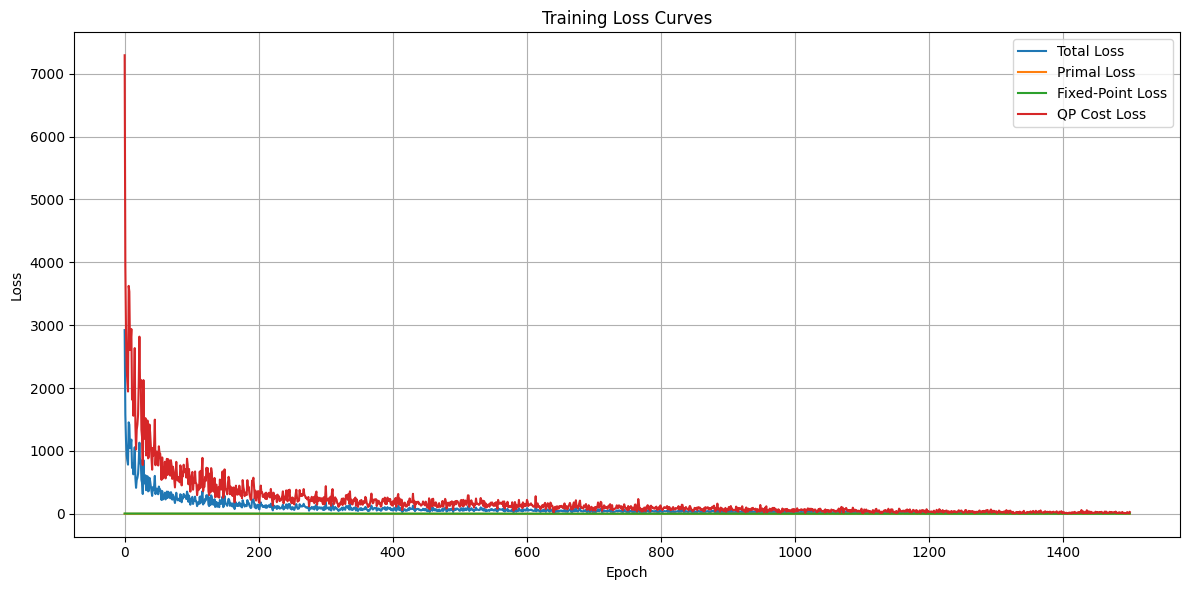

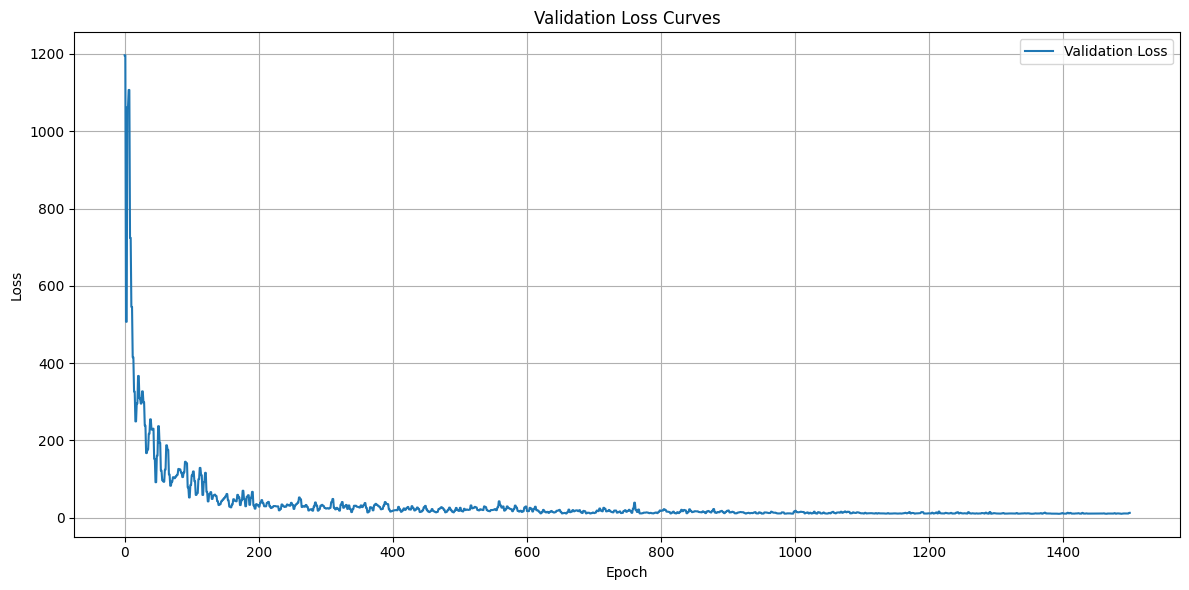

In [14]:
# Plot training losses

plt.figure(figsize=(12, 6))

plt.plot(avg_train_loss, label='Total Loss')
plt.plot(avg_primal_loss, label='Primal Loss')
plt.plot(avg_fixed_point_loss, label='Fixed-Point Loss')
plt.plot(avg_qp_cost_loss, label='QP Cost Loss')


plt.title('Training Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot validation losses
plt.figure(figsize=(12, 6))
plt.plot(avg_val_loss, label='Validation Loss')

plt.title('Validation Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
avg_train_loss = np.asarray(avg_train_loss)
avg_val_loss = np.asarray(avg_val_loss)
print("Training_loss_end", avg_train_loss[-1])
print("Validation_loss_end", avg_val_loss[-1])

Training_loss_end 14.034694
Validation_loss_end 12.673701
